In [124]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
assert matplotlib.__version__ == "3.1.0"

import re

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams["figure.dpi"] = 216
pd.set_option('display.max_colwidth', None)

colors = ["#b57ba6", "#a79ab2","#96c3ce","#73c1c6", "#4bc6b9"]

In [16]:
data = pd.read_csv('Emacs-User-Survey-2020-clean.csv')

In [17]:
data.head()

Submission Date Submission Medium  \
0  2020/11/30 23:48:01           webform   
1  2020/11/30 22:32:43           webform   
2  2020/11/30 22:04:39           webform   
3  2020/11/30 21:54:50           webform   
4  2020/11/30 21:44:11           webform   

       How would you characterize your use of Emacs?  \
0  Use it for work; I use it for serious "hobby" ...   
1  Use it for work; I use it for serious "hobby" ...   
2  Use it for work; I use it for serious "hobby" ...   
3  Use it for work; I use it for serious "hobby" ...   
4  Use it for work; I use it for serious "hobby" ...   

                          What do you use Emacs for?  \
0    Research writing; Writing; Software development   
1  Research writing; Data science; Writing; Softw...   
2                      Software development; Writing   
3  Software development; Writing; Research writin...   
4        Software development; Data science; Writing   

  For how many years have you been using Emacs?  \
0                                             5   
1                                             2   
2                                            10   
3                                             4   
4                                             6   

  Which version of Emacs do you primarily use?  \
0                                           27   
1                                           26   
2                                           27   
3                                           27   
4                                           27   

  Which OS do you primarily use Emacs on?      How do you run Emacs?  \
0                               GNU/Linux  Daemon mode + emacsclient   
1                               GNU/Linux  Daemon mode + emacsclient   
2                               GNU/Linux  Daemon mode + emacsclient   
3                               GNU/Linux  Daemon mode + emacsclient   
4                               GNU/Linux     Standalone application   

                         How do you use Emacs?  \
0                  Graphical Application (GUI)   
1  Graphical Application (GUI); Terminal (TUI)   
2                  Graphical Application (GUI)   
3                  Graphical Application (GUI)   
4  Graphical Application (GUI); Terminal (TUI)   

  If you use Emacs GUI, do you disable any of the graphical elements?  ...  \
0      menu-bar; scroll-bar; tool-bar; splash screen                   ...   
1      tool-bar; scroll-bar; menu-bar; splash screen                   ...   
2      scroll-bar; tool-bar; menu-bar; splash screen                   ...   
3                 visible-bell; scroll-bar; menu-bar                   ...   
4  splash screen; scroll-bar; tool-bar; visible-b...                   ...   

  What Emacs community forums have you visited in the past year?  \
0   r/emacs; I follow twitter Emacs related accounts               
1                                       r/emacs; irc               
2                   r/emacs; Emacs mailing list; irc               
3                       r/emacs; Emacs Stackexchange               
4   r/emacs; Emacs mailing list; Emacs Stackexchange               

  What are some of the Emacs improvements you are the most interested in?  \
0                                                NaN                        
1  guile-emacs, emacs-jit, native-threads/generators                        
2  Very glad to have native json parsing in Emacs...                        
3  Better support for ligatures, building on harf...                        
4                                                NaN                        

    What do you think are Emacs' greatest strengths?  \
0                             How configurable it is   
1  It is a Lisp application platform with a very ...   
2  Elisp and extensibility (the "lisp machine" th...   
3  Emacs is whatever you want it to be baby\n\nTh...   
4                                                NaN   

  Can you recall any difficulties you faced init

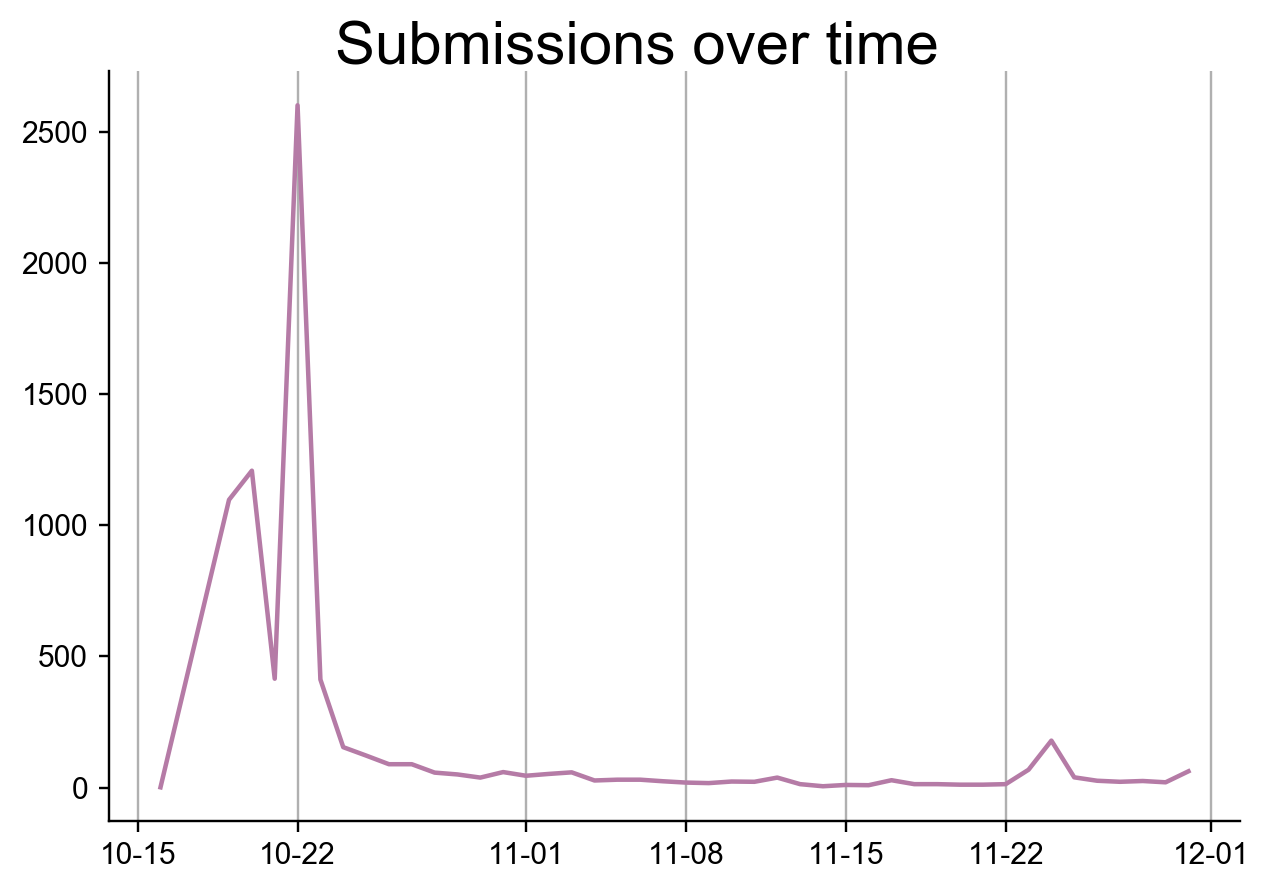

In [91]:
import datetime
import matplotlib.dates as mdates

dates = data['Submission Date']
#print(dates)

#print(datetime.datetime.strptime('2020/11/30 21:44:11', "%Y/%m/%d %H:%M:%S"))

buckets = {}
for d in dates:
    if d[0] == '2':
        mask = "%Y/%m/%d %H:%M:%S"
    else:
        # Mon Oct 19 11:48:00 EDT 2020
        d = d.replace("EST ", "").replace("EDT ", "")
        mask = "%a %b %d %H:%M:%S %Y"
        
    date = datetime.datetime.strptime(d, mask).date()
    if date not in buckets:
        buckets[date] = 1
    else:
        buckets[date] += 1


df = pd.DataFrame({'lab':[v for v in buckets], 'val':[buckets[v] for v in buckets]})
df = df.sort_values(by='lab',ascending=True)

#print(df)

ax = df.plot.line(x='lab', y='val', legend=False, color=colors[0])
plt.suptitle('Submissions over time', fontsize=20, y=1.02)
date_form = mdates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

ax.spines["top"].set_visible(False)     
ax.spines["right"].set_visible(False) 
#ax.set_xticklabels(ax.get_xticklabels(), rotation=-40, ha="left")
ax.set_xlabel('')
plt.grid(axis='x')
plt.tight_layout()
#plt.show()
plt.savefig('submissions-over-time.png', bbox_inches='tight', pad_inches=.2)


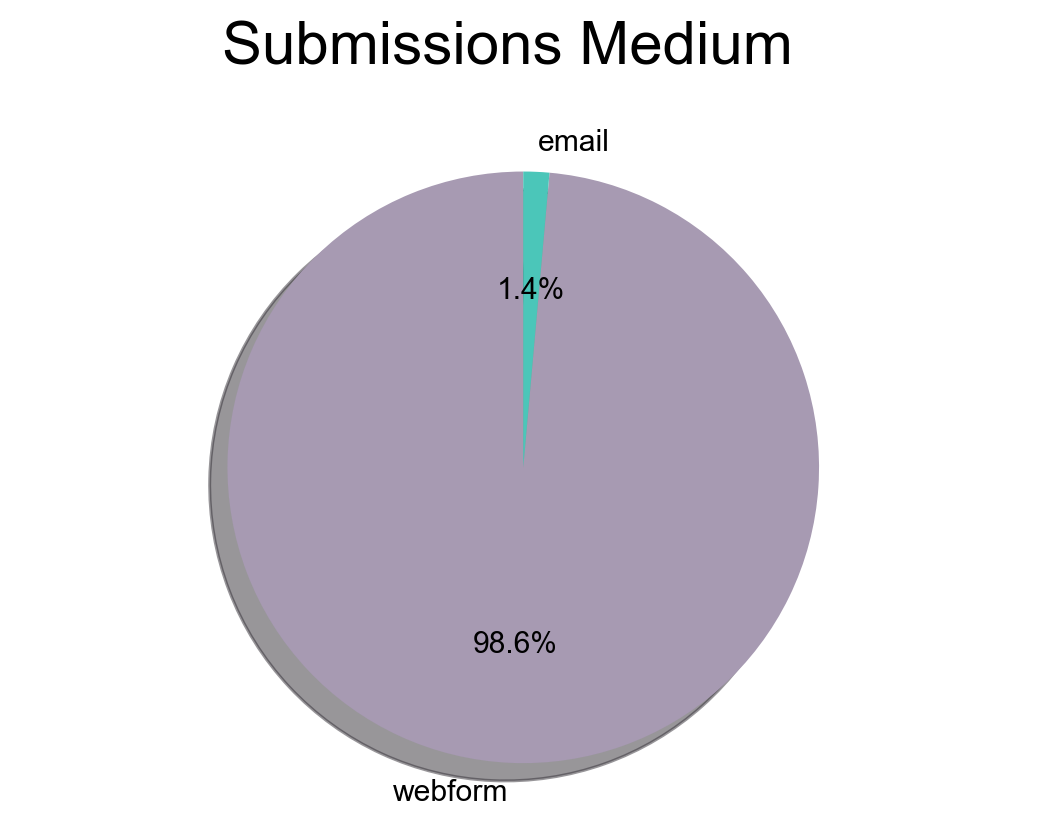

In [93]:
rows = data['Submission Medium']

webform = data['Submission Medium'][data['Submission Medium'] == 'webform'].count()
email = data['Submission Medium'][data['Submission Medium'] == 'email'].count()
sizes = [webform, email]
labels = ['webform', 'email']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=[colors[1],colors[4]],
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('Submissions Medium', fontsize=20, y=1.02)

#plt.show()
plt.savefig('submissions-medium.png', bbox_inches='tight', pad_inches=.2)

In [20]:
def multiple_choice(field, bucket_min=100, separator=';'):
    rows = data[field].str.split(separator, expand=False)
    buckets = {}
    for row in rows:
        if isinstance(row, float):
            # it's a nan
            continue
        for v in row:
            key = v.strip().lower()
            if key not in buckets:
                buckets[key] = 1
            else:
                buckets[key] += 1
                
    final = {}
    other = 0
    for b in buckets:
        if buckets[b] > bucket_min:
            final[b] = buckets[b]
        else:
            other += buckets[b]
    final['other'] = other
    df = pd.DataFrame({field:[k for k in final], 'total':[final[k] for k in final]})
    df_full = pd.DataFrame({field:[k for k in buckets], 'total':[buckets[k] for k in buckets]})
    df_full = df_full.sort_values(by='total',ascending=False)
    return df, df_full

def format_tick(t):
    text = t._text
    if len(t._text) > 20:
        final = ''
        temp = ''
        for s in text.split(' '):
            temp += ' '+ str(s)
            if len(temp) > 20 or s == '-':
                final += temp +'\n'
                temp = ''
        final += temp
        return final
    return t

def to_title(field):
    return re.sub('[^0-9a-zA-Z\-]+', '', field.lower().replace(' ', '-'))
    
def barh(field, df, save=True):
    df = df.sort_values(by='total',ascending=True)
    ax = df.plot.barh(x=field, y='total', color=reversed(colors), legend=False, figsize=(10,10), fontsize=18)
    plt.suptitle(field, fontsize=20, y=0.95)
    ax.spines["top"].set_visible(False)     
    ax.spines["right"].set_visible(False)
    ax.set_yticklabels([format_tick(t) for t in ax.get_yticklabels()])
    ax.set_ylabel('')
    plt.grid(axis='y')
    if save:
        title = to_title(field)
        plt.savefig(title+'.png', bbox_inches='tight', pad_inches=.2)
    else:
        plt.show()
        
def save_table(field, df_full):
    title = to_title(field)
    with open(title + ".html", "w") as buf:
        df_full.to_html(buf=buf, index=False, justify='left', classes='my-table')
        
from IPython.display import display, HTML

def table(field):
    _, df_full = multiple_choice(field)
    display(HTML(df_full.sort_values(by='total',ascending=False).to_html(notebook=True, index=False, justify='left')))
    
def render(field, save=True):
    df, _ = multiple_choice(field)
    barh(field, df, save)

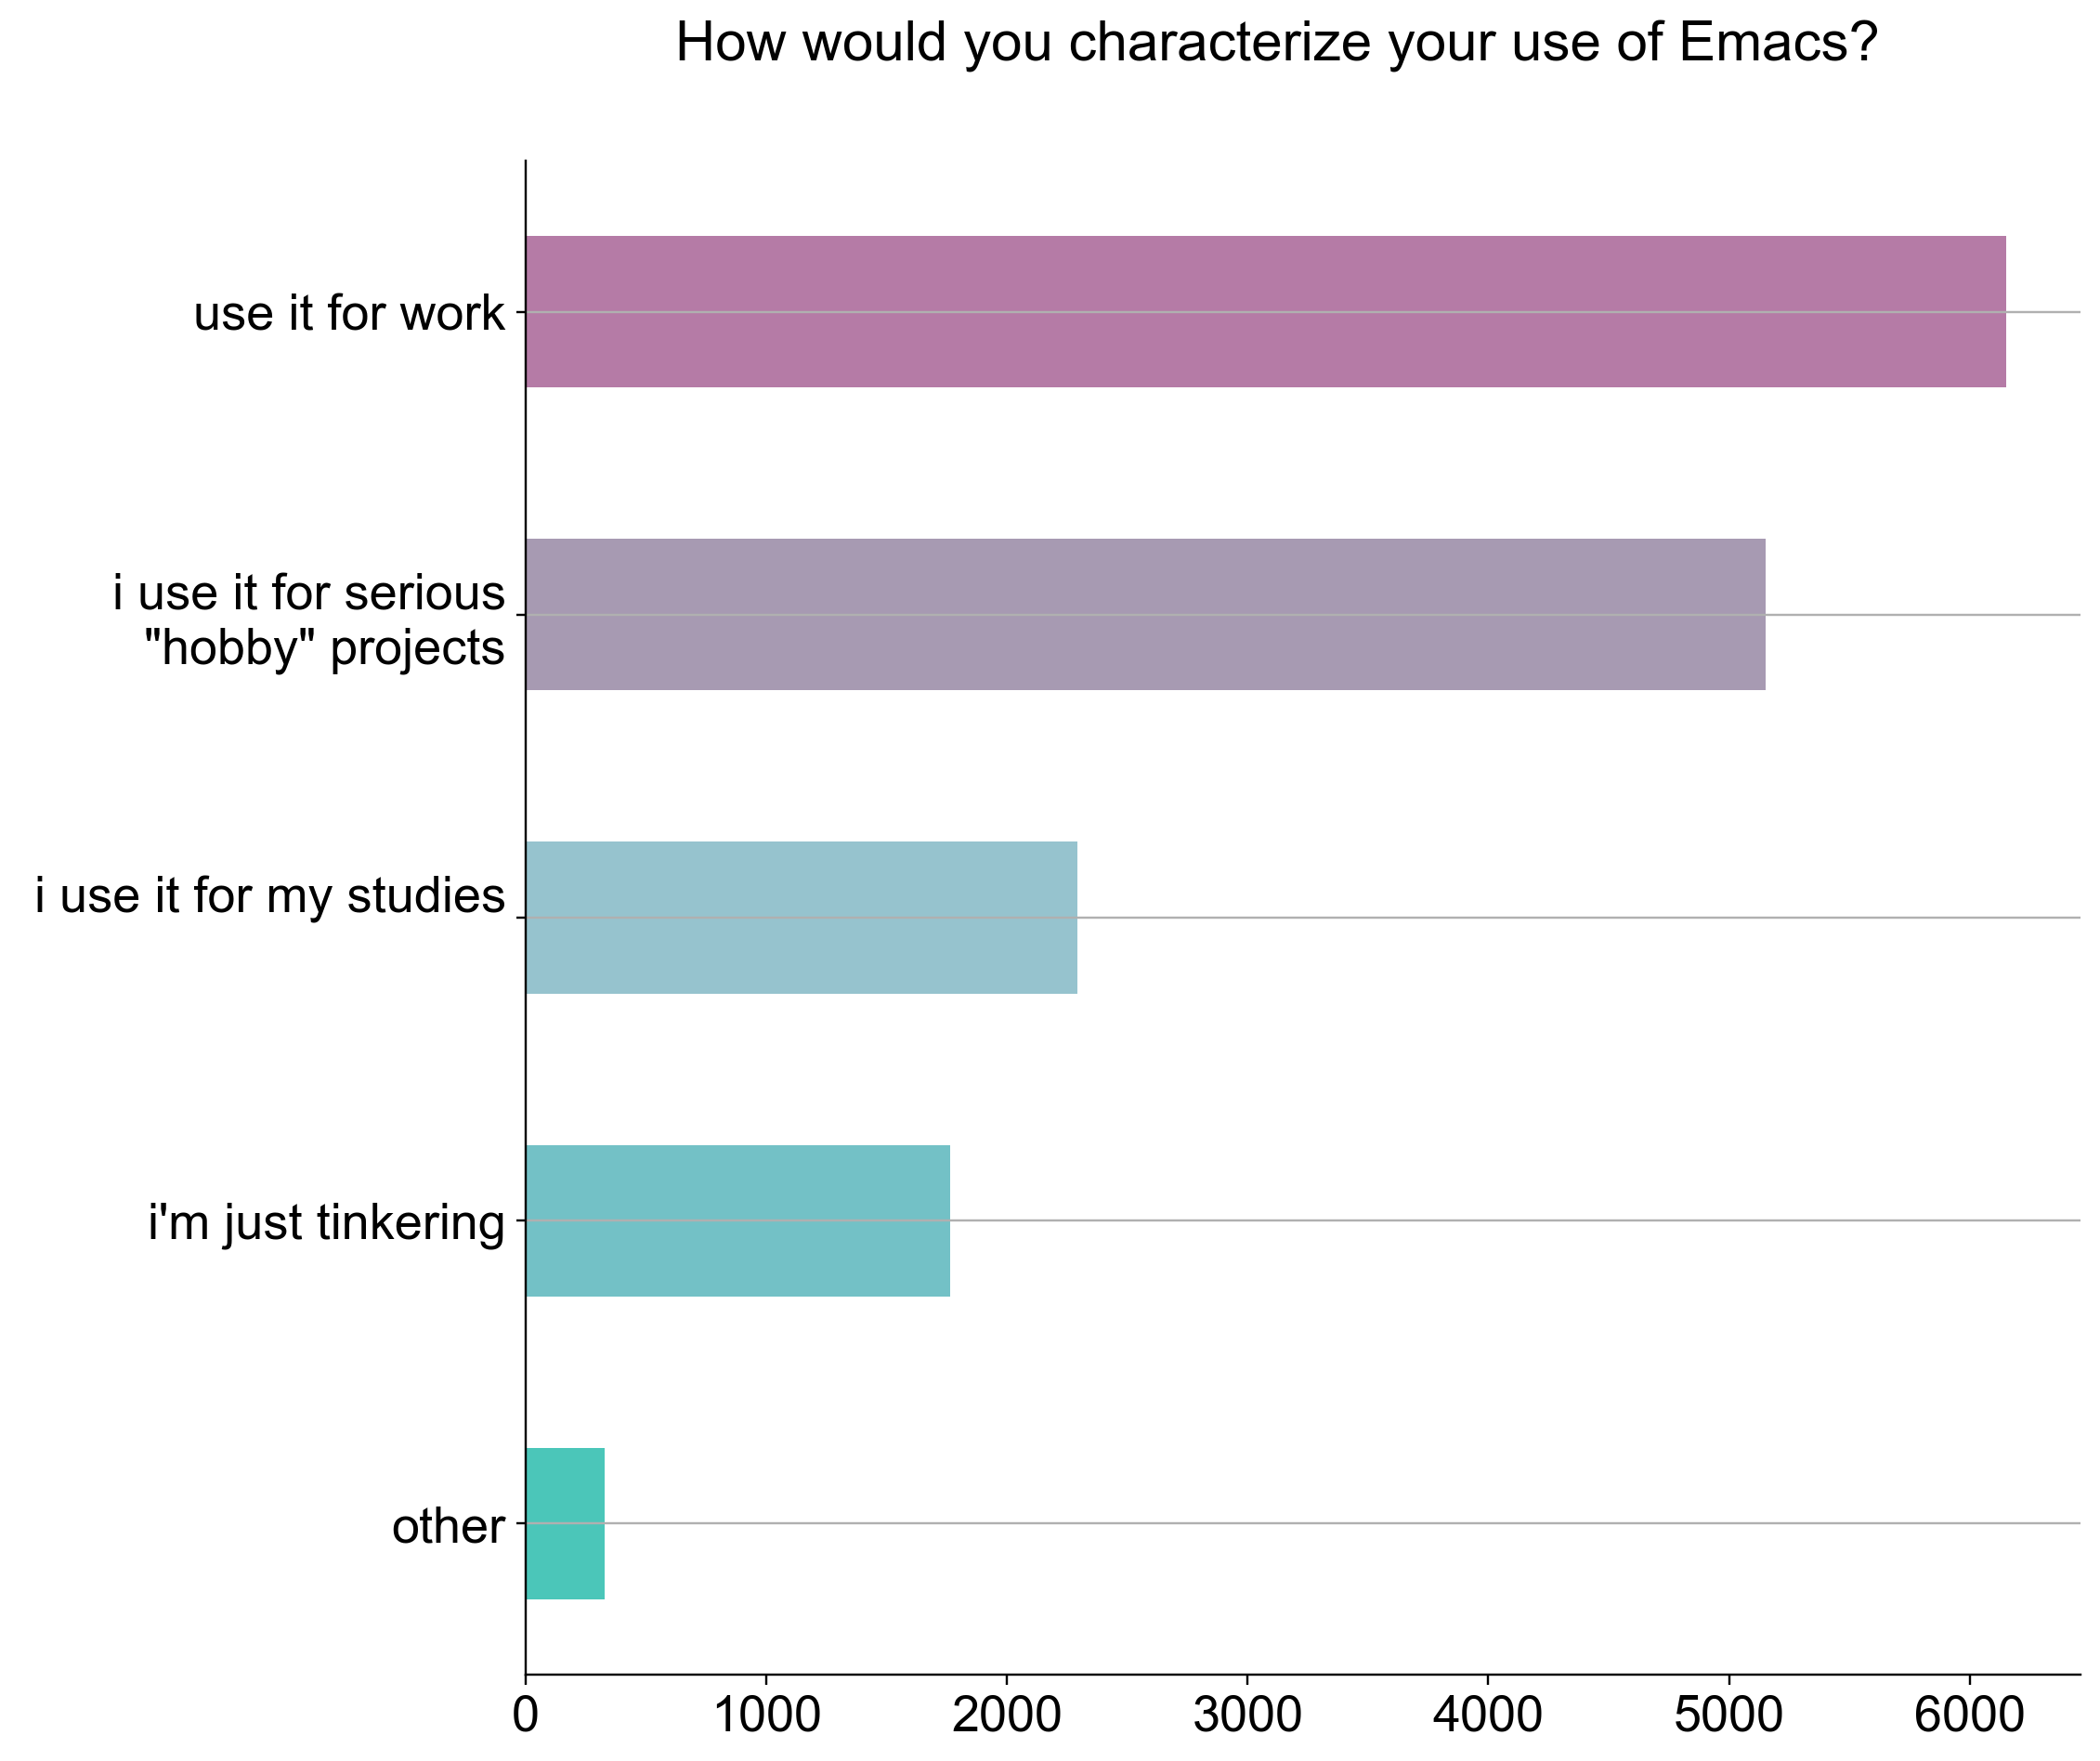

In [15]:
render('How would you characterize your use of Emacs?')

In [126]:
table('How would you characterize your use of Emacs?')

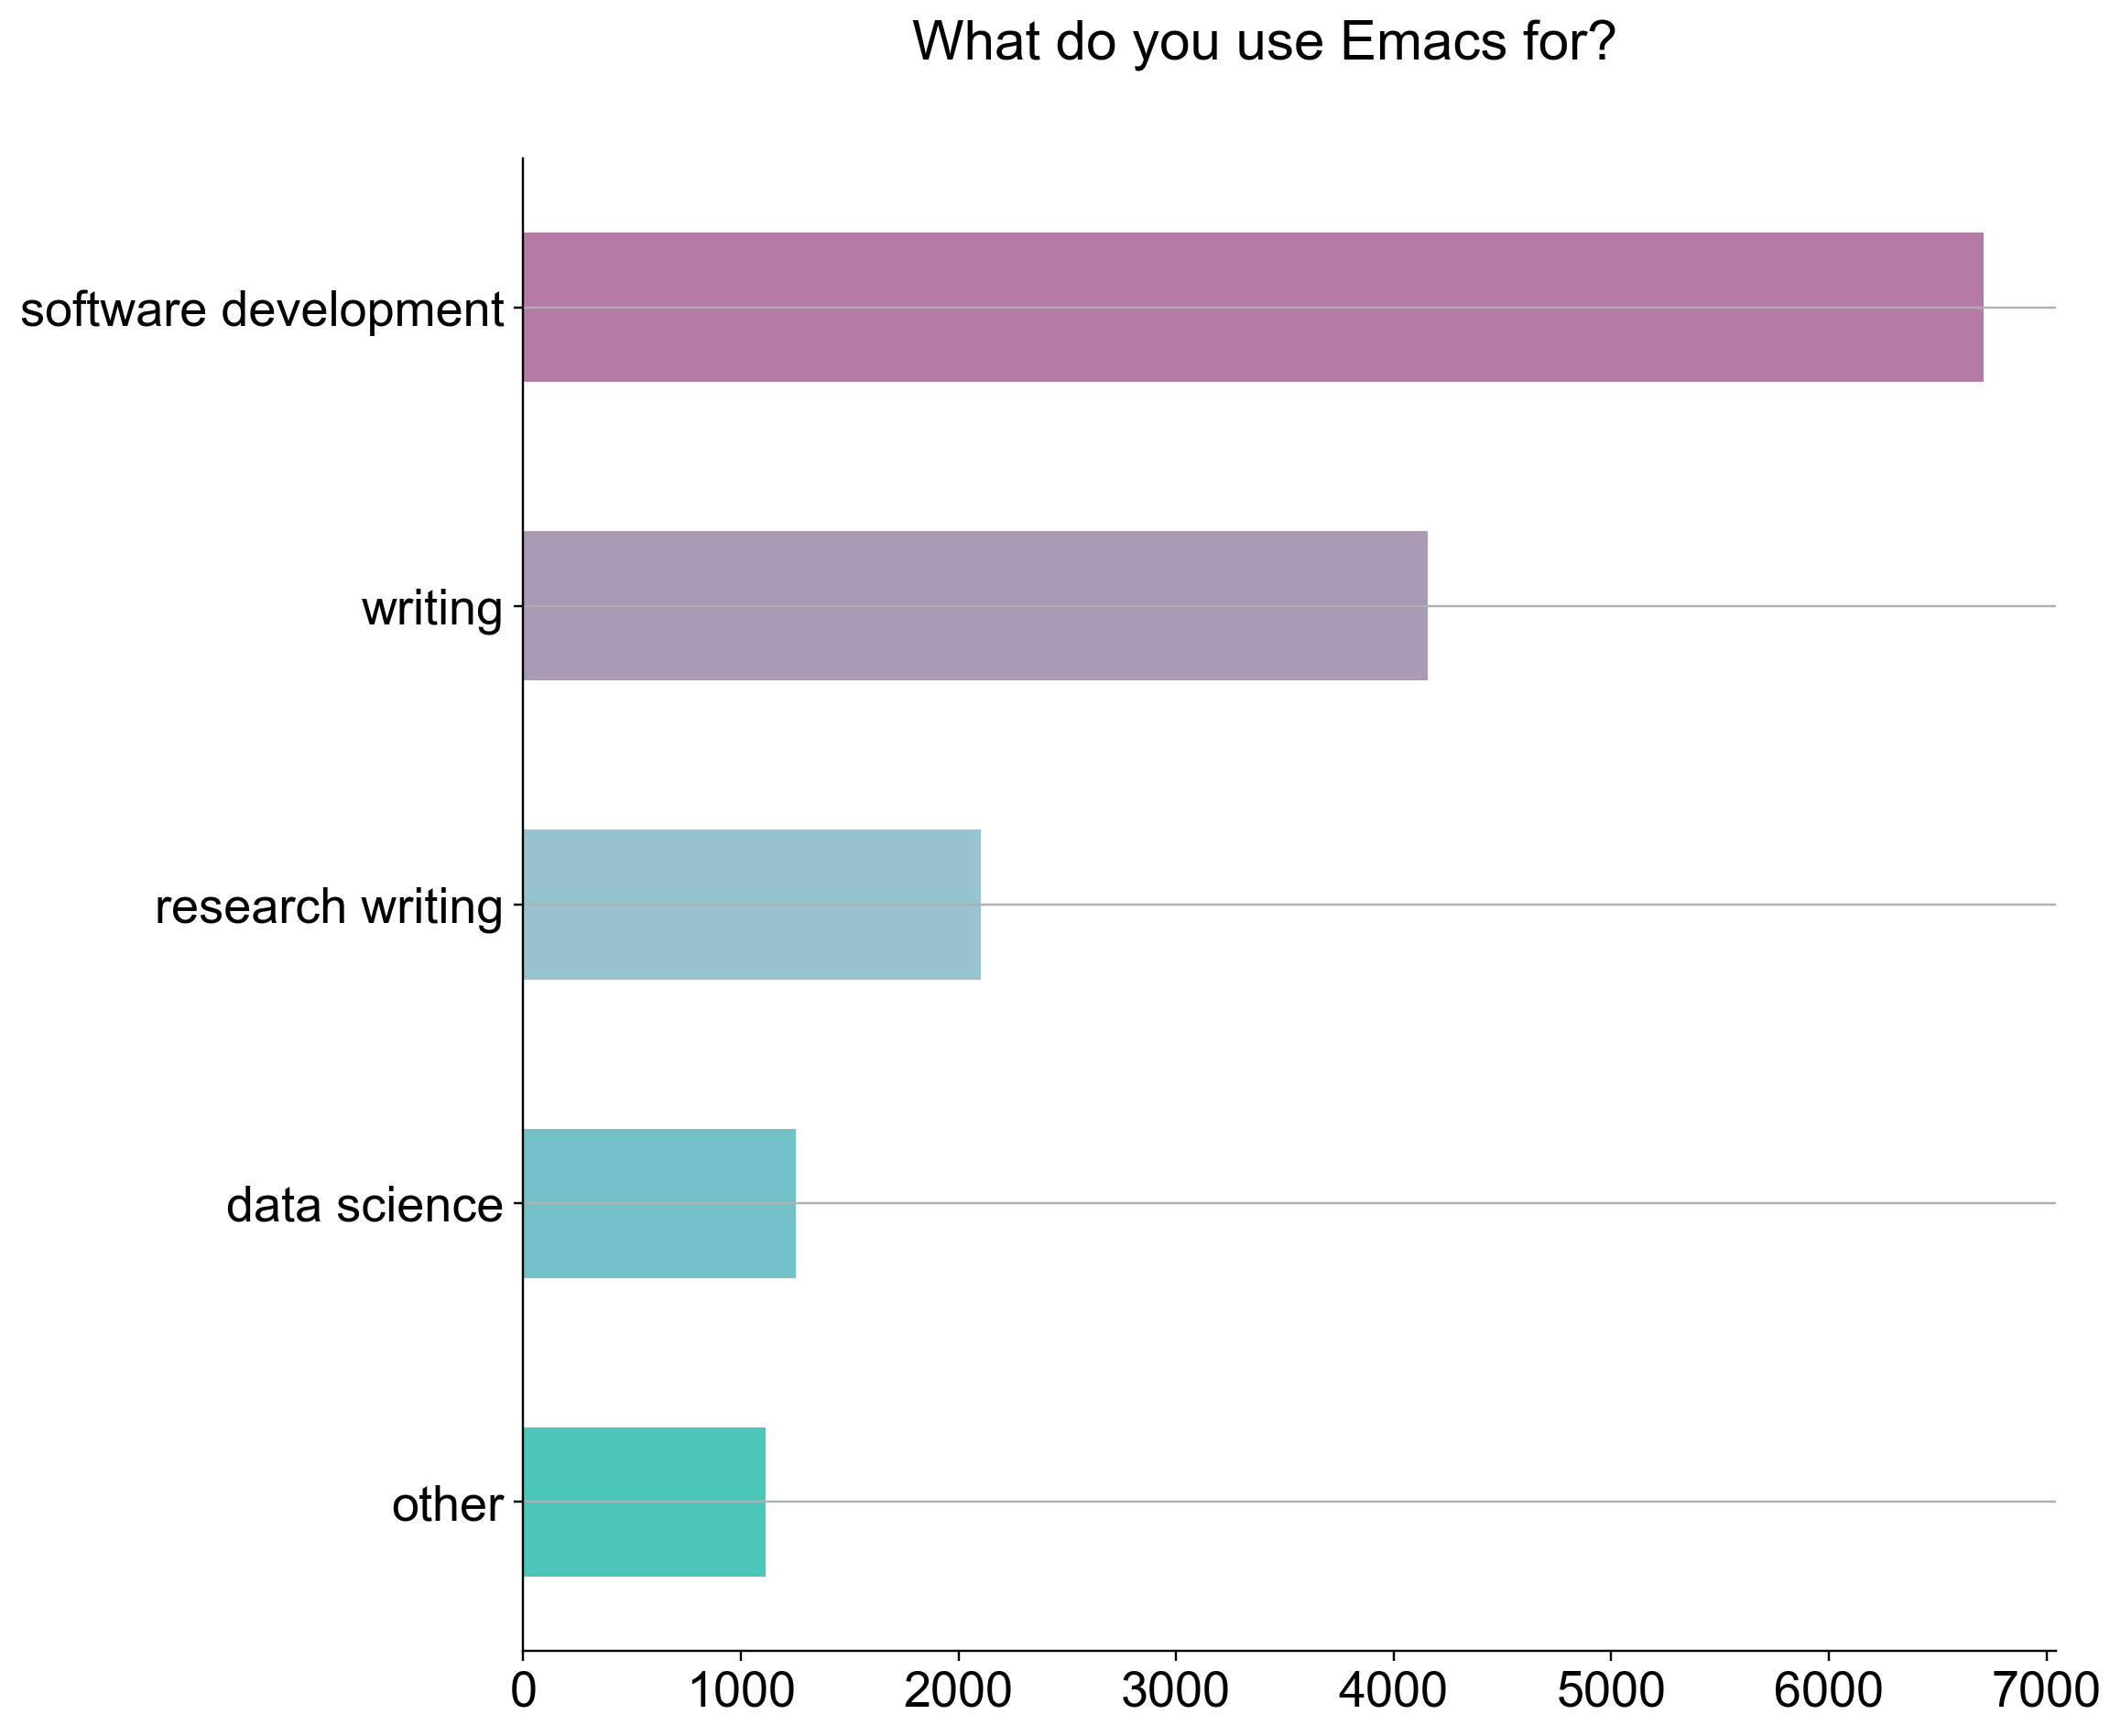

In [23]:
render('What do you use Emacs for?')

In [127]:
table('What do you use Emacs for?')

count    7286.000000
mean        9.922591
std         9.328345
min         0.000000
25%         3.000000
50%         6.000000
75%        15.000000
max        45.000000
dtype: float64


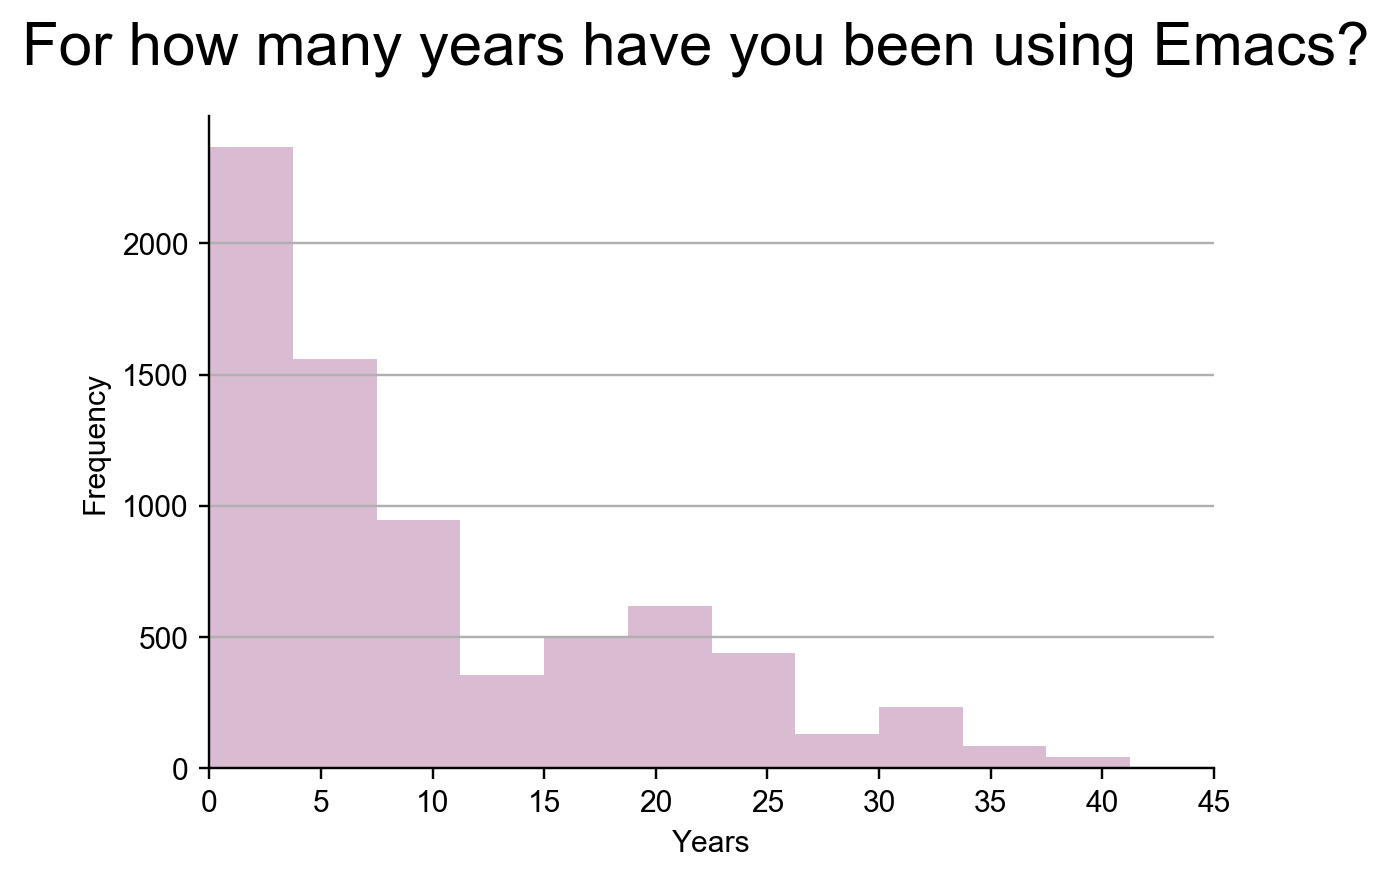

In [25]:
field = 'For how many years have you been using Emacs?'
rows = data[field]
years = []
for row in rows:
    try:
        year = float(row)
    except:
        # print(row)
        continue
    if year >= 0 and year <= 45:
        years.append(year)
        
        

series = pd.Series(years)
#print(series)

#print(series.mean())
print(series.describe())
#print(series.to_frame().to_html(notebook=True))

#series.plot.kde()
ax = series.plot.hist(bins=12, alpha=0.5, xlim=(0,45), color=colors[0])
plt.suptitle(field, fontsize=20, y=0.99)
ax.spines["top"].set_visible(False)     
ax.spines["right"].set_visible(False) 
ax.set_xlabel('Years')
plt.grid(axis='y')
plt.savefig(to_title(field)+'.png', bbox_inches='tight', pad_inches=.2)

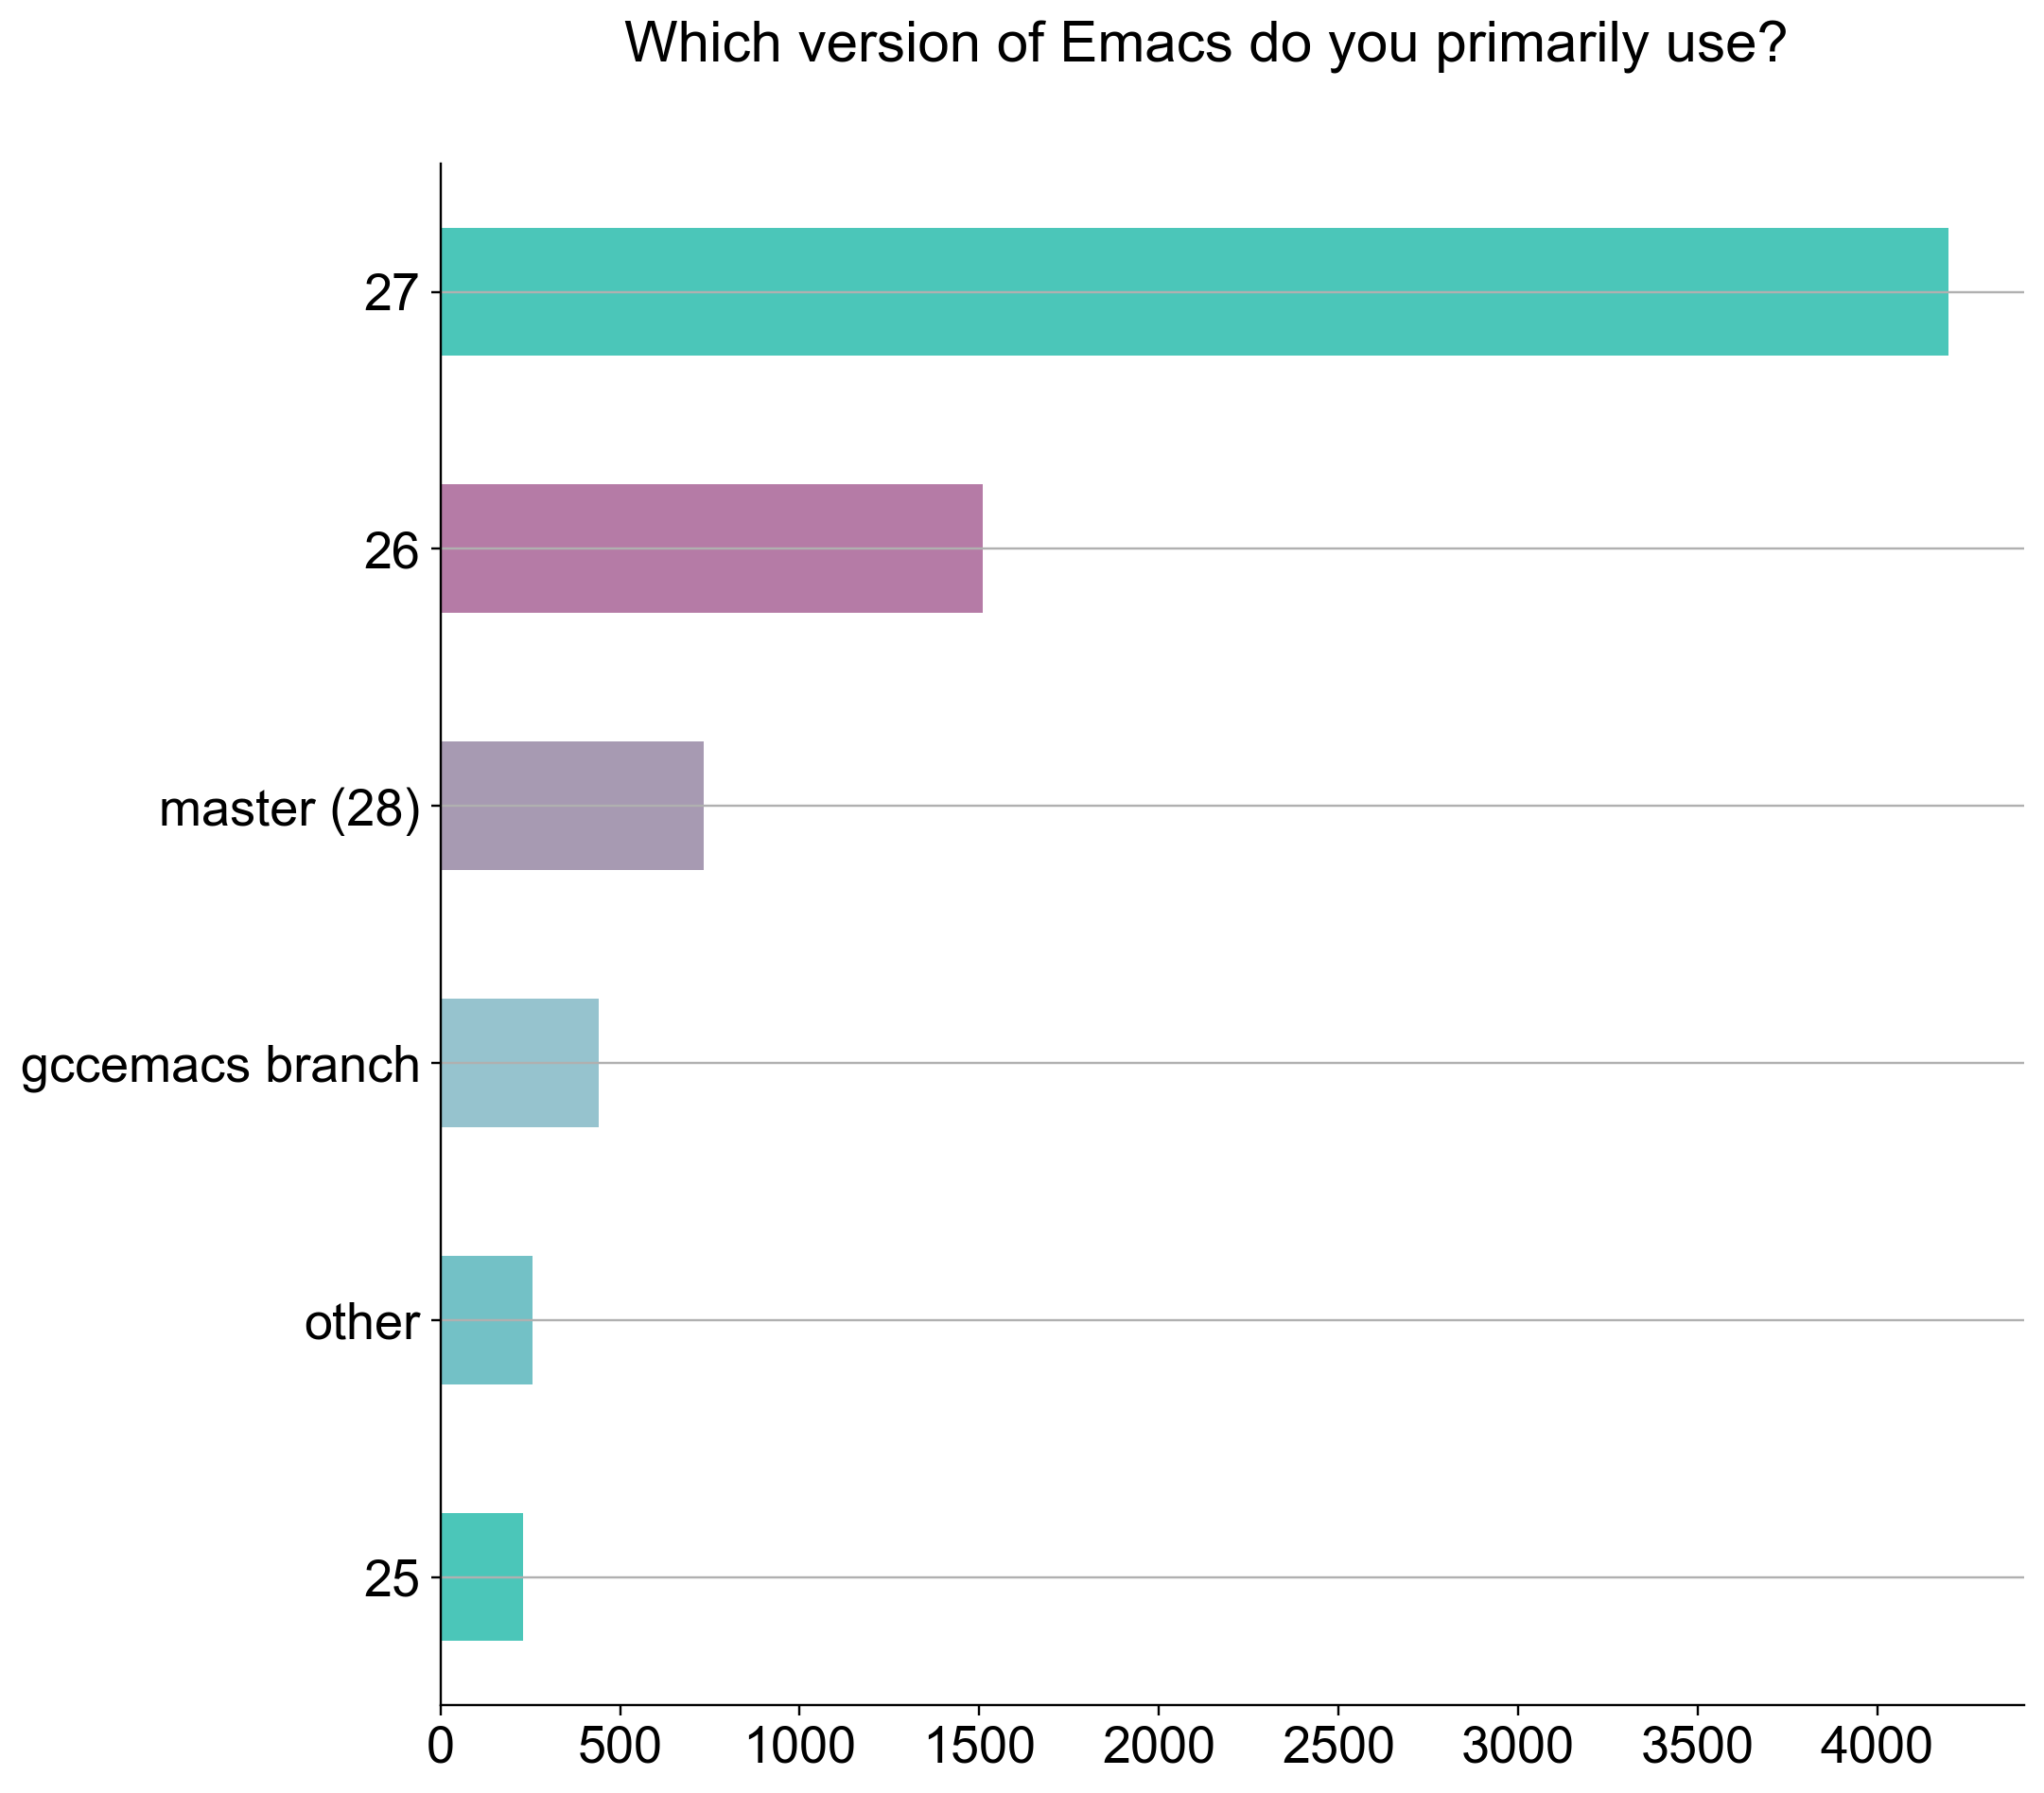

In [27]:
render('Which version of Emacs do you primarily use?')

In [128]:
table('Which version of Emacs do you primarily use?')

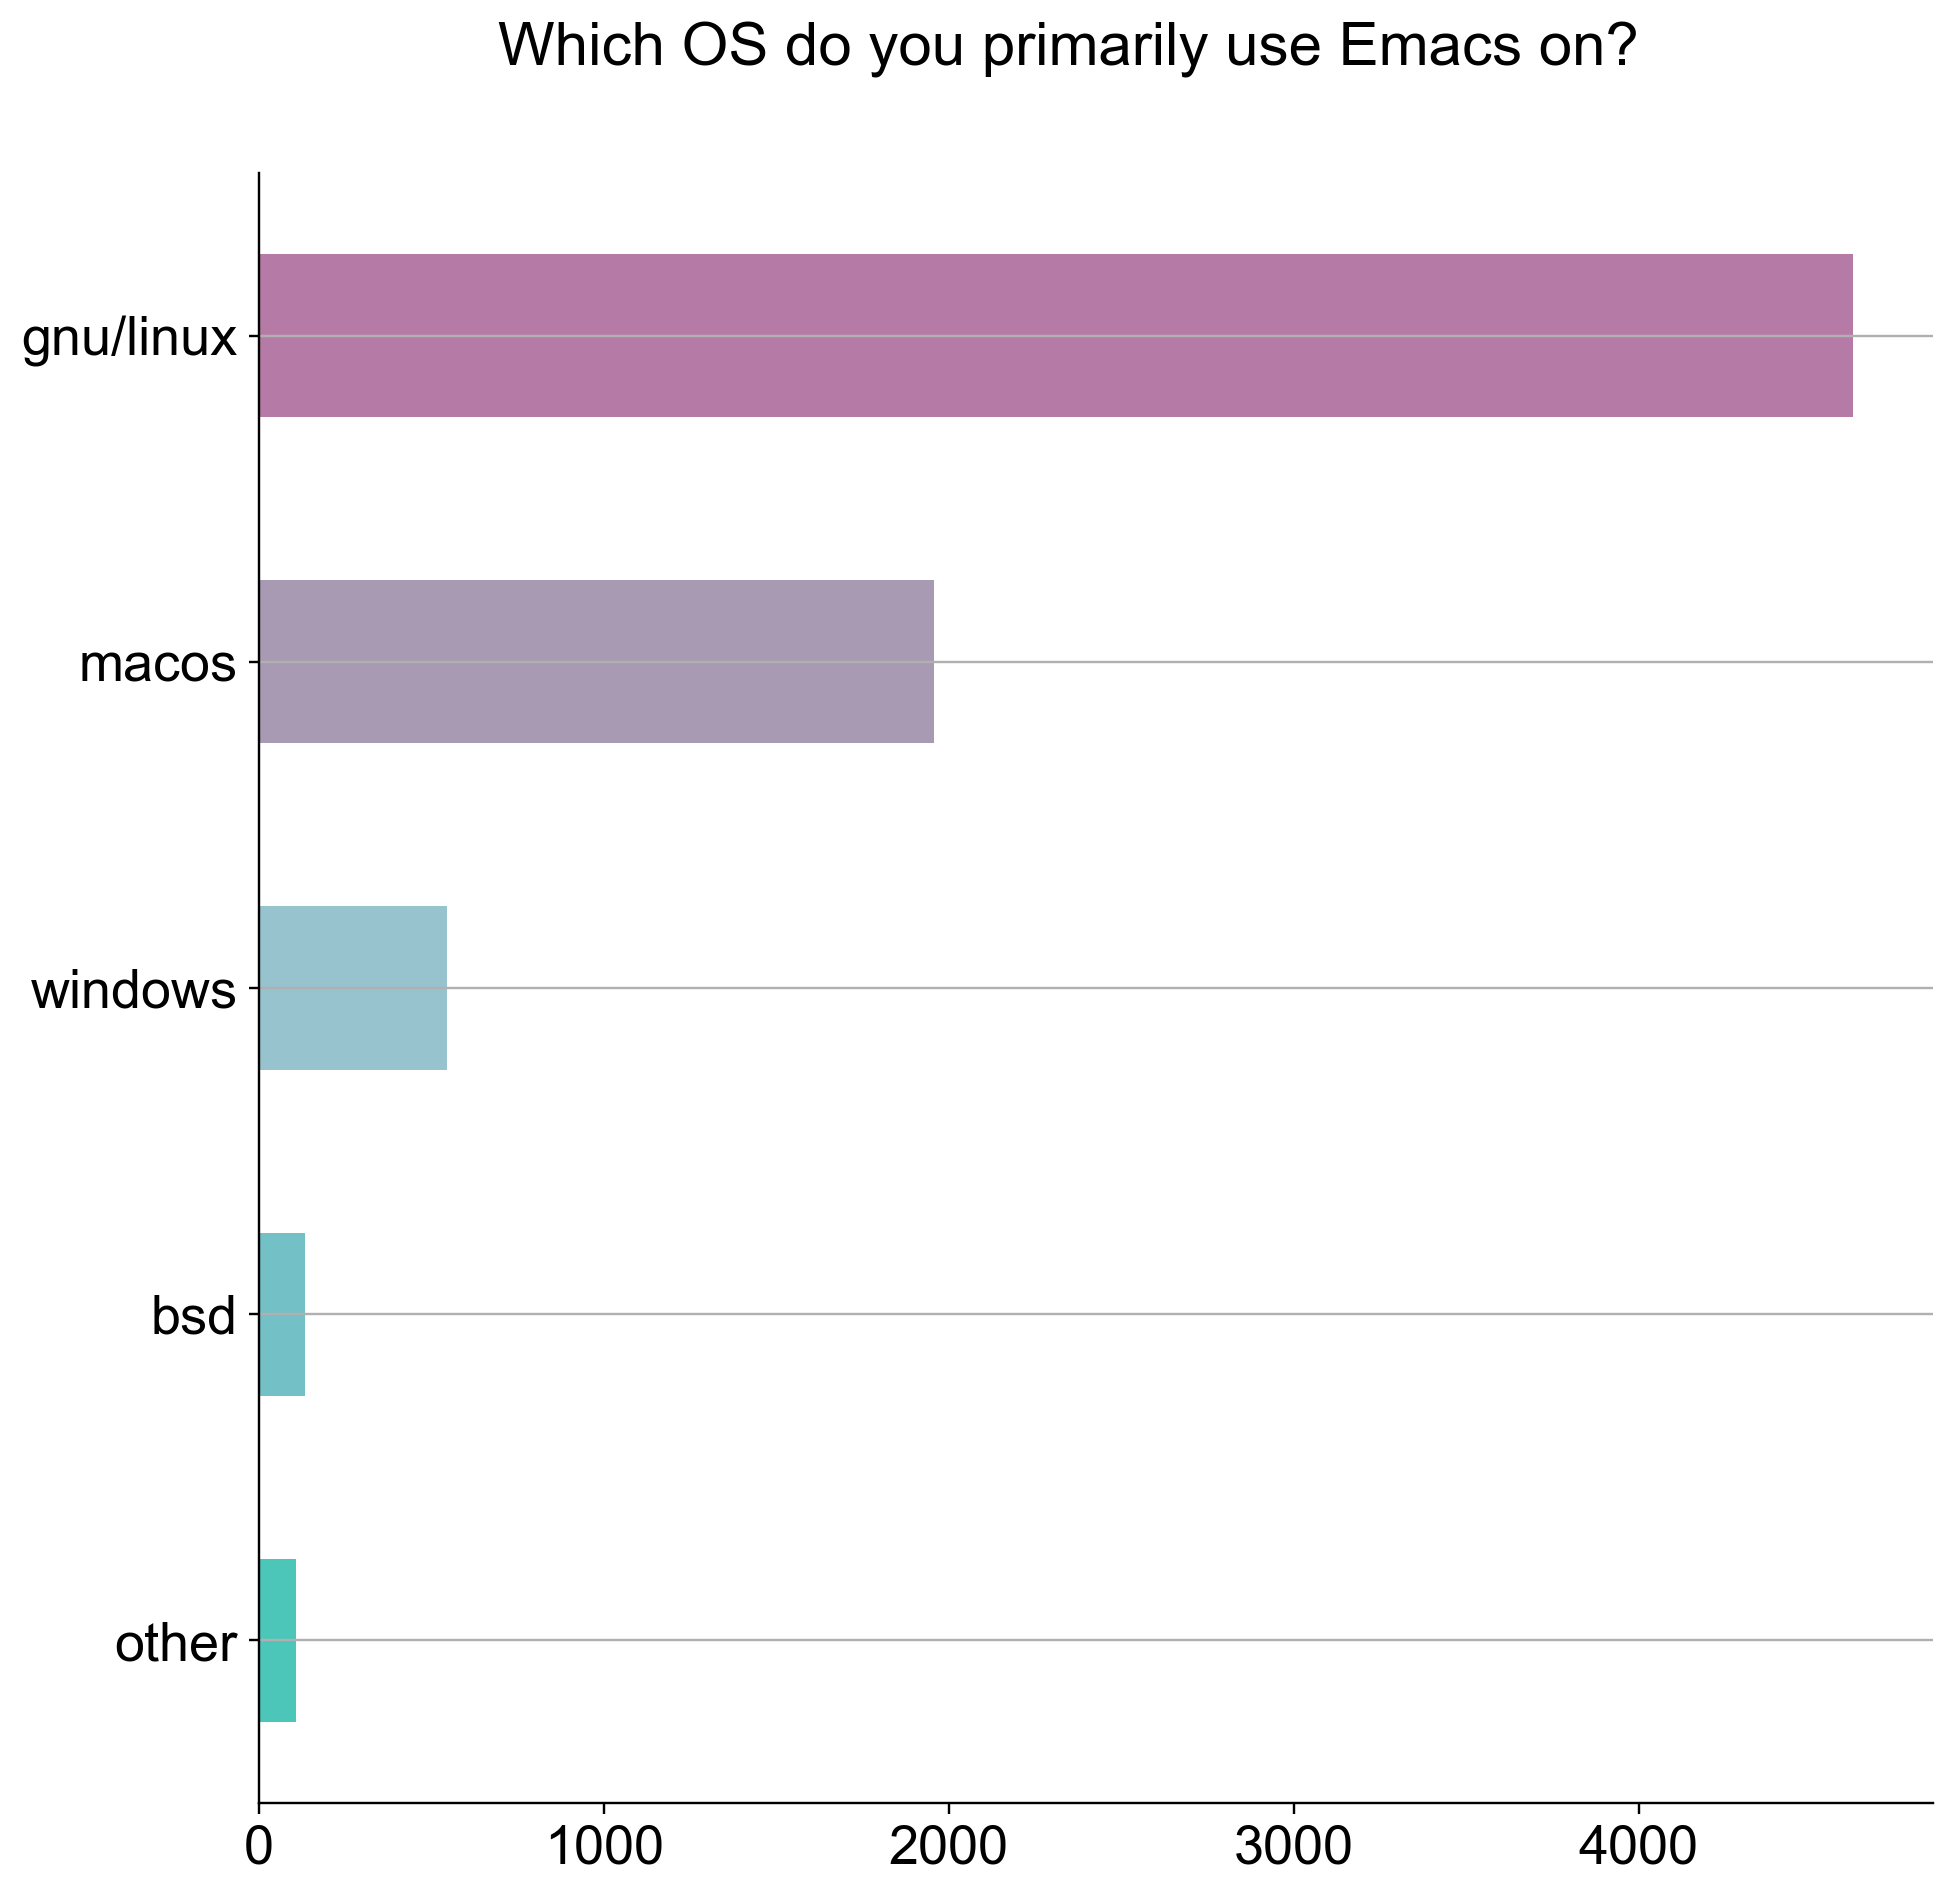

In [29]:
render('Which OS do you primarily use Emacs on?')

In [129]:
table('Which OS do you primarily use Emacs on?')

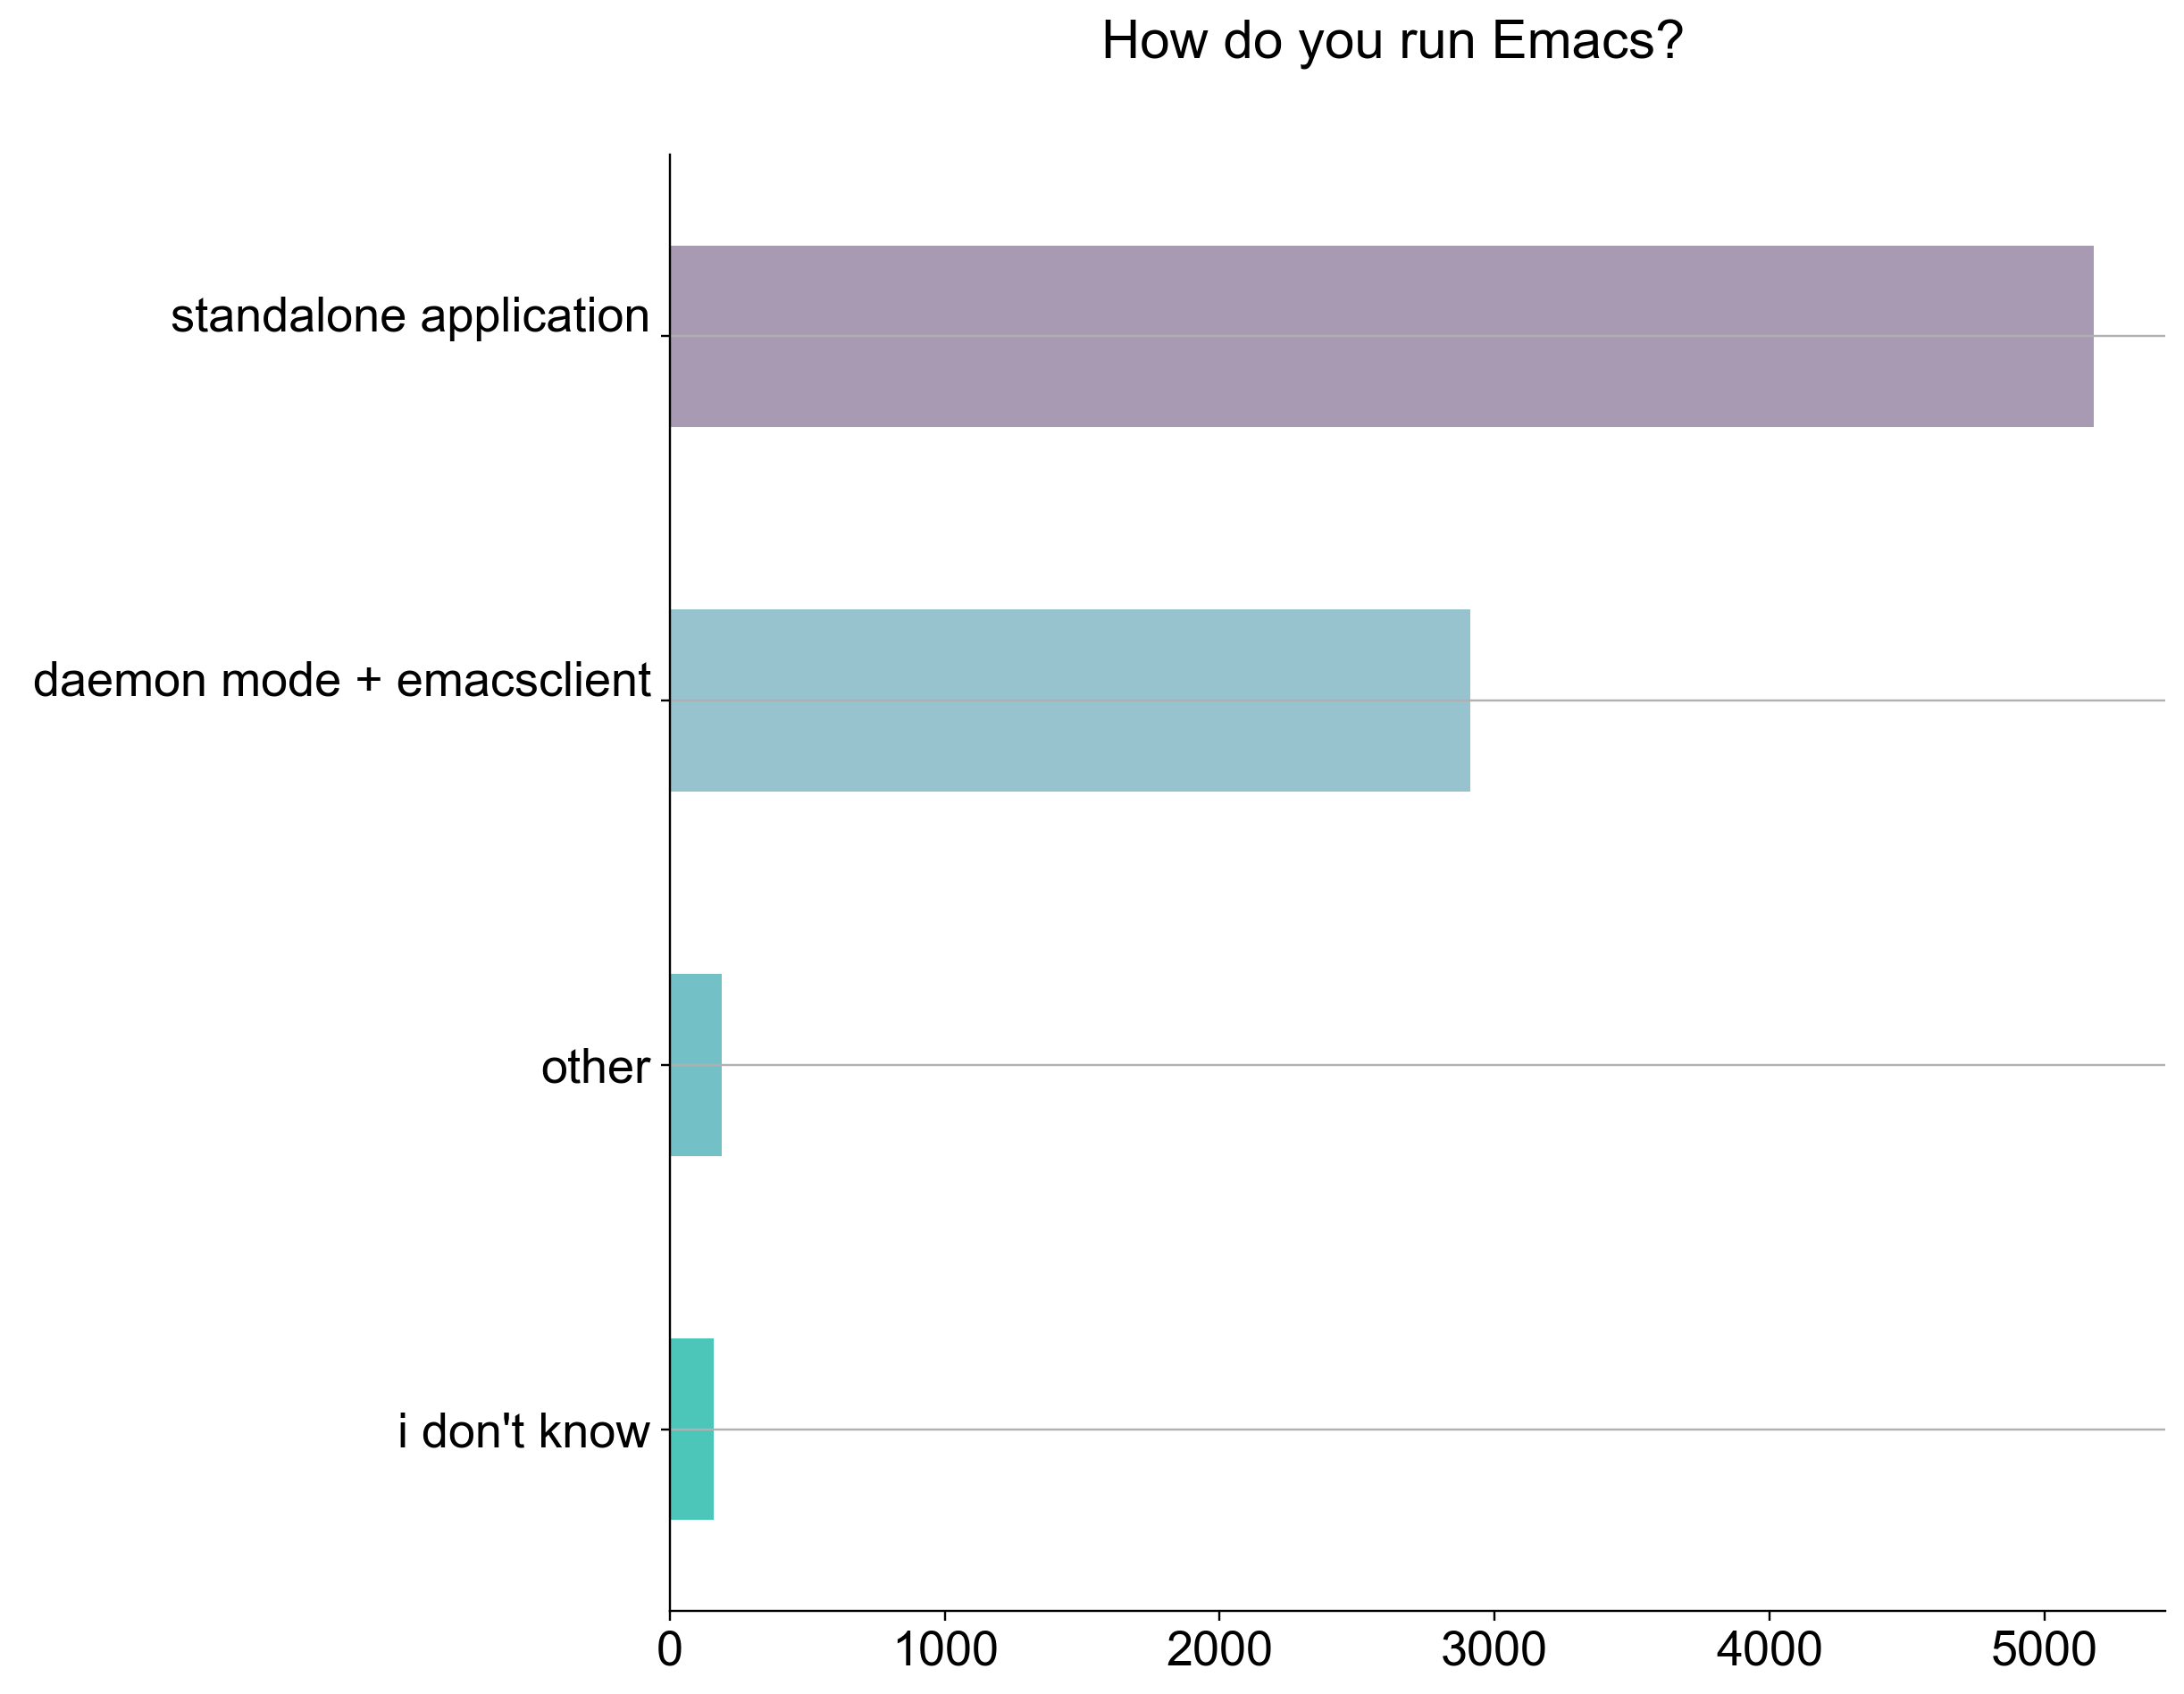

In [31]:
render('How do you run Emacs?')

In [130]:
table('How do you run Emacs?')

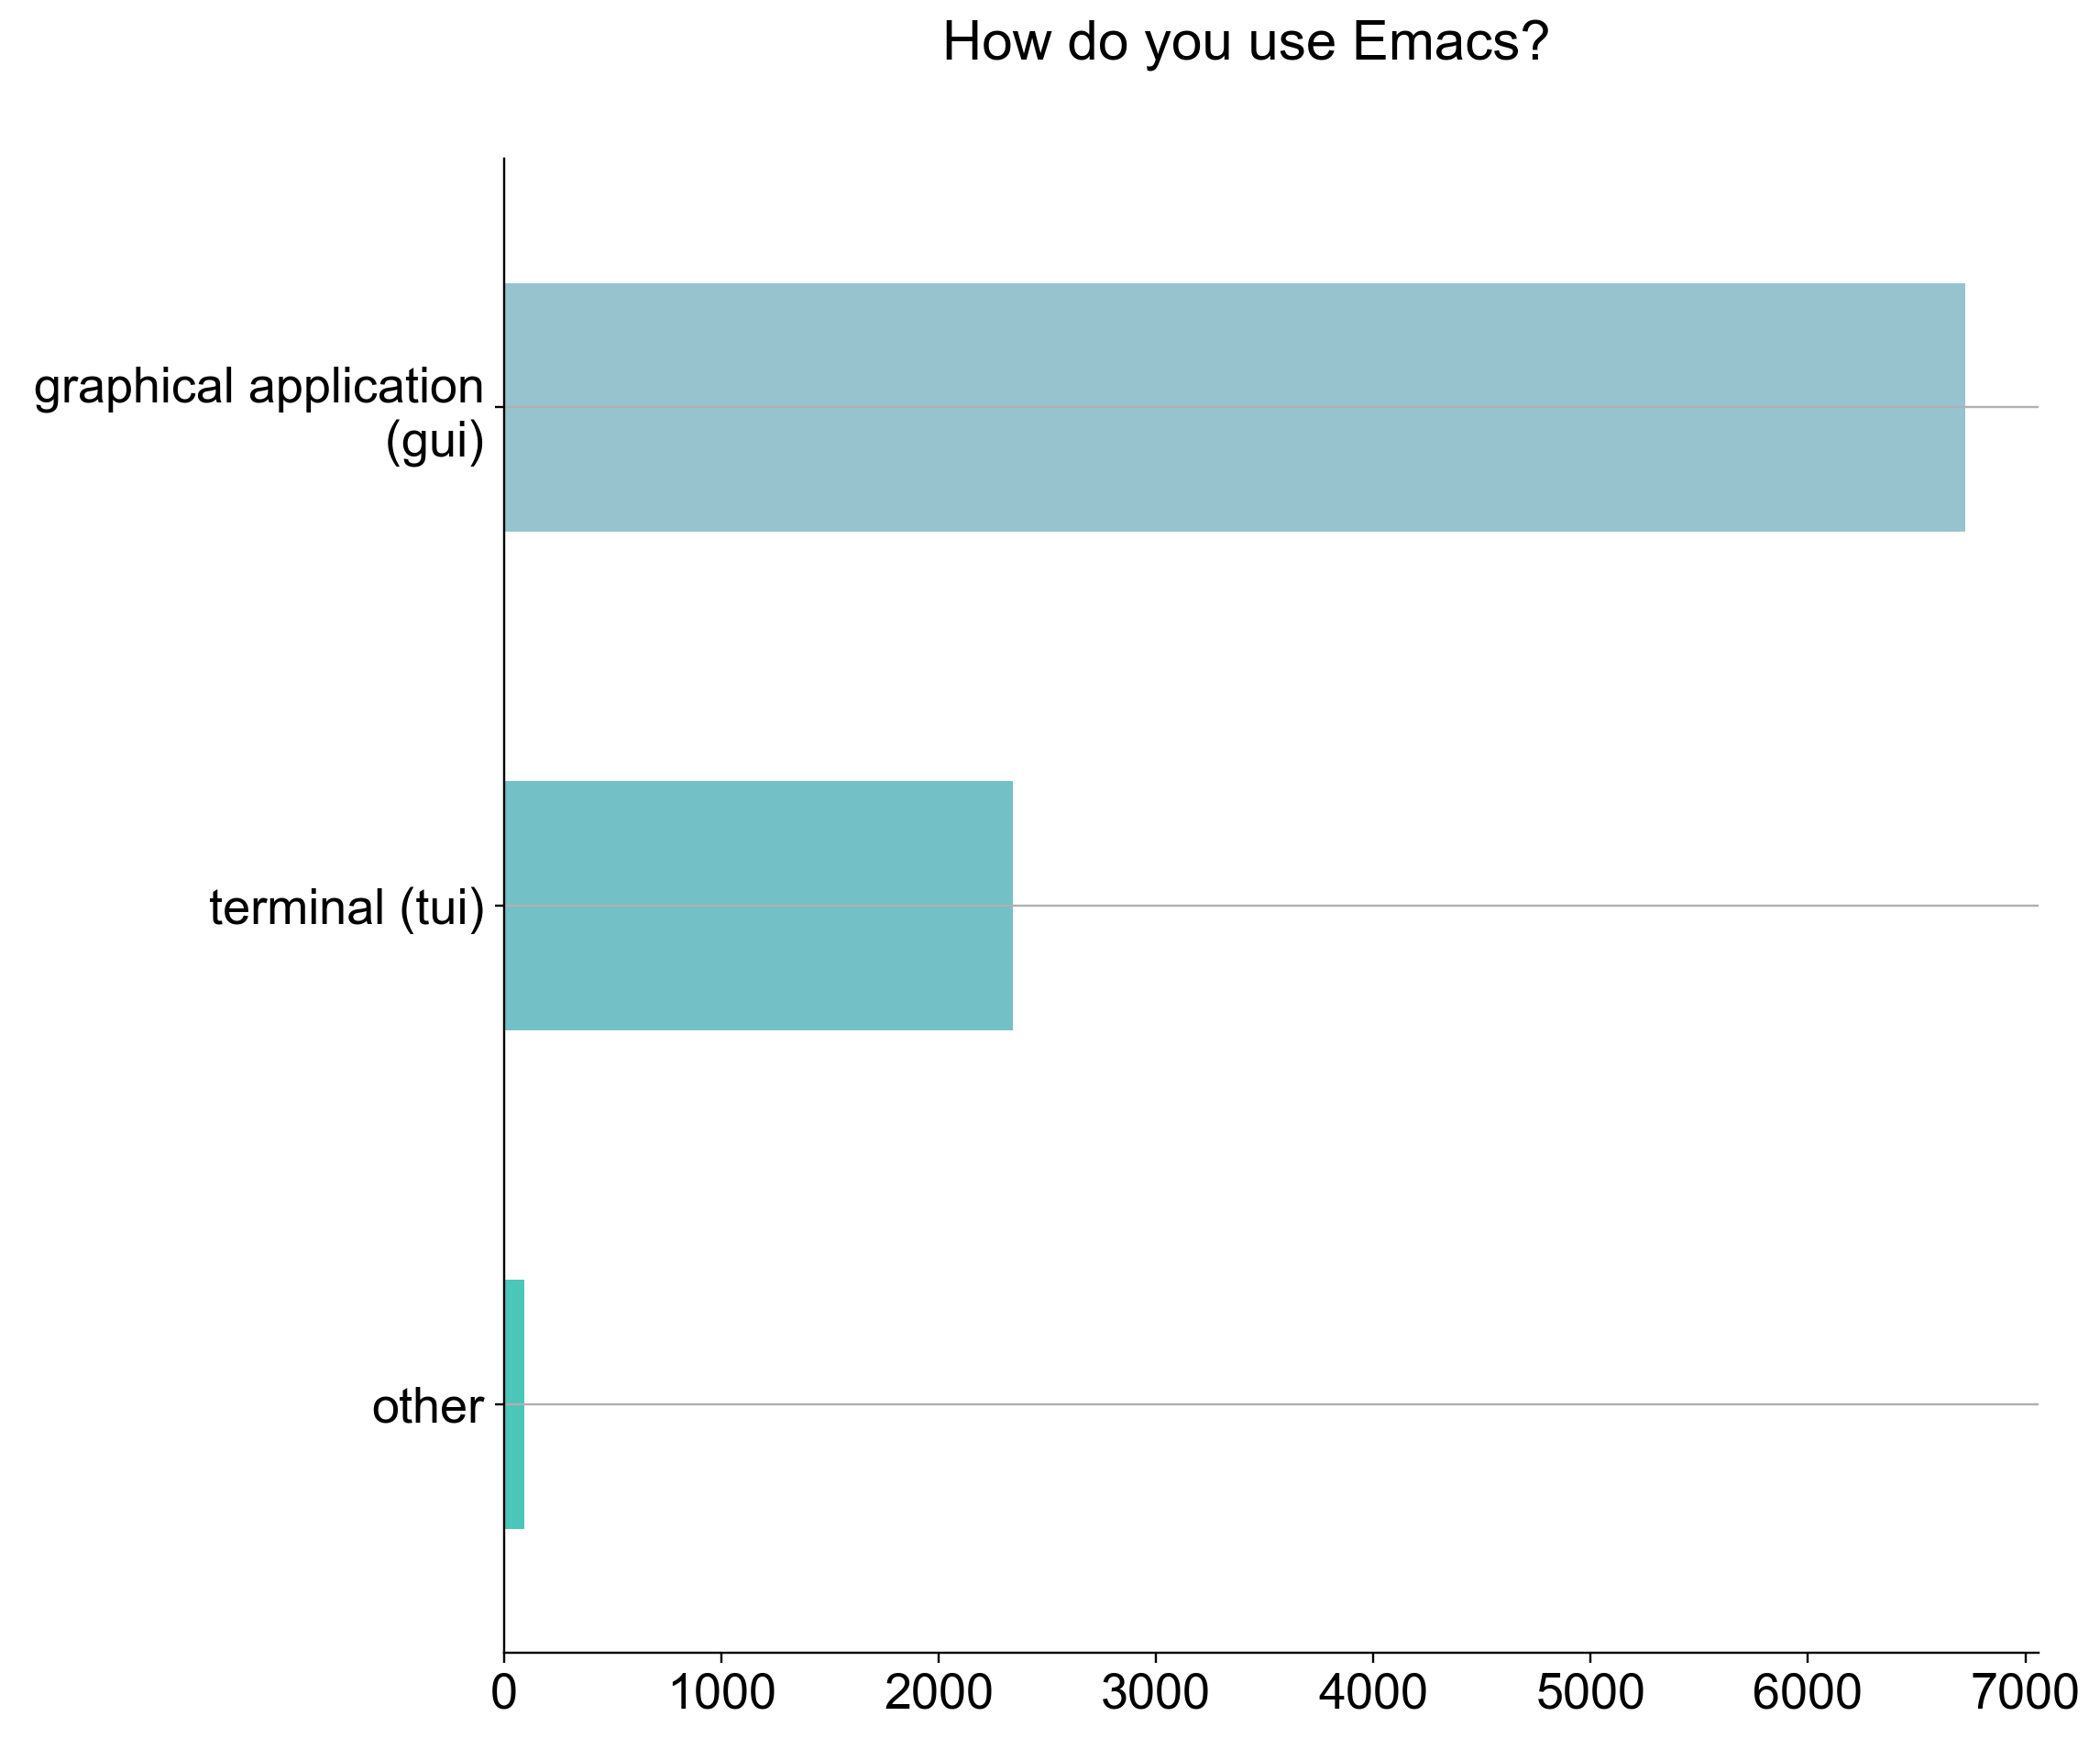

In [33]:
render('How do you use Emacs?')

In [131]:
table('How do you use Emacs?')

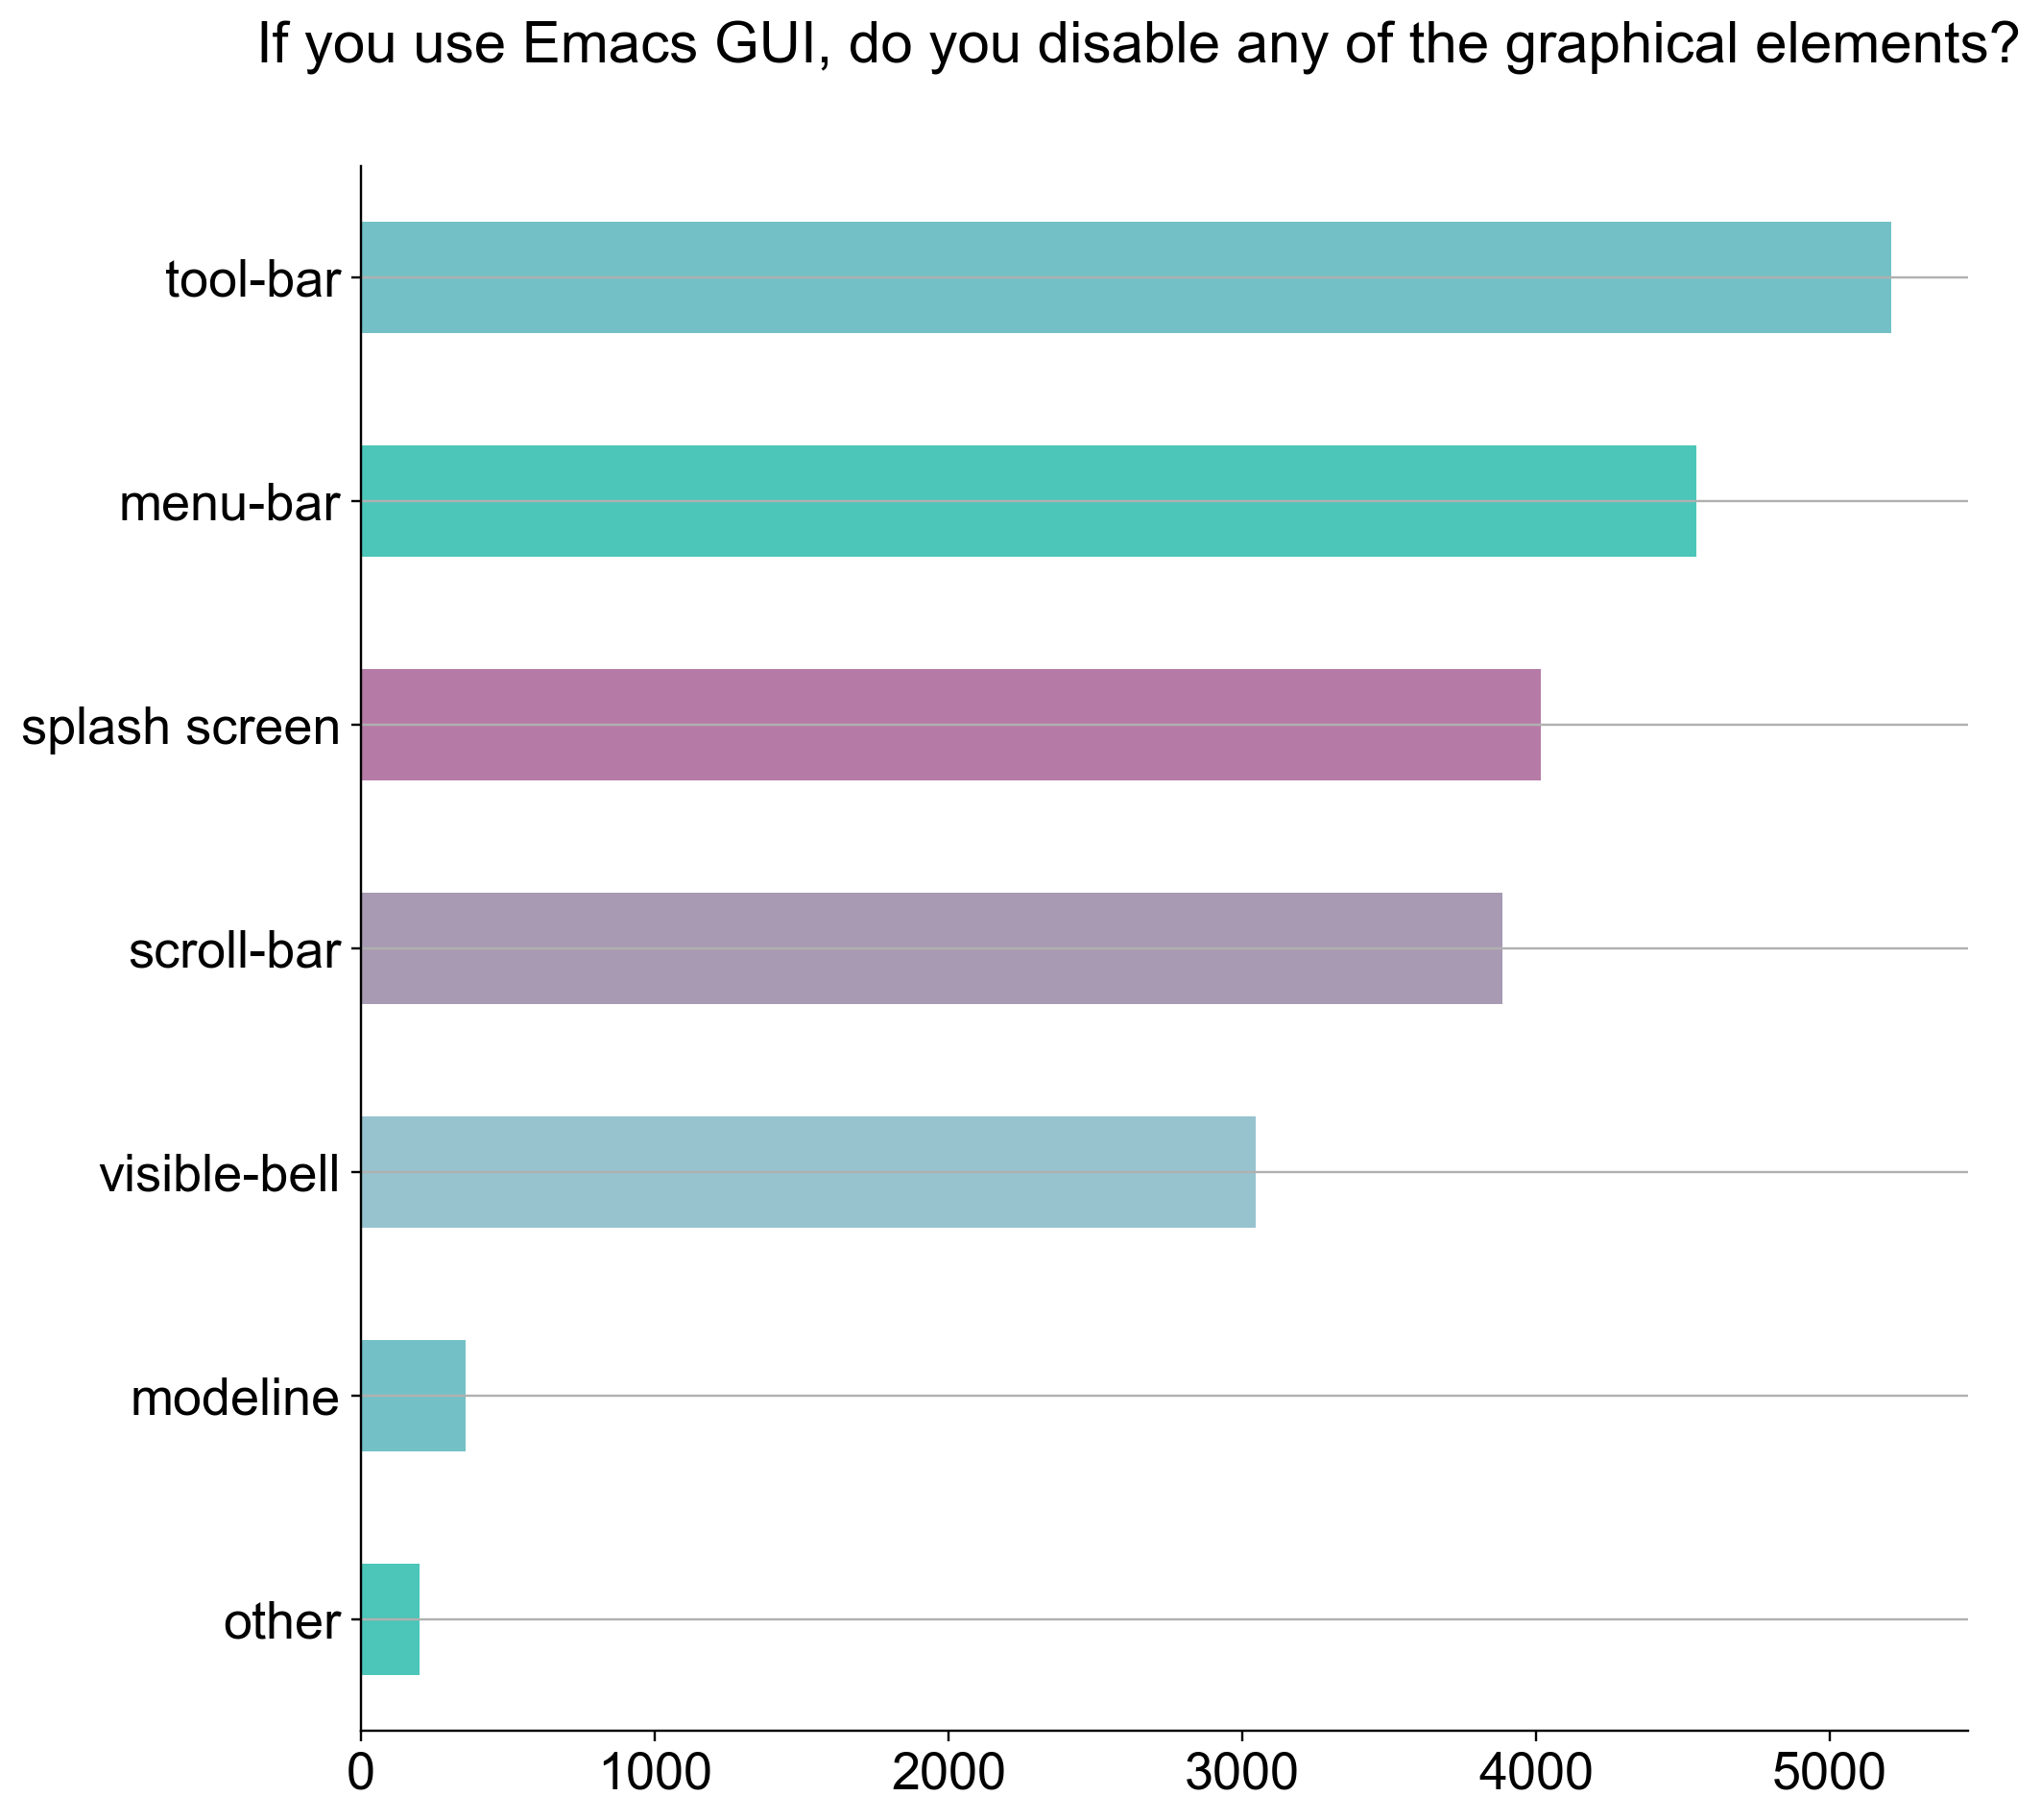

In [35]:
render('If you use Emacs GUI, do you disable any of the graphical elements?')

In [132]:
table('If you use Emacs GUI, do you disable any of the graphical elements?')

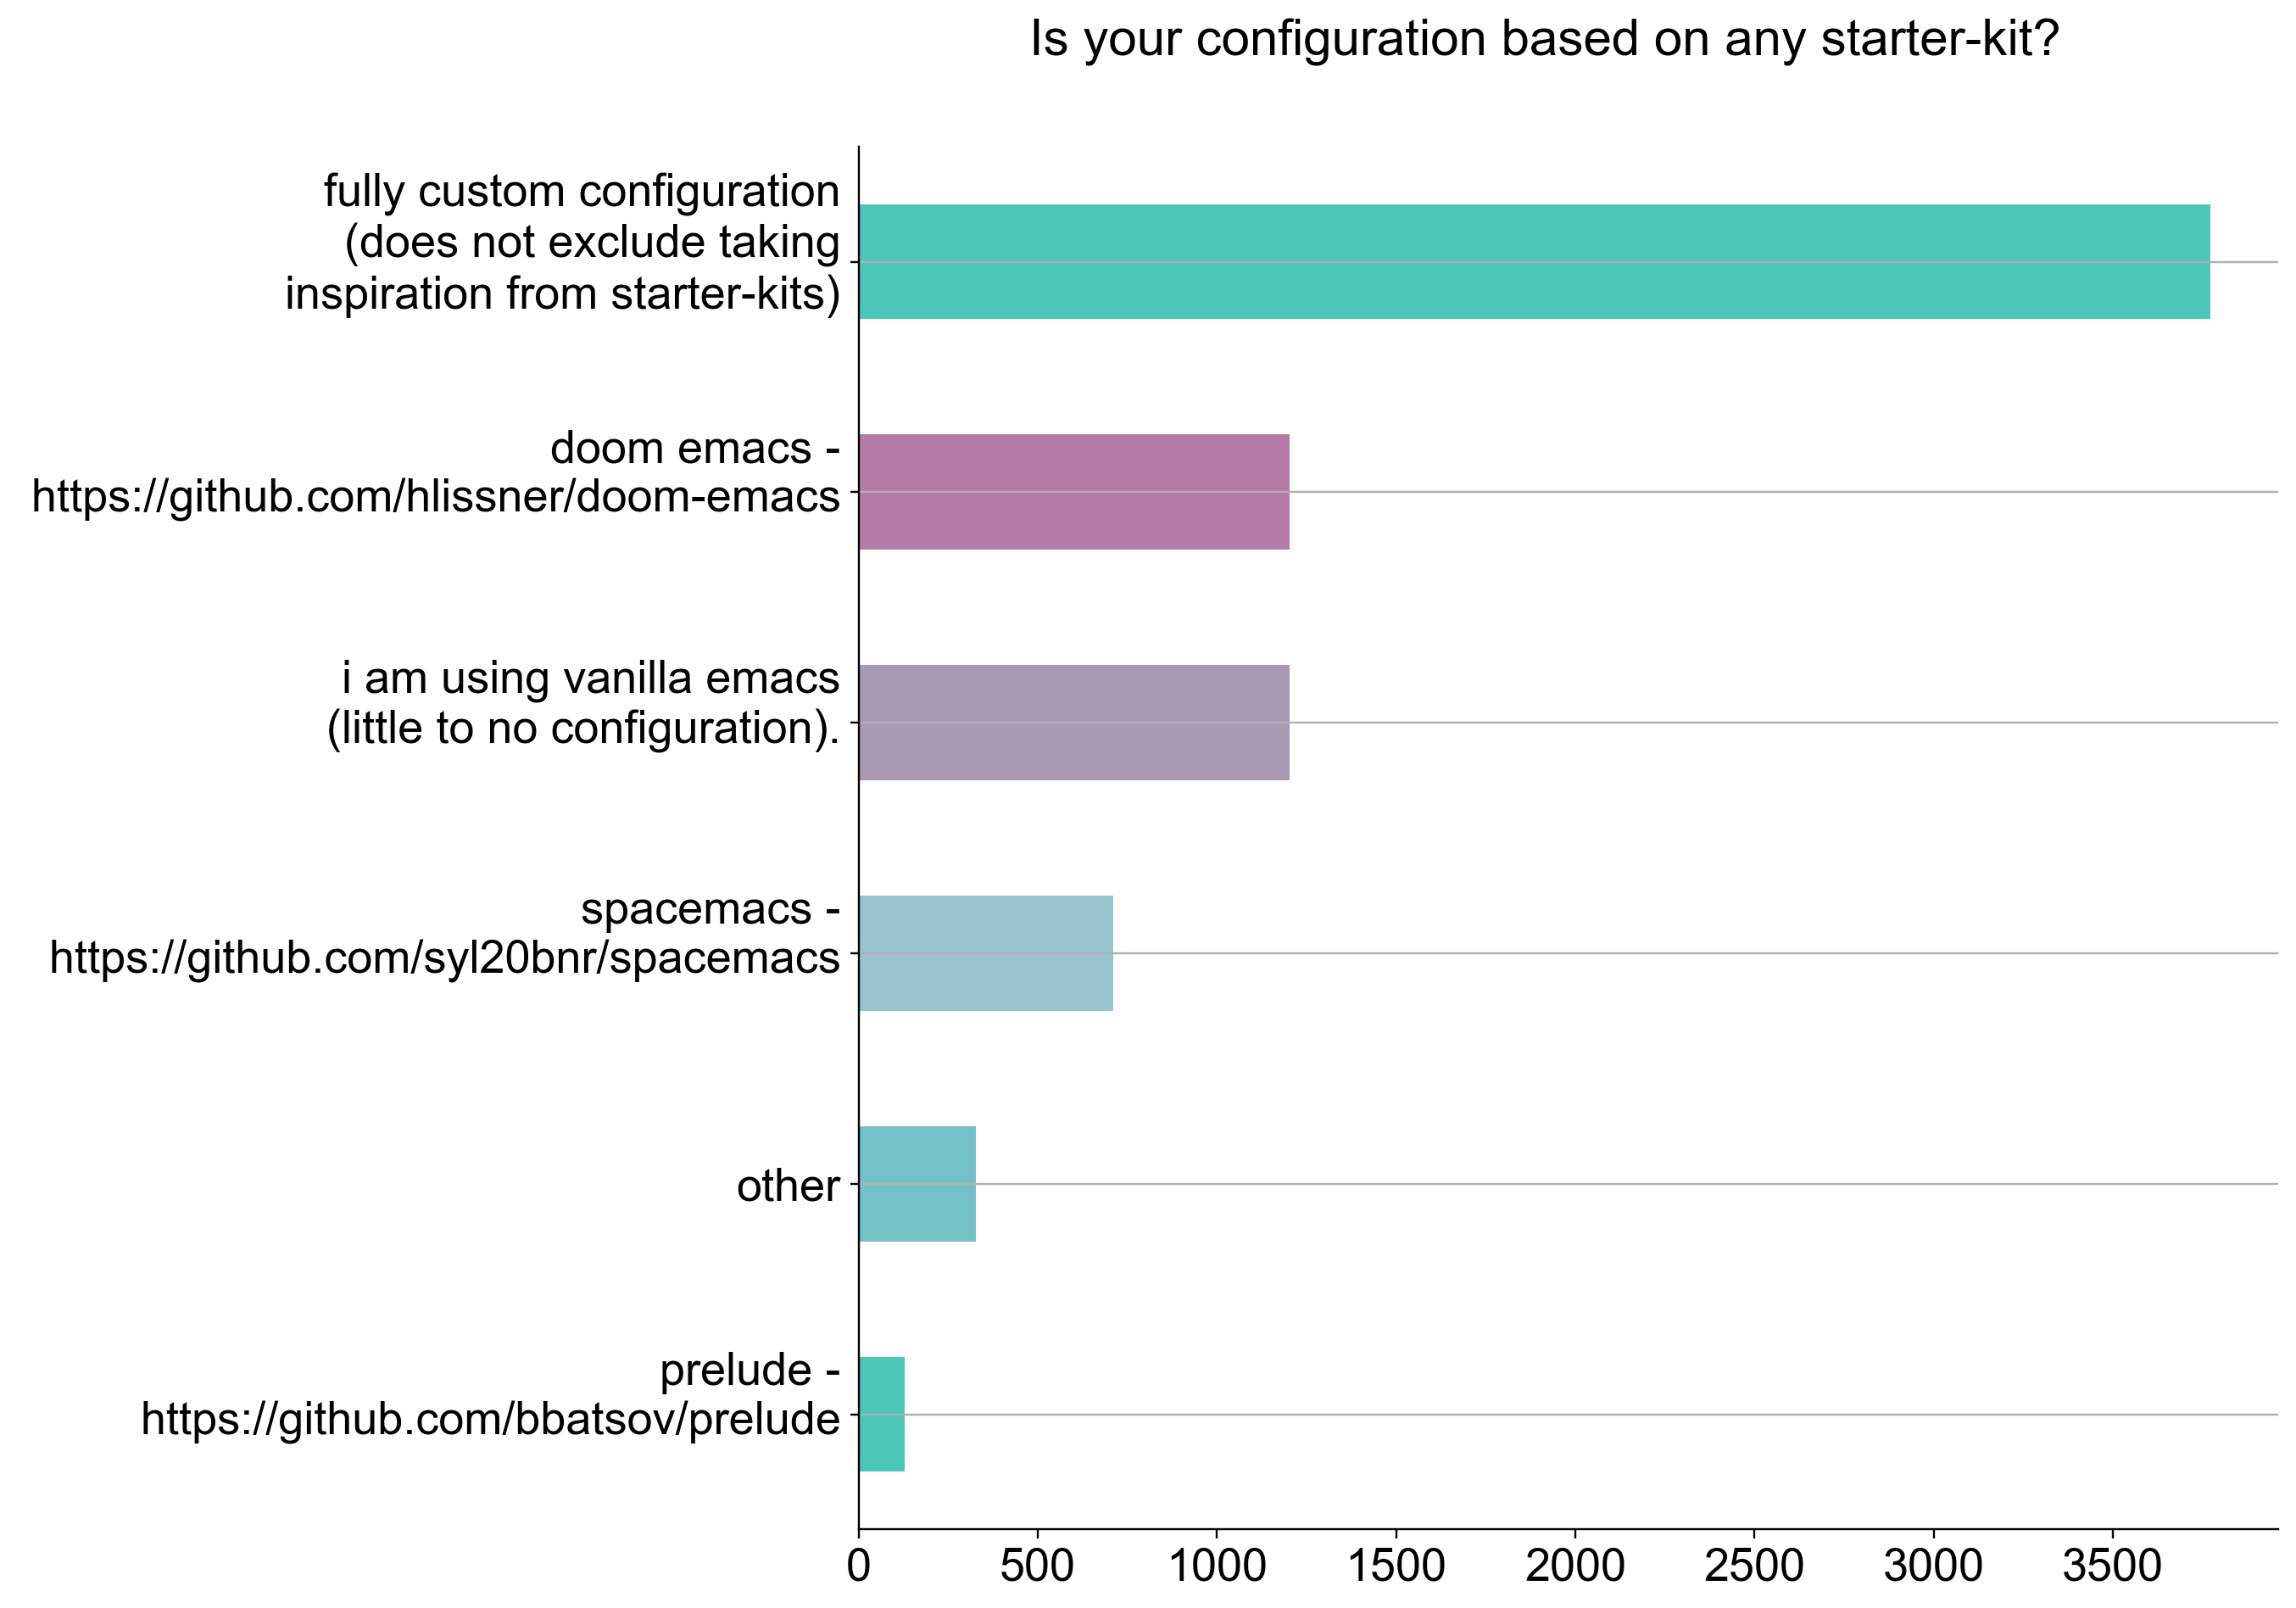

In [38]:
render('Is your configuration based on any starter-kit?')

In [133]:
table('Is your configuration based on any starter-kit?')

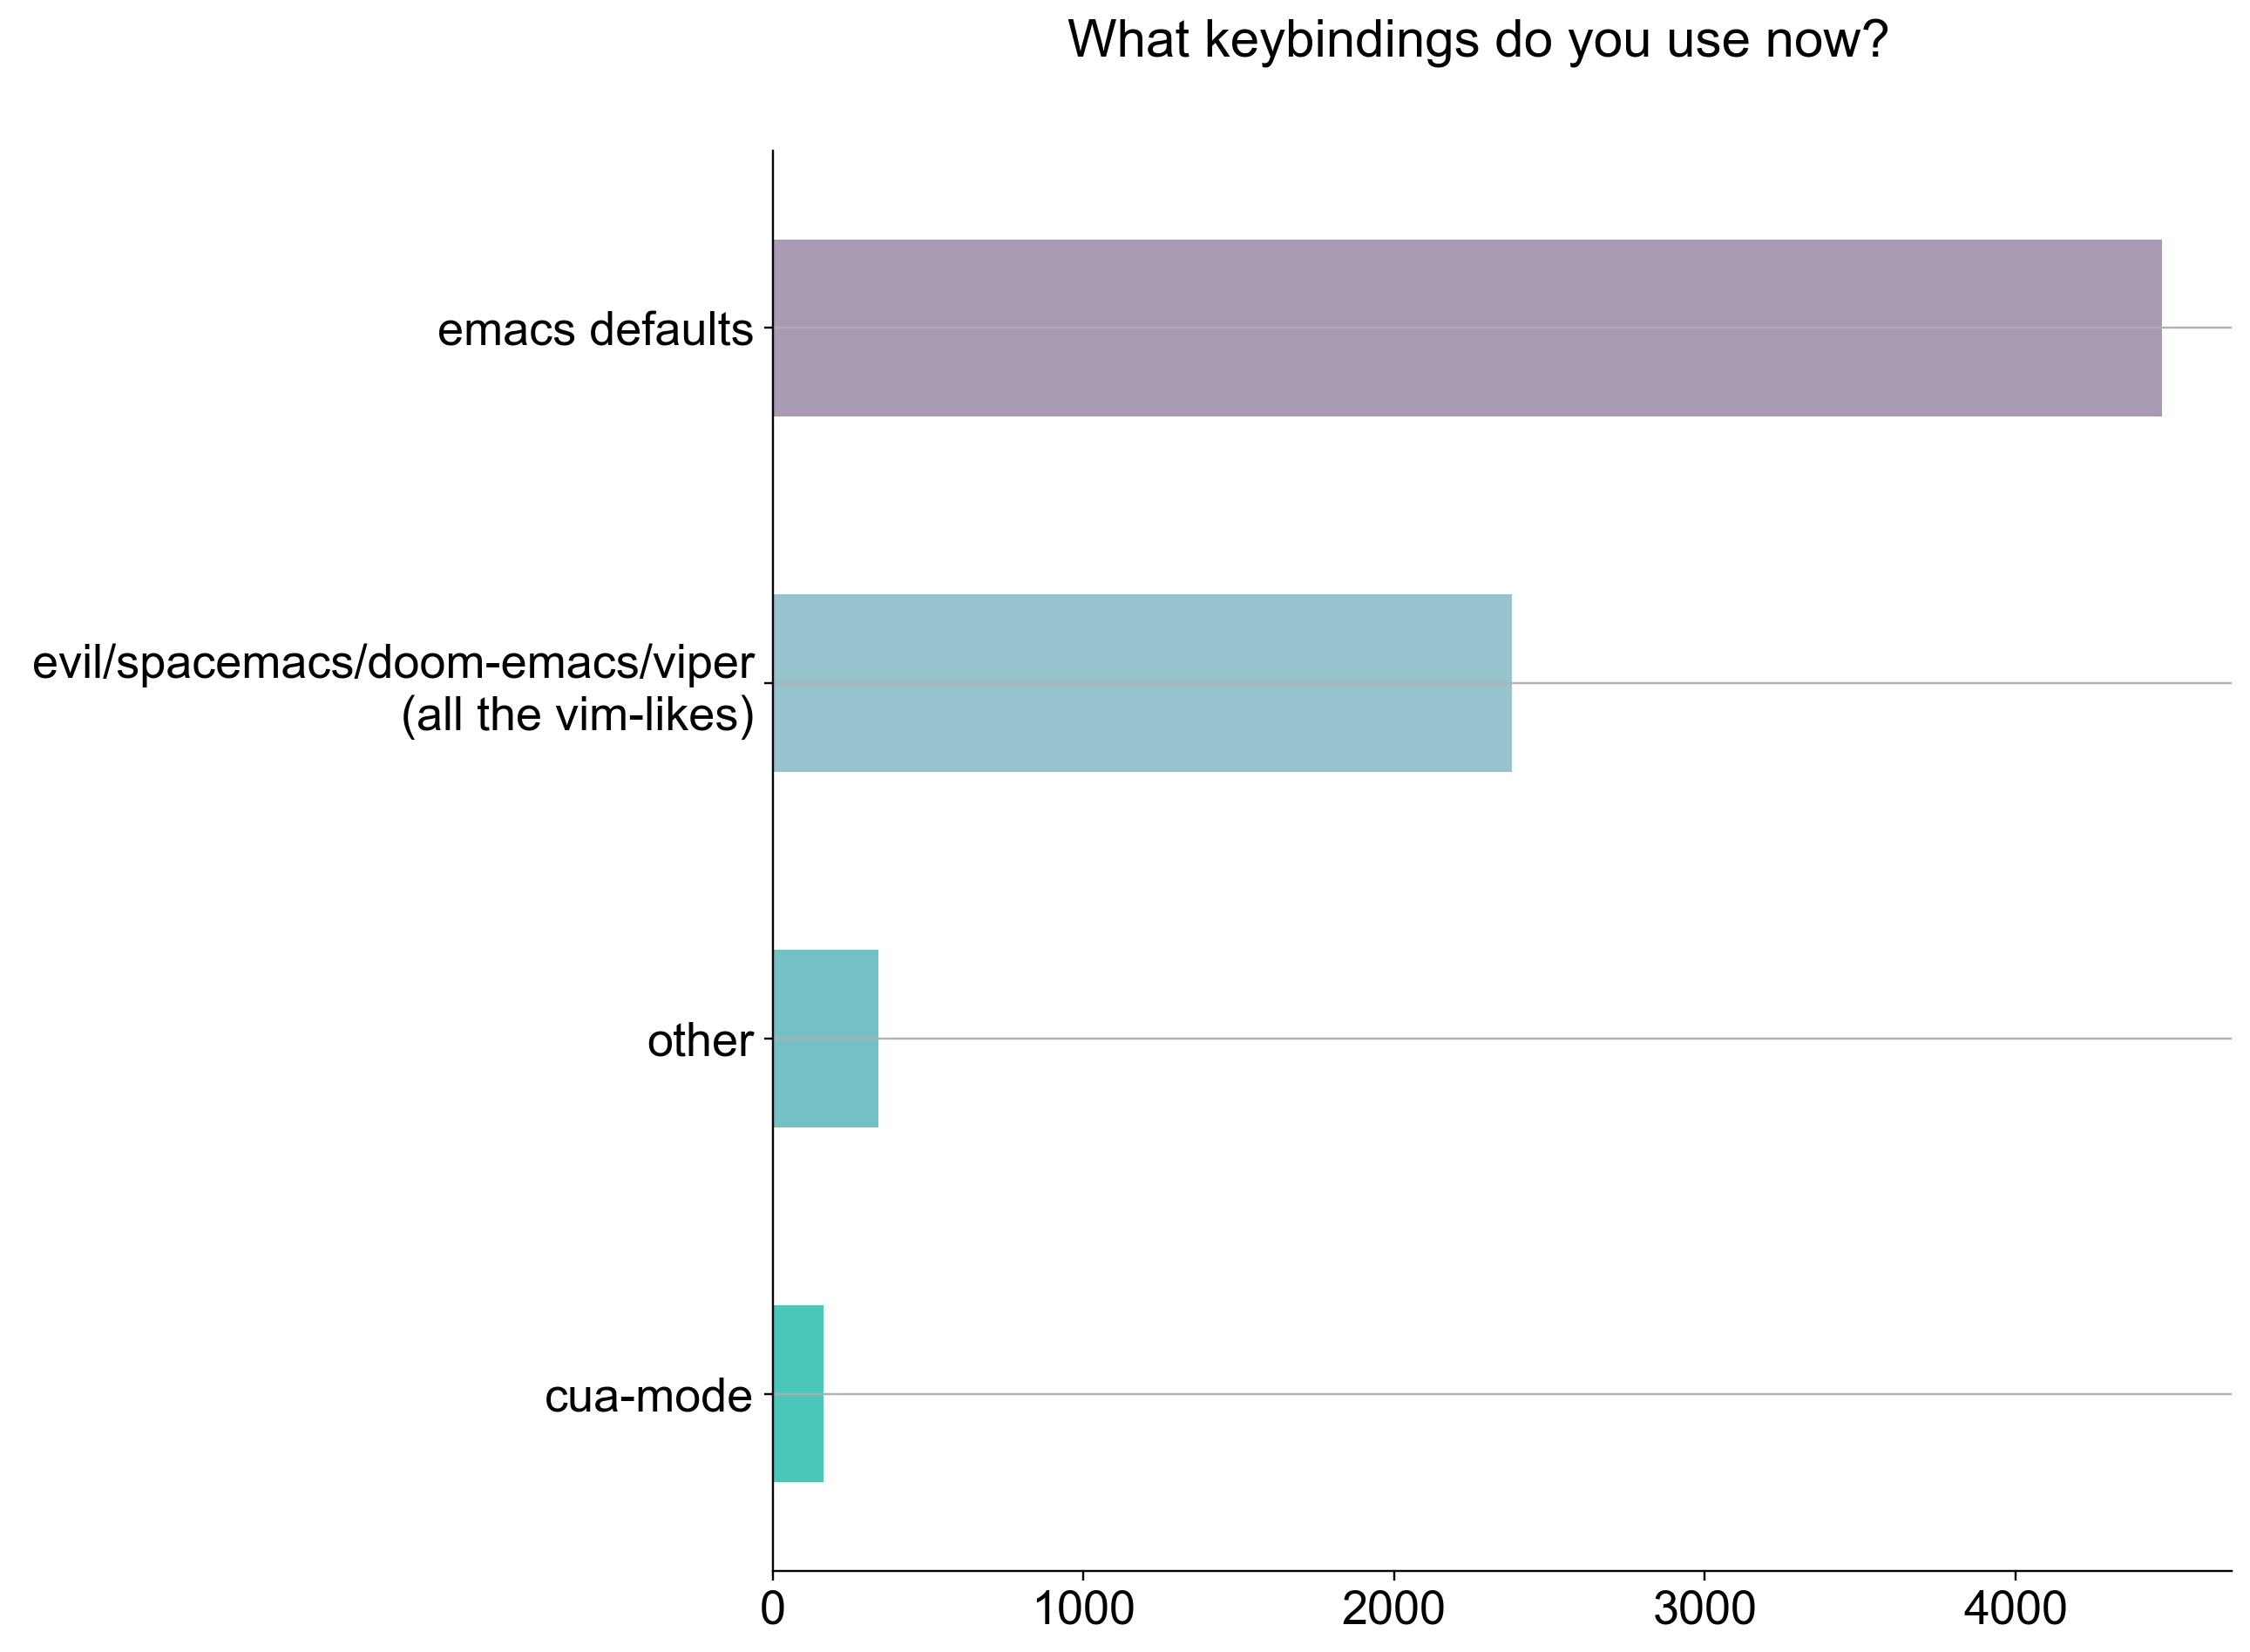

In [40]:
render('What keybindings do you use now?')

In [134]:
table('What keybindings do you use now?')

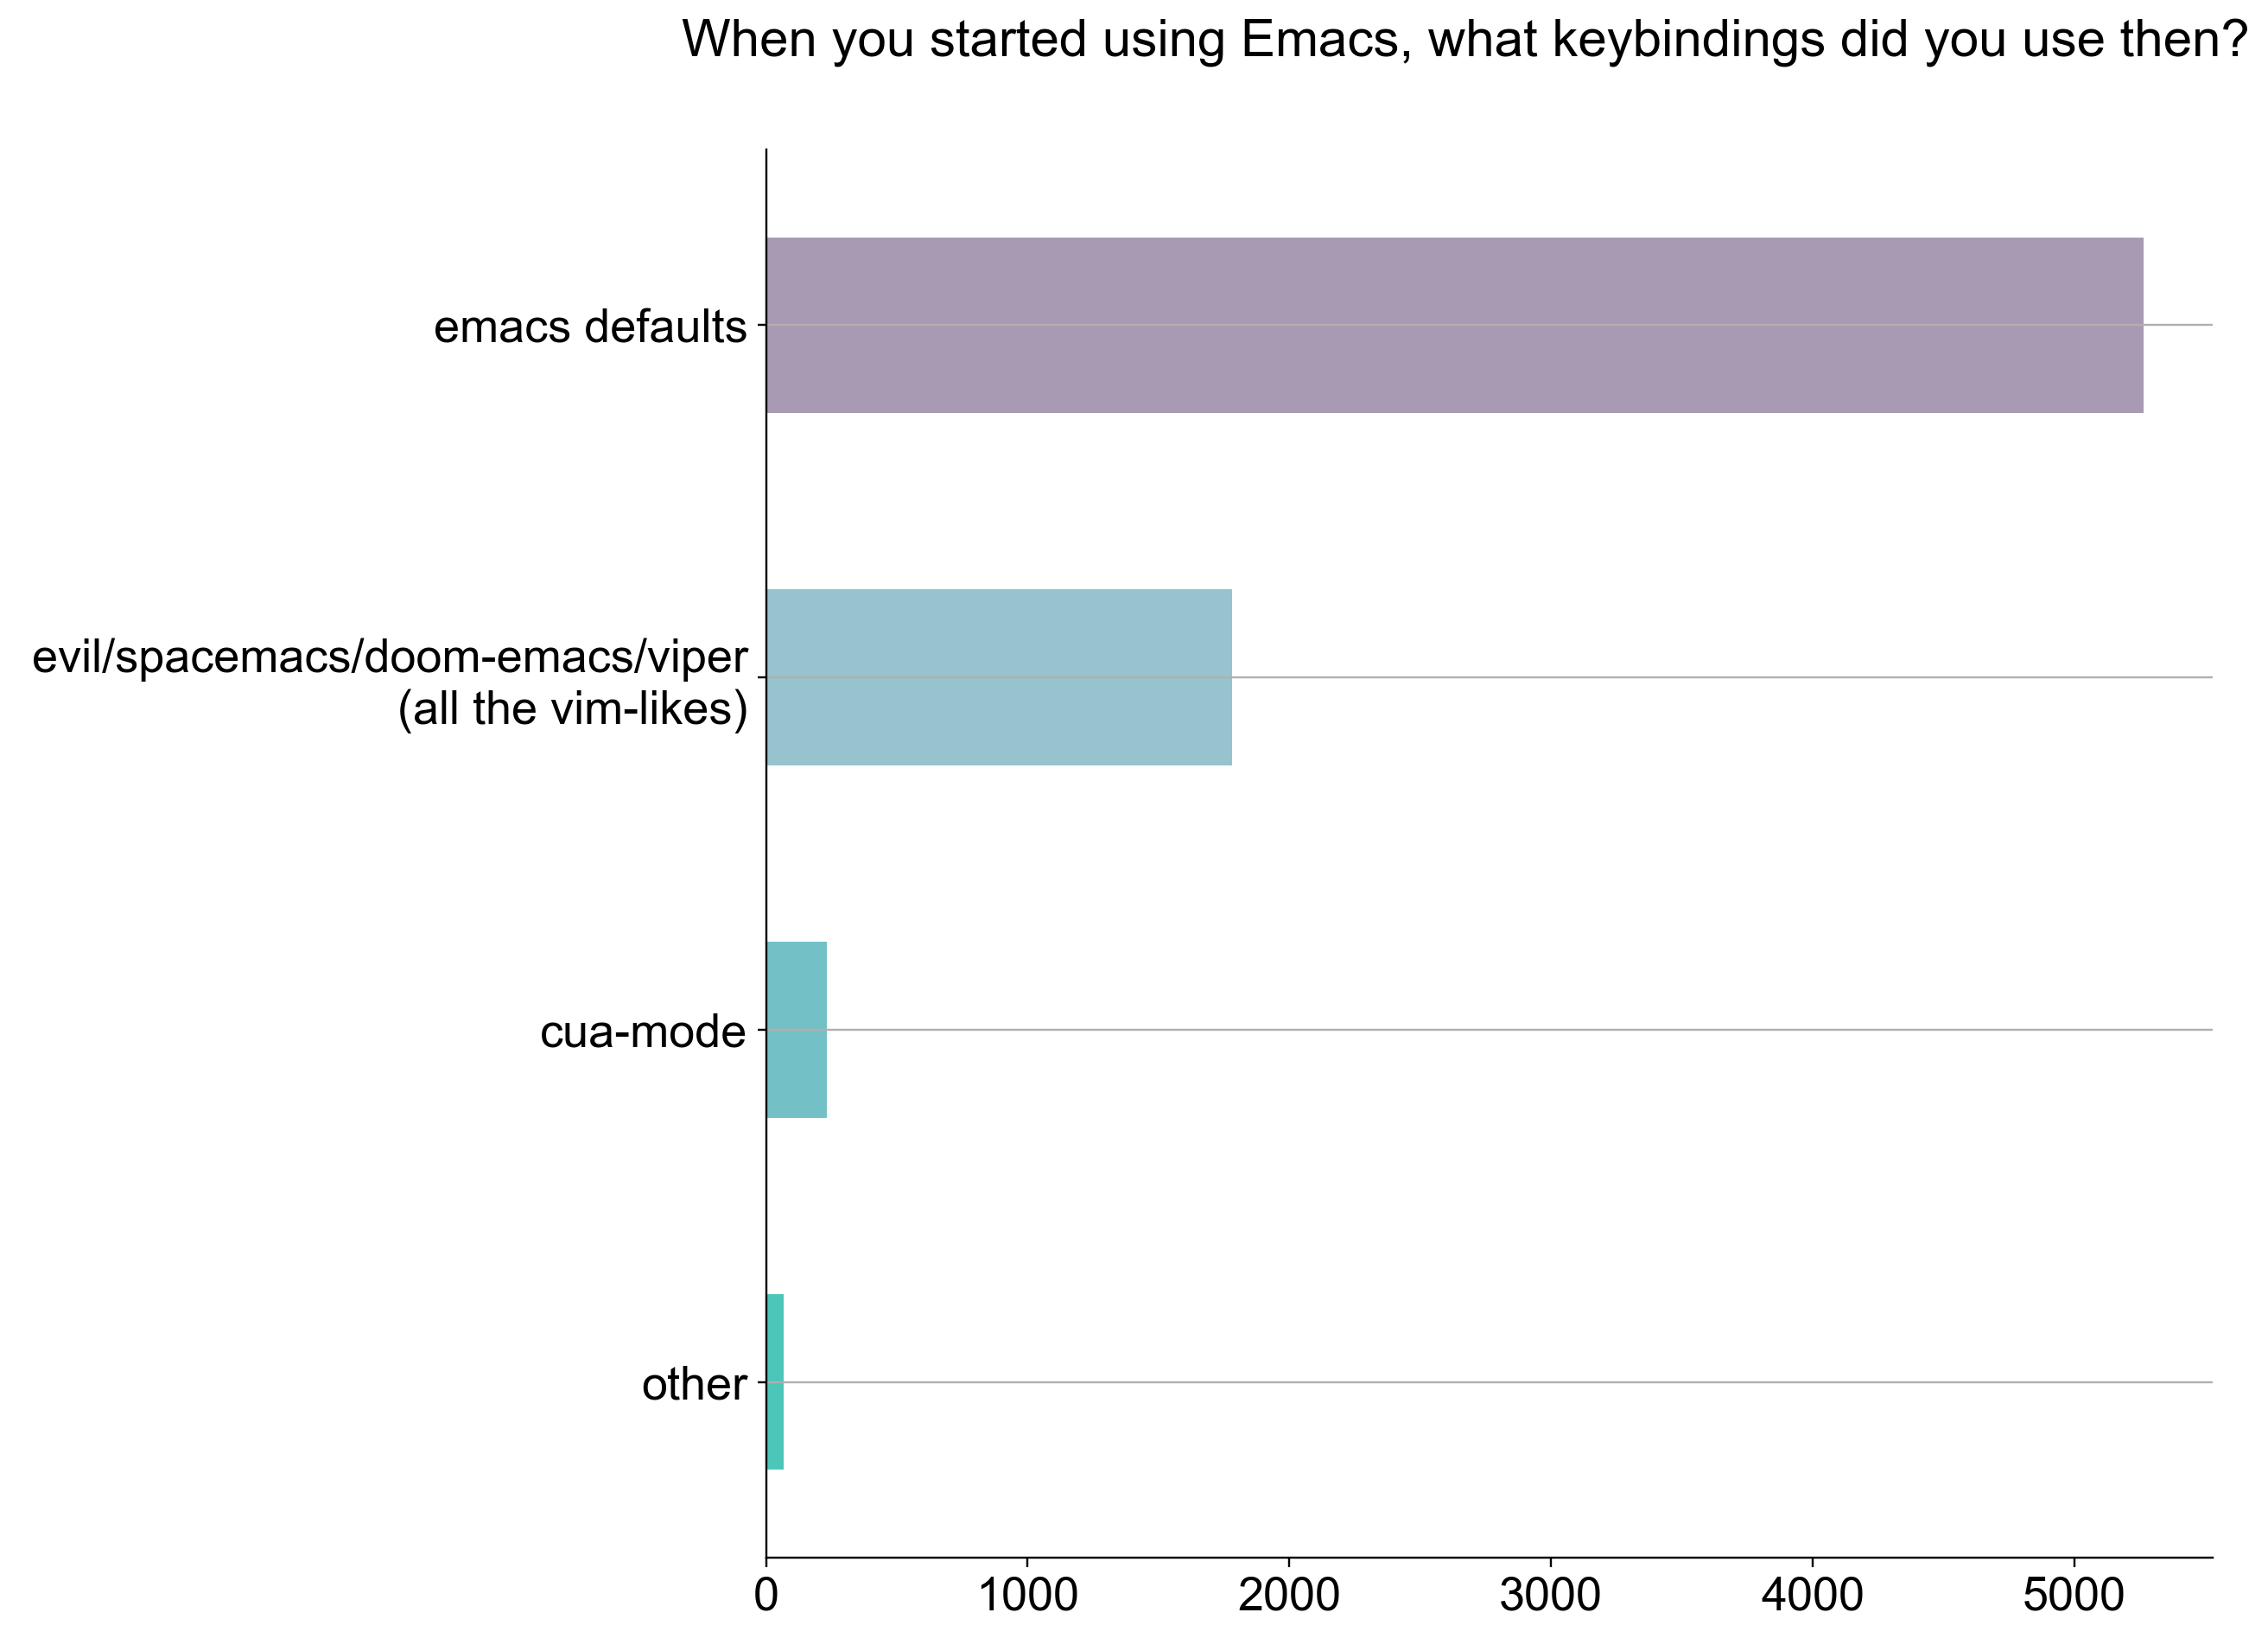

In [42]:
render('When you started using Emacs, what keybindings did you use then?')

In [135]:
table('When you started using Emacs, what keybindings did you use then?')

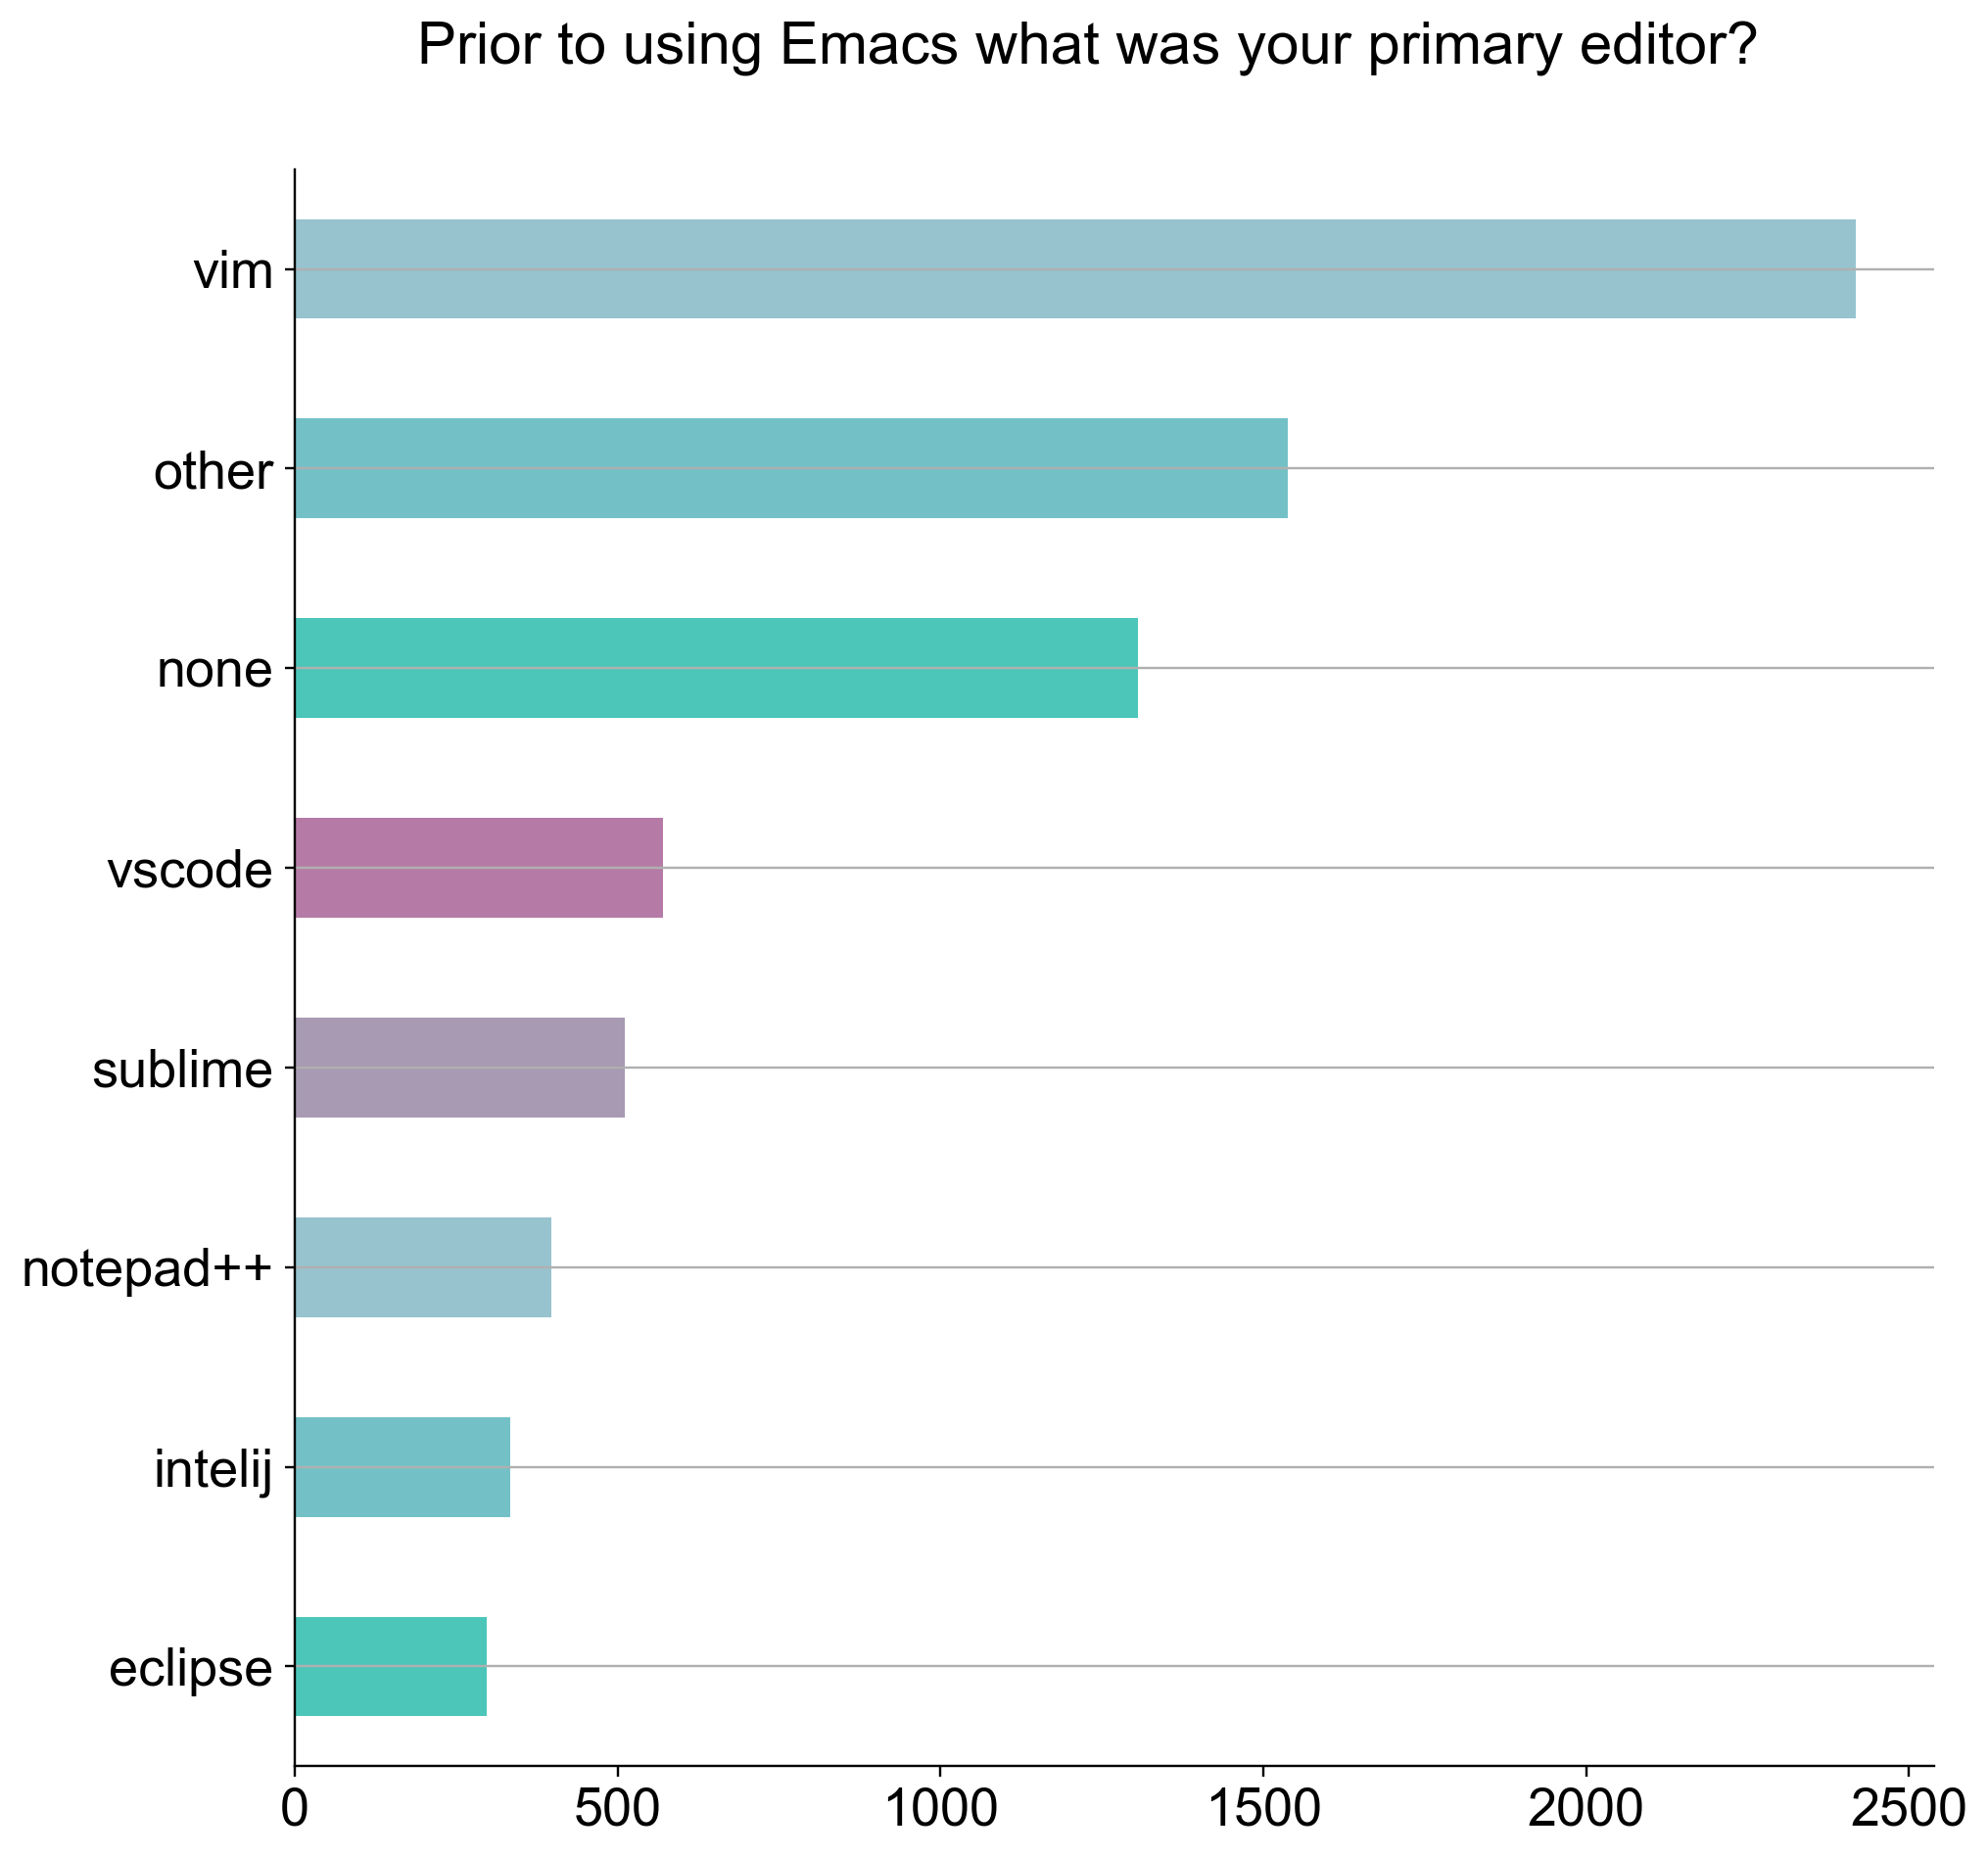

In [45]:
render('Prior to using Emacs what was your primary editor?')

In [136]:
table('Prior to using Emacs what was your primary editor?')

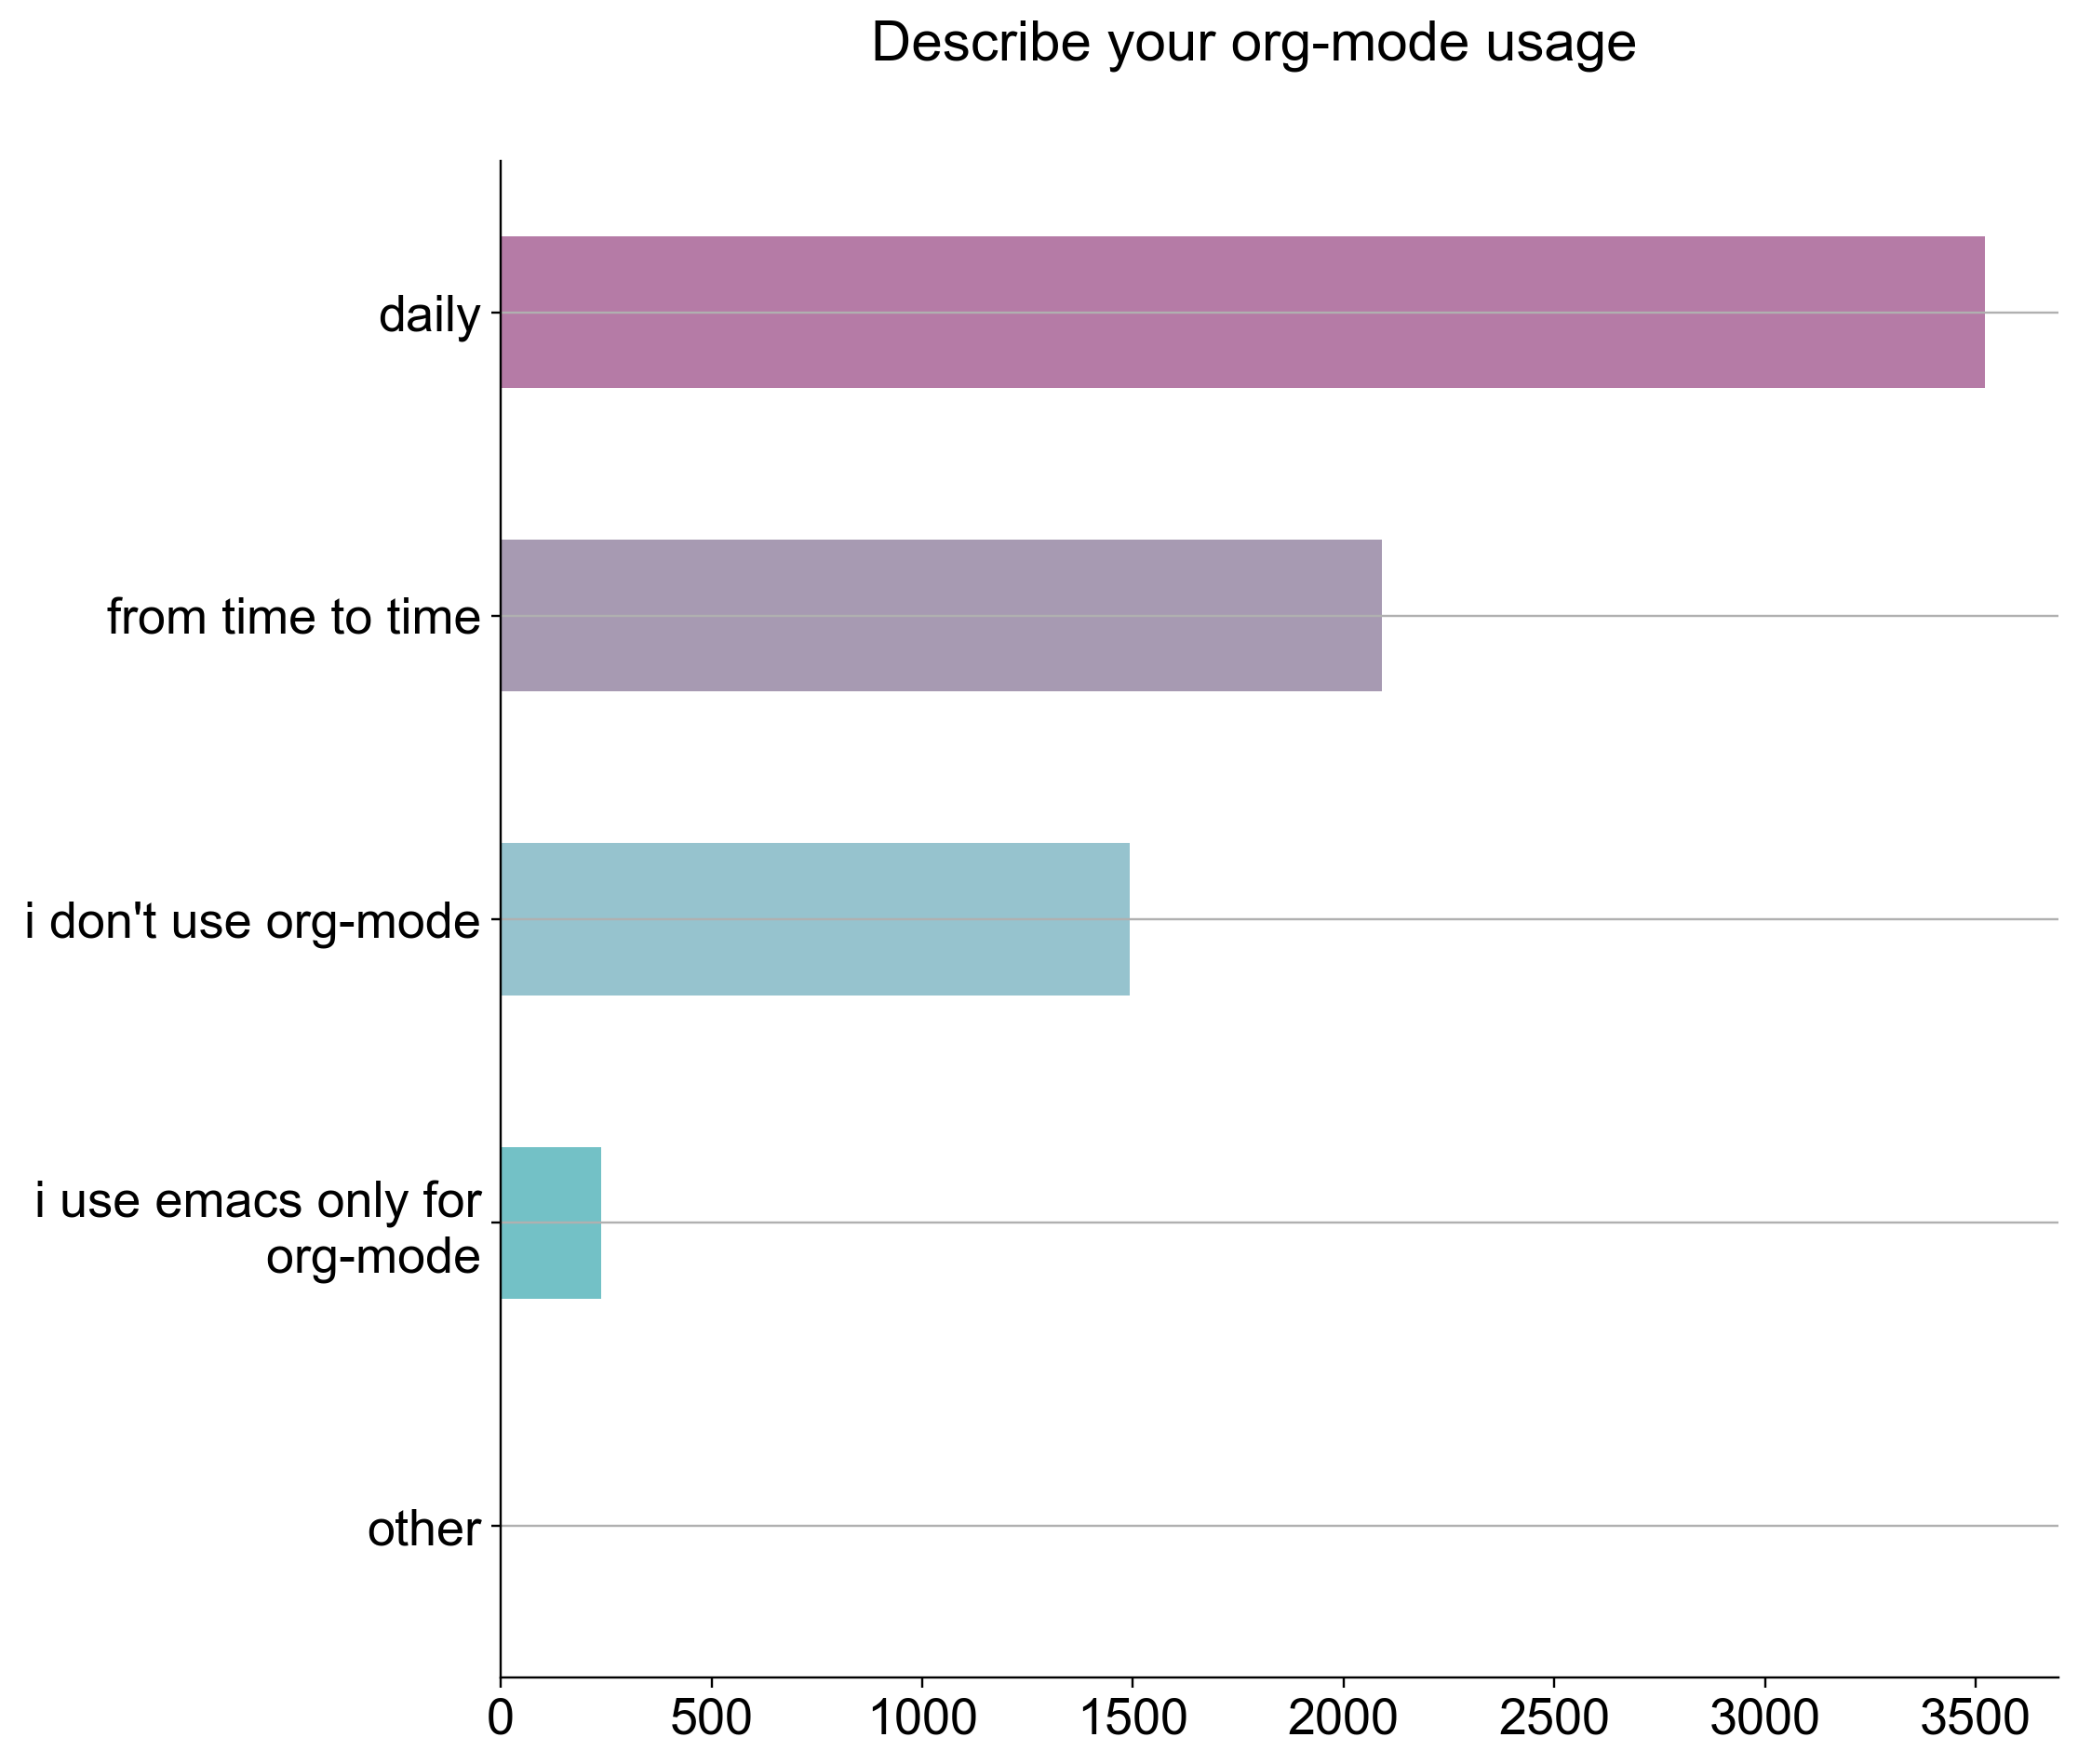

In [47]:
render('Describe your org-mode usage')

In [137]:
table('Describe your org-mode usage')

In [138]:
table('If you use org-mode, for what purpose?')

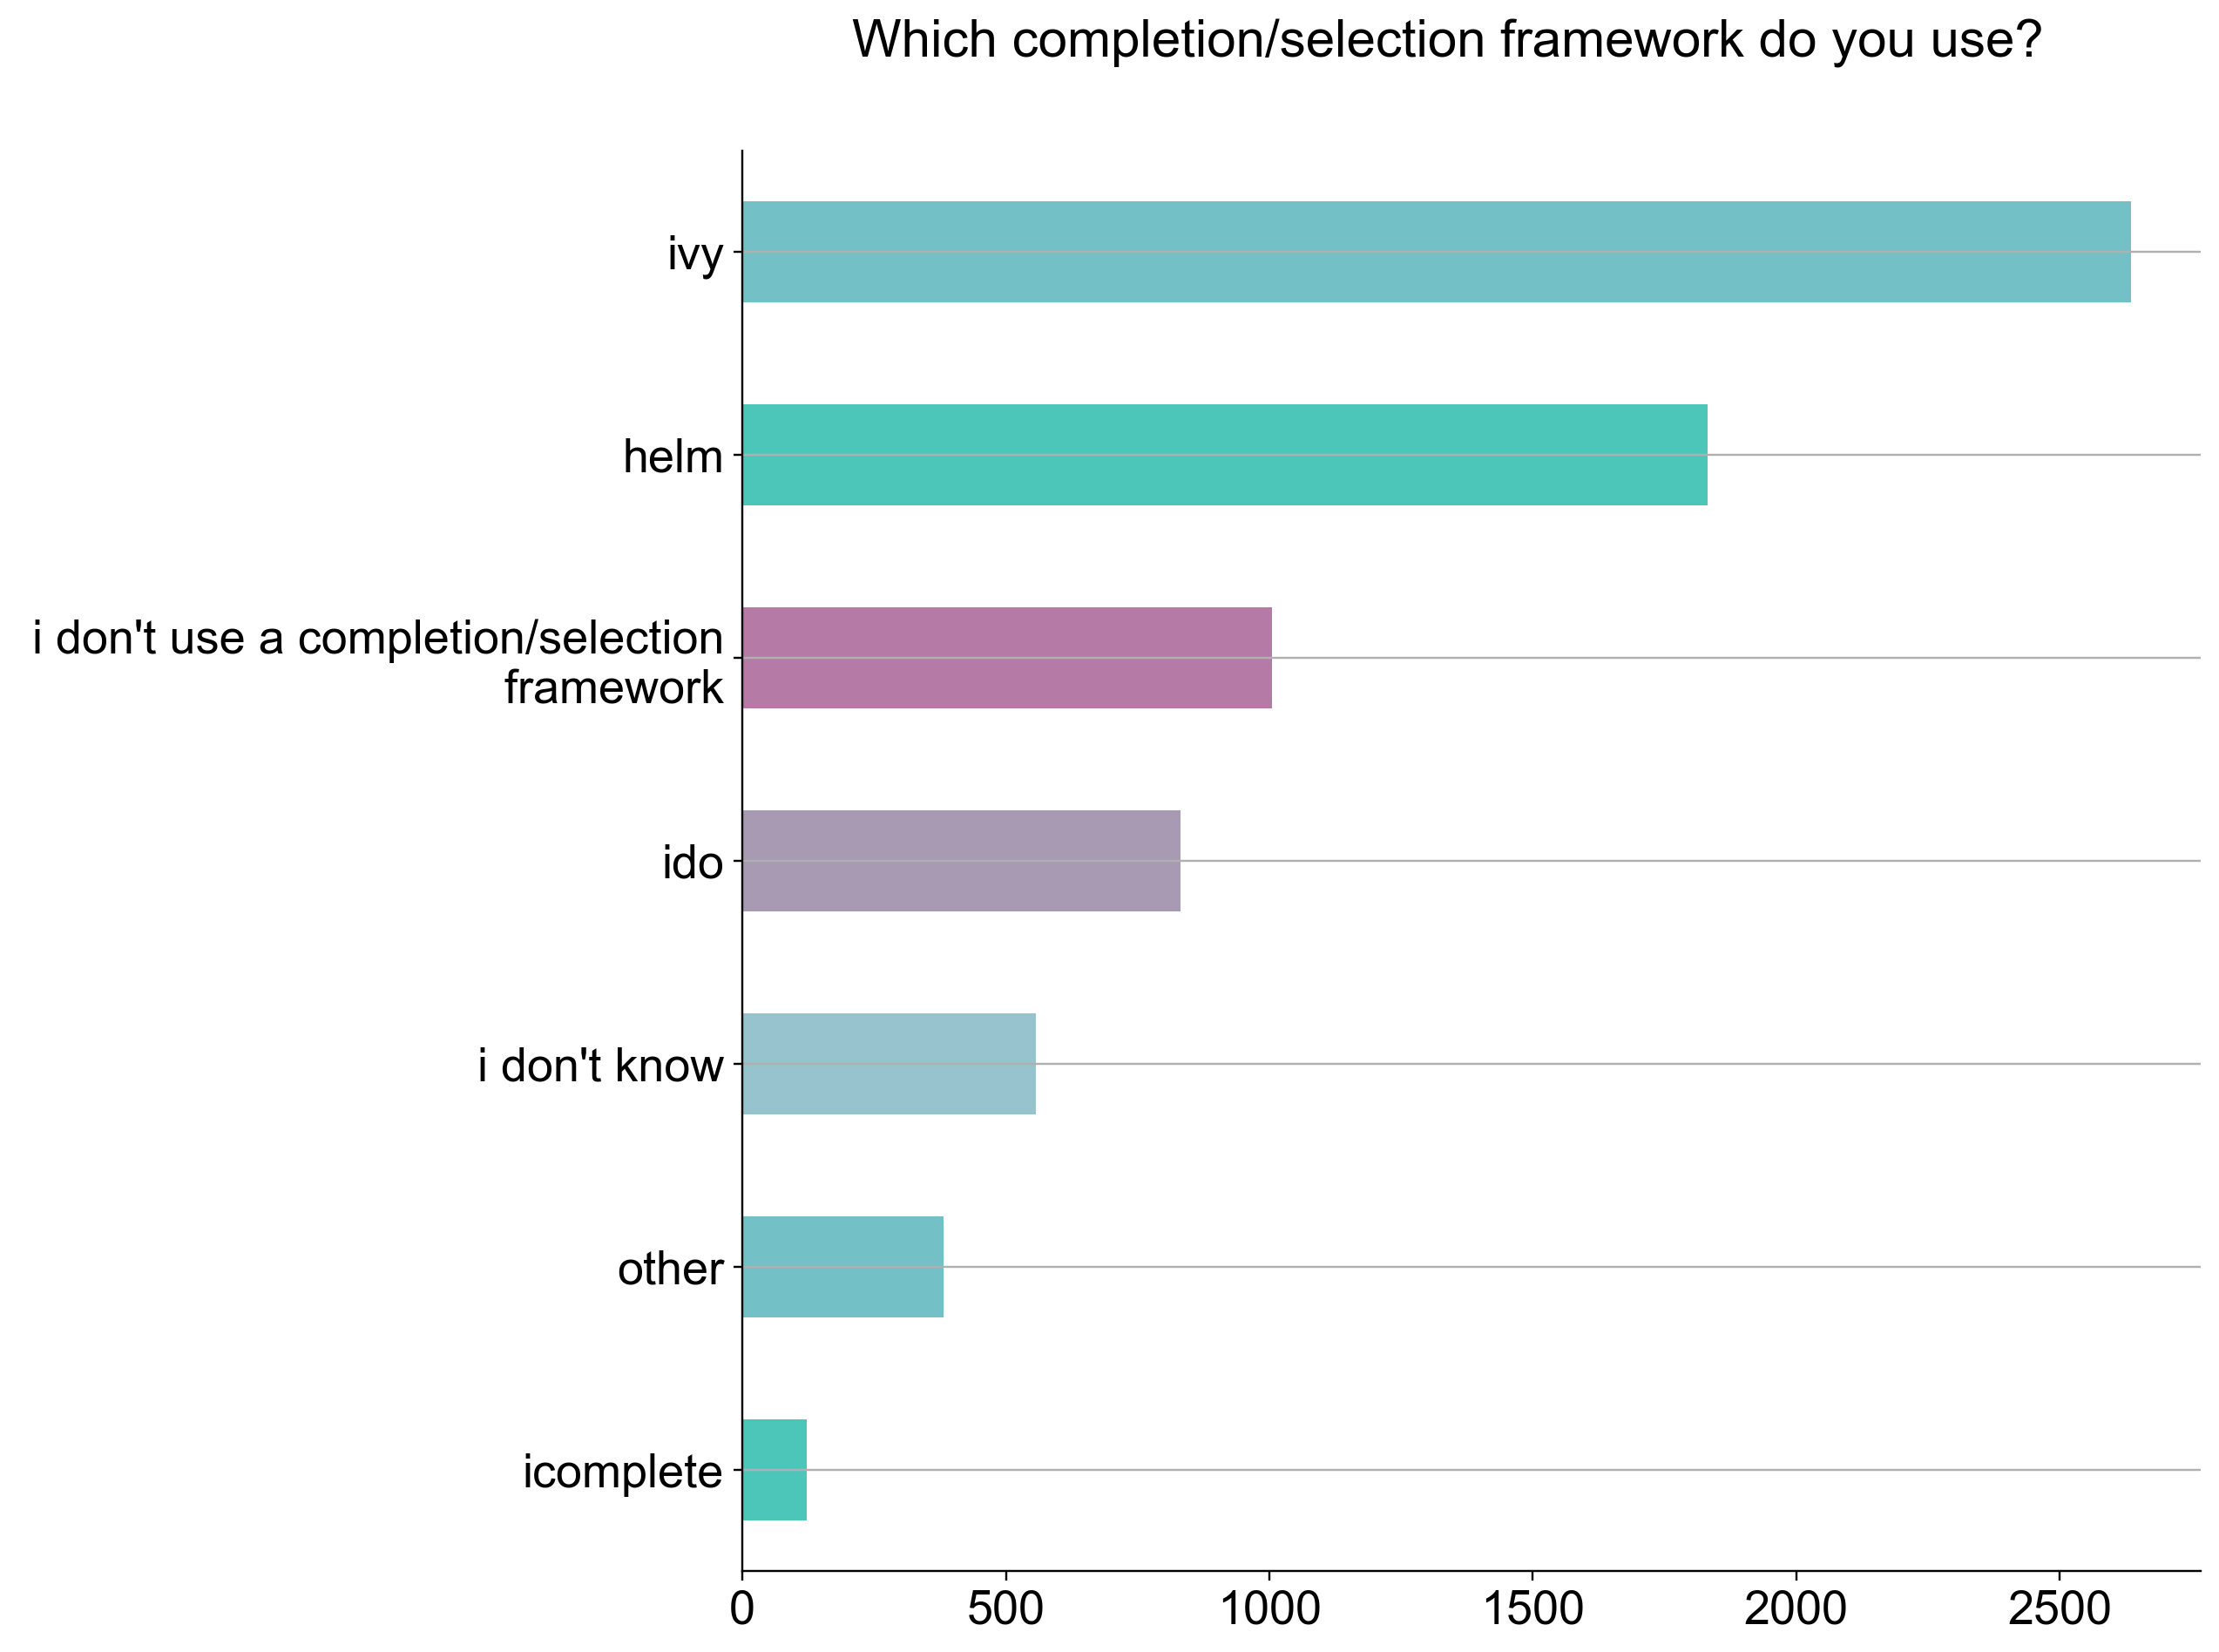

In [49]:
render('Which completion/selection framework do you use?')

In [139]:
table('Which completion/selection framework do you use?')

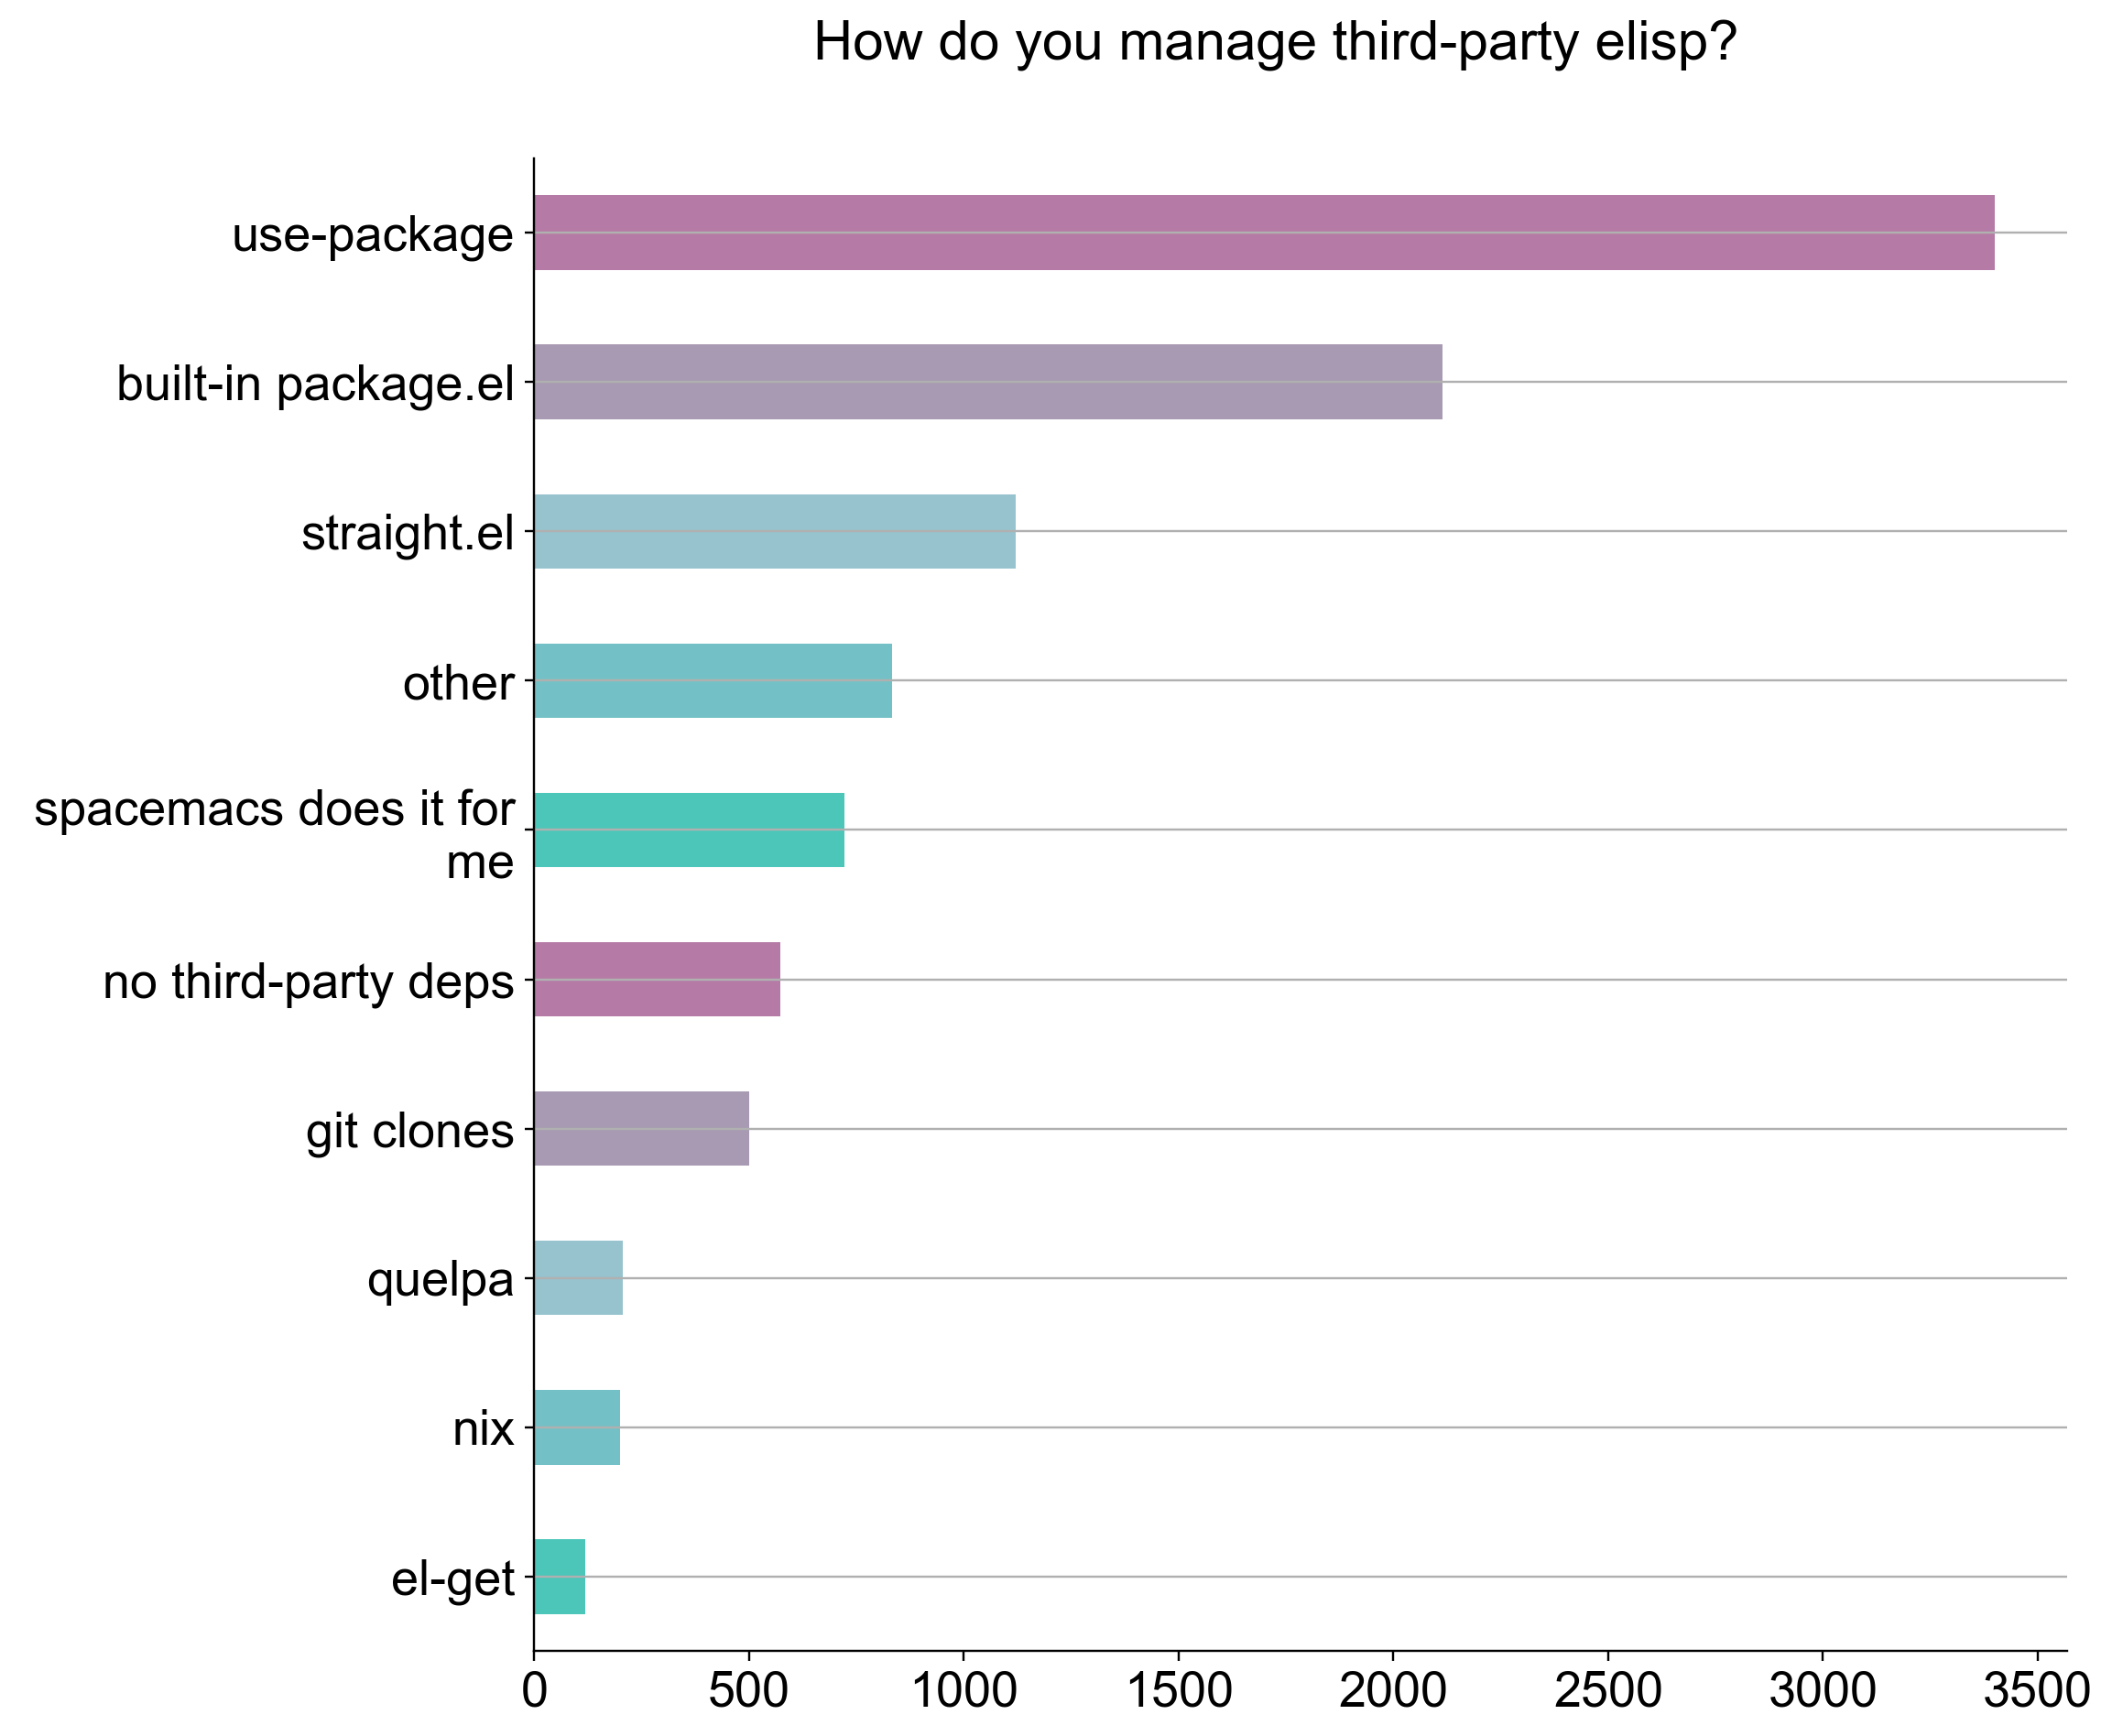

In [51]:
render('How do you manage third-party elisp?')

In [140]:
table('How do you manage third-party elisp?')

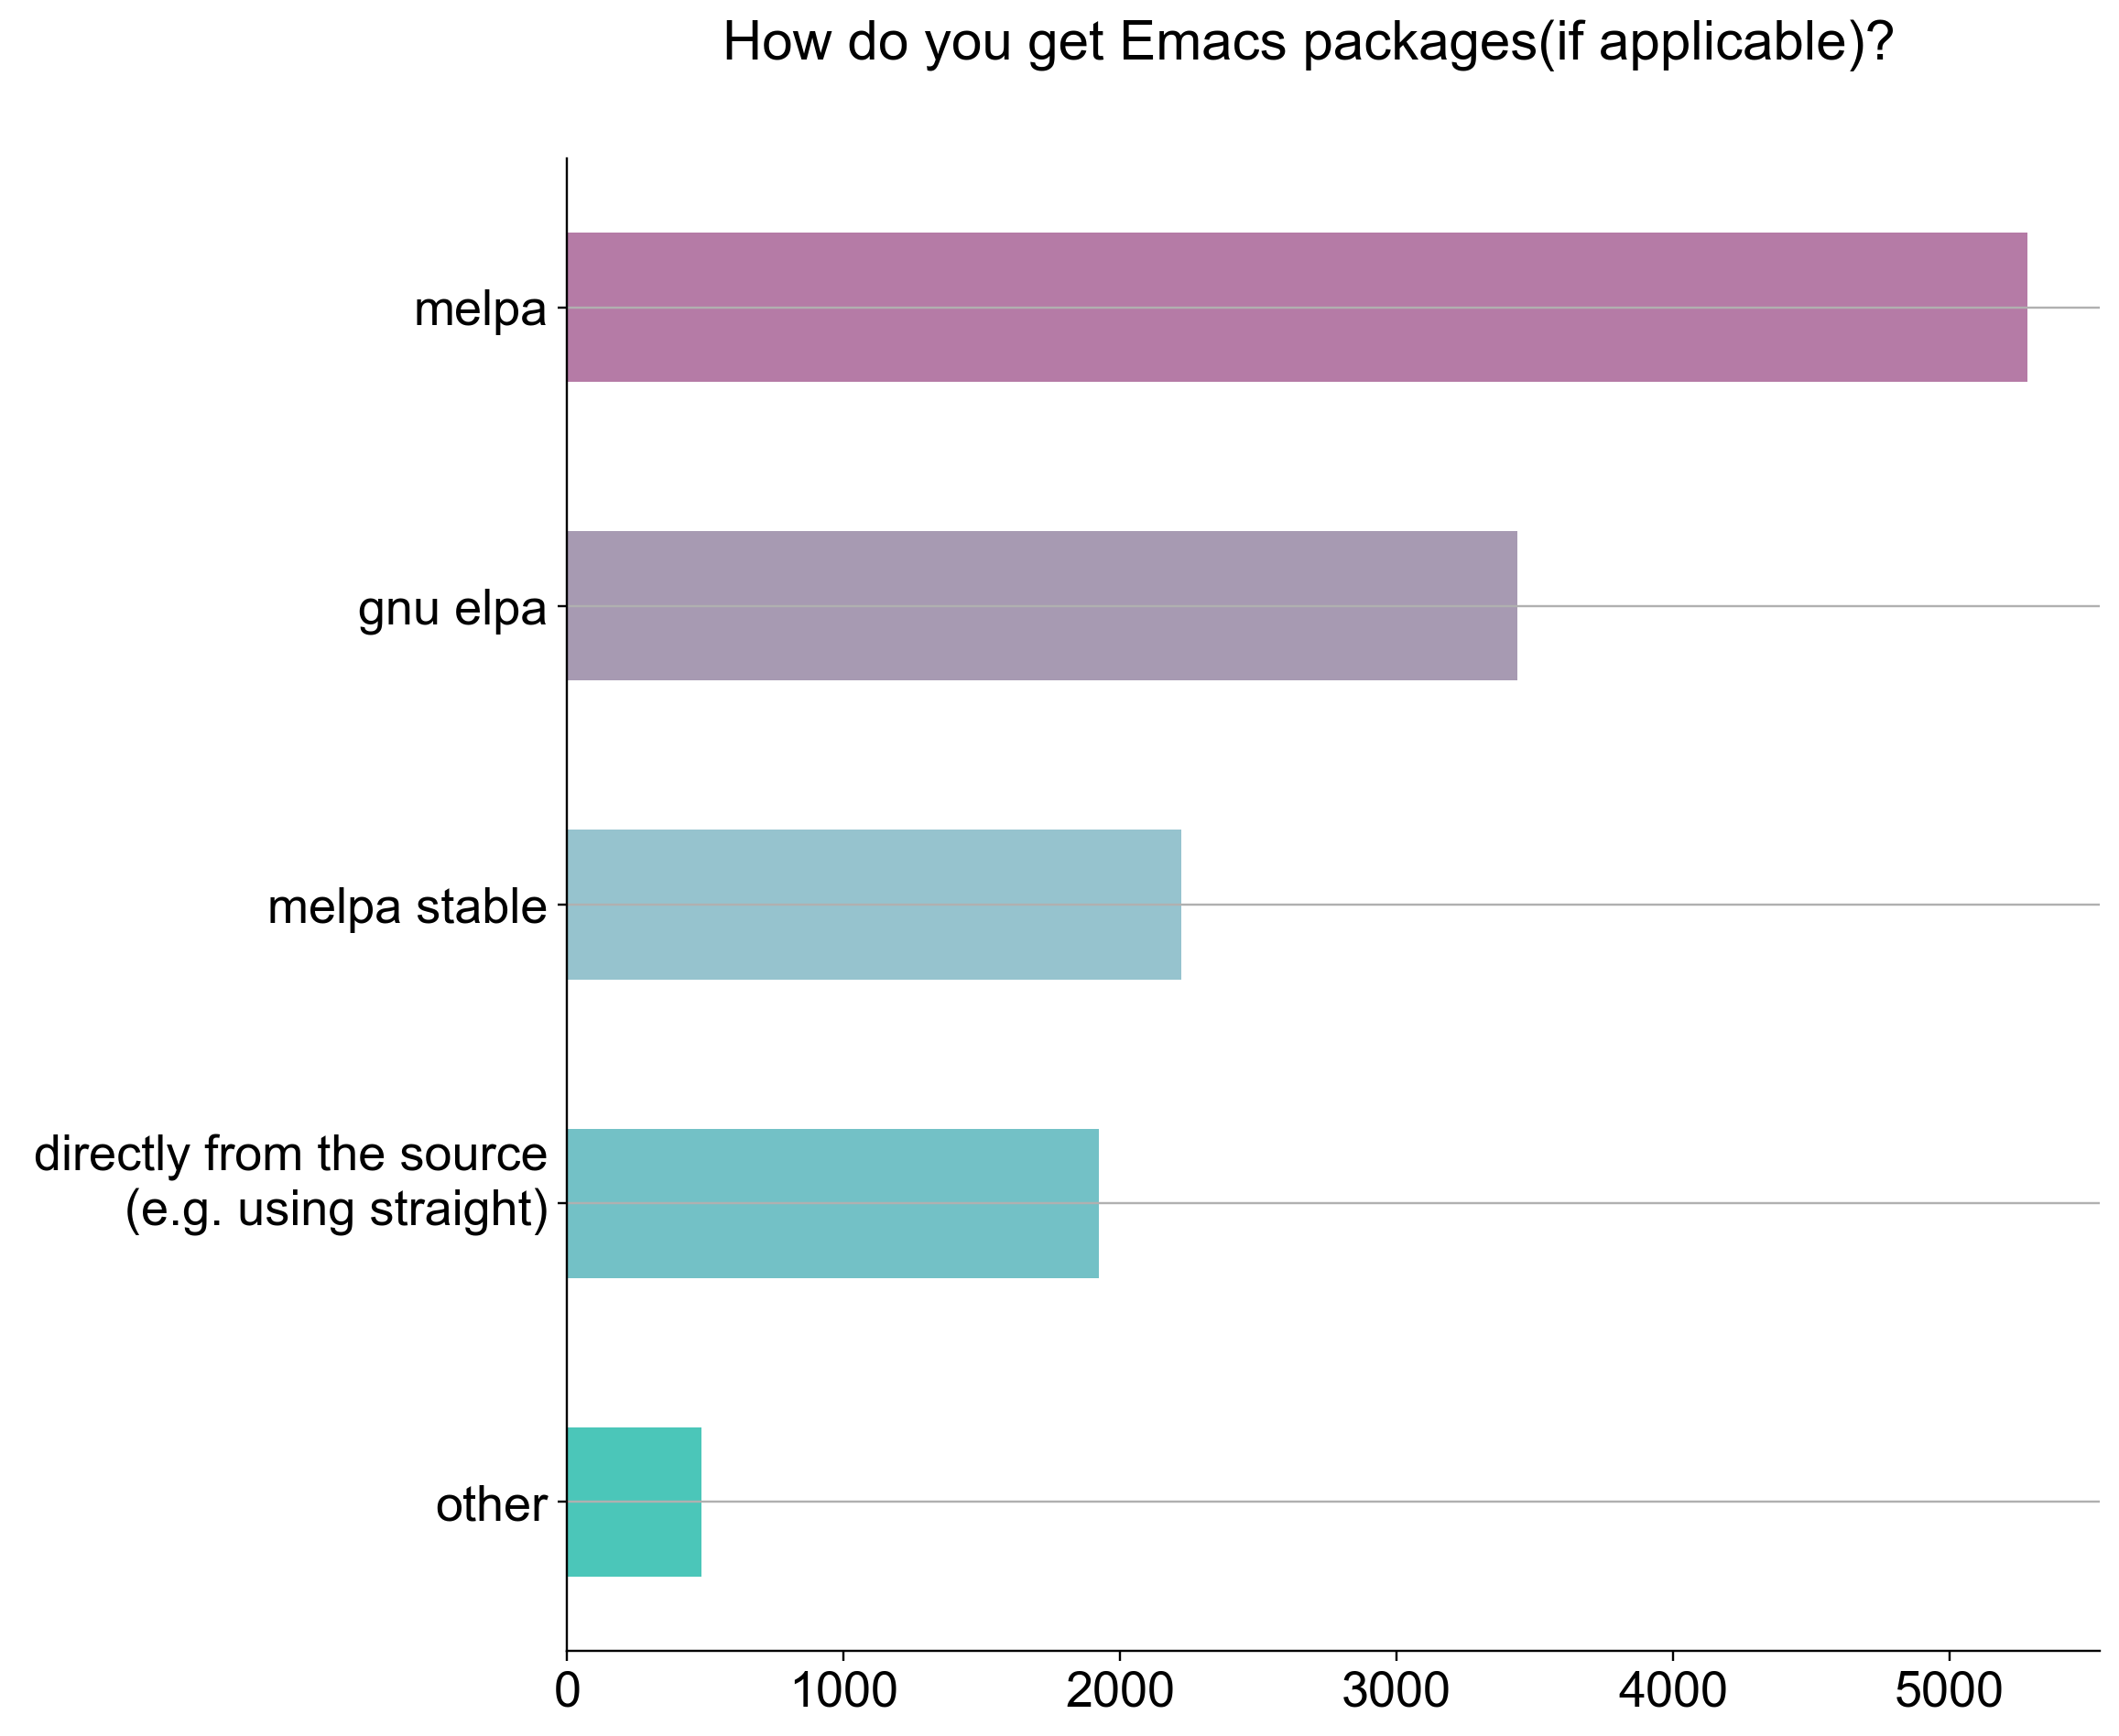

In [53]:
render('How do you get Emacs packages(if applicable)?')

In [141]:
table('How do you get Emacs packages(if applicable)?')

   Can you list some of your favorite packages?  total
19                                        other  20323
1                                         magit   2685
10                                   projectile    868
4                                      org-mode    734
3                                           ivy    604
6                                          helm    588
8                                       company    555
5                                          evil    554
9                                      lsp-mode    544
13                                     flycheck    368
15                                        cider    339
17                                          lsp    329
7                                     which-key    313
16                                     org-roam    302
11                                       auctex    299
18                                         mu4e    266
12                                    yasnippet    251


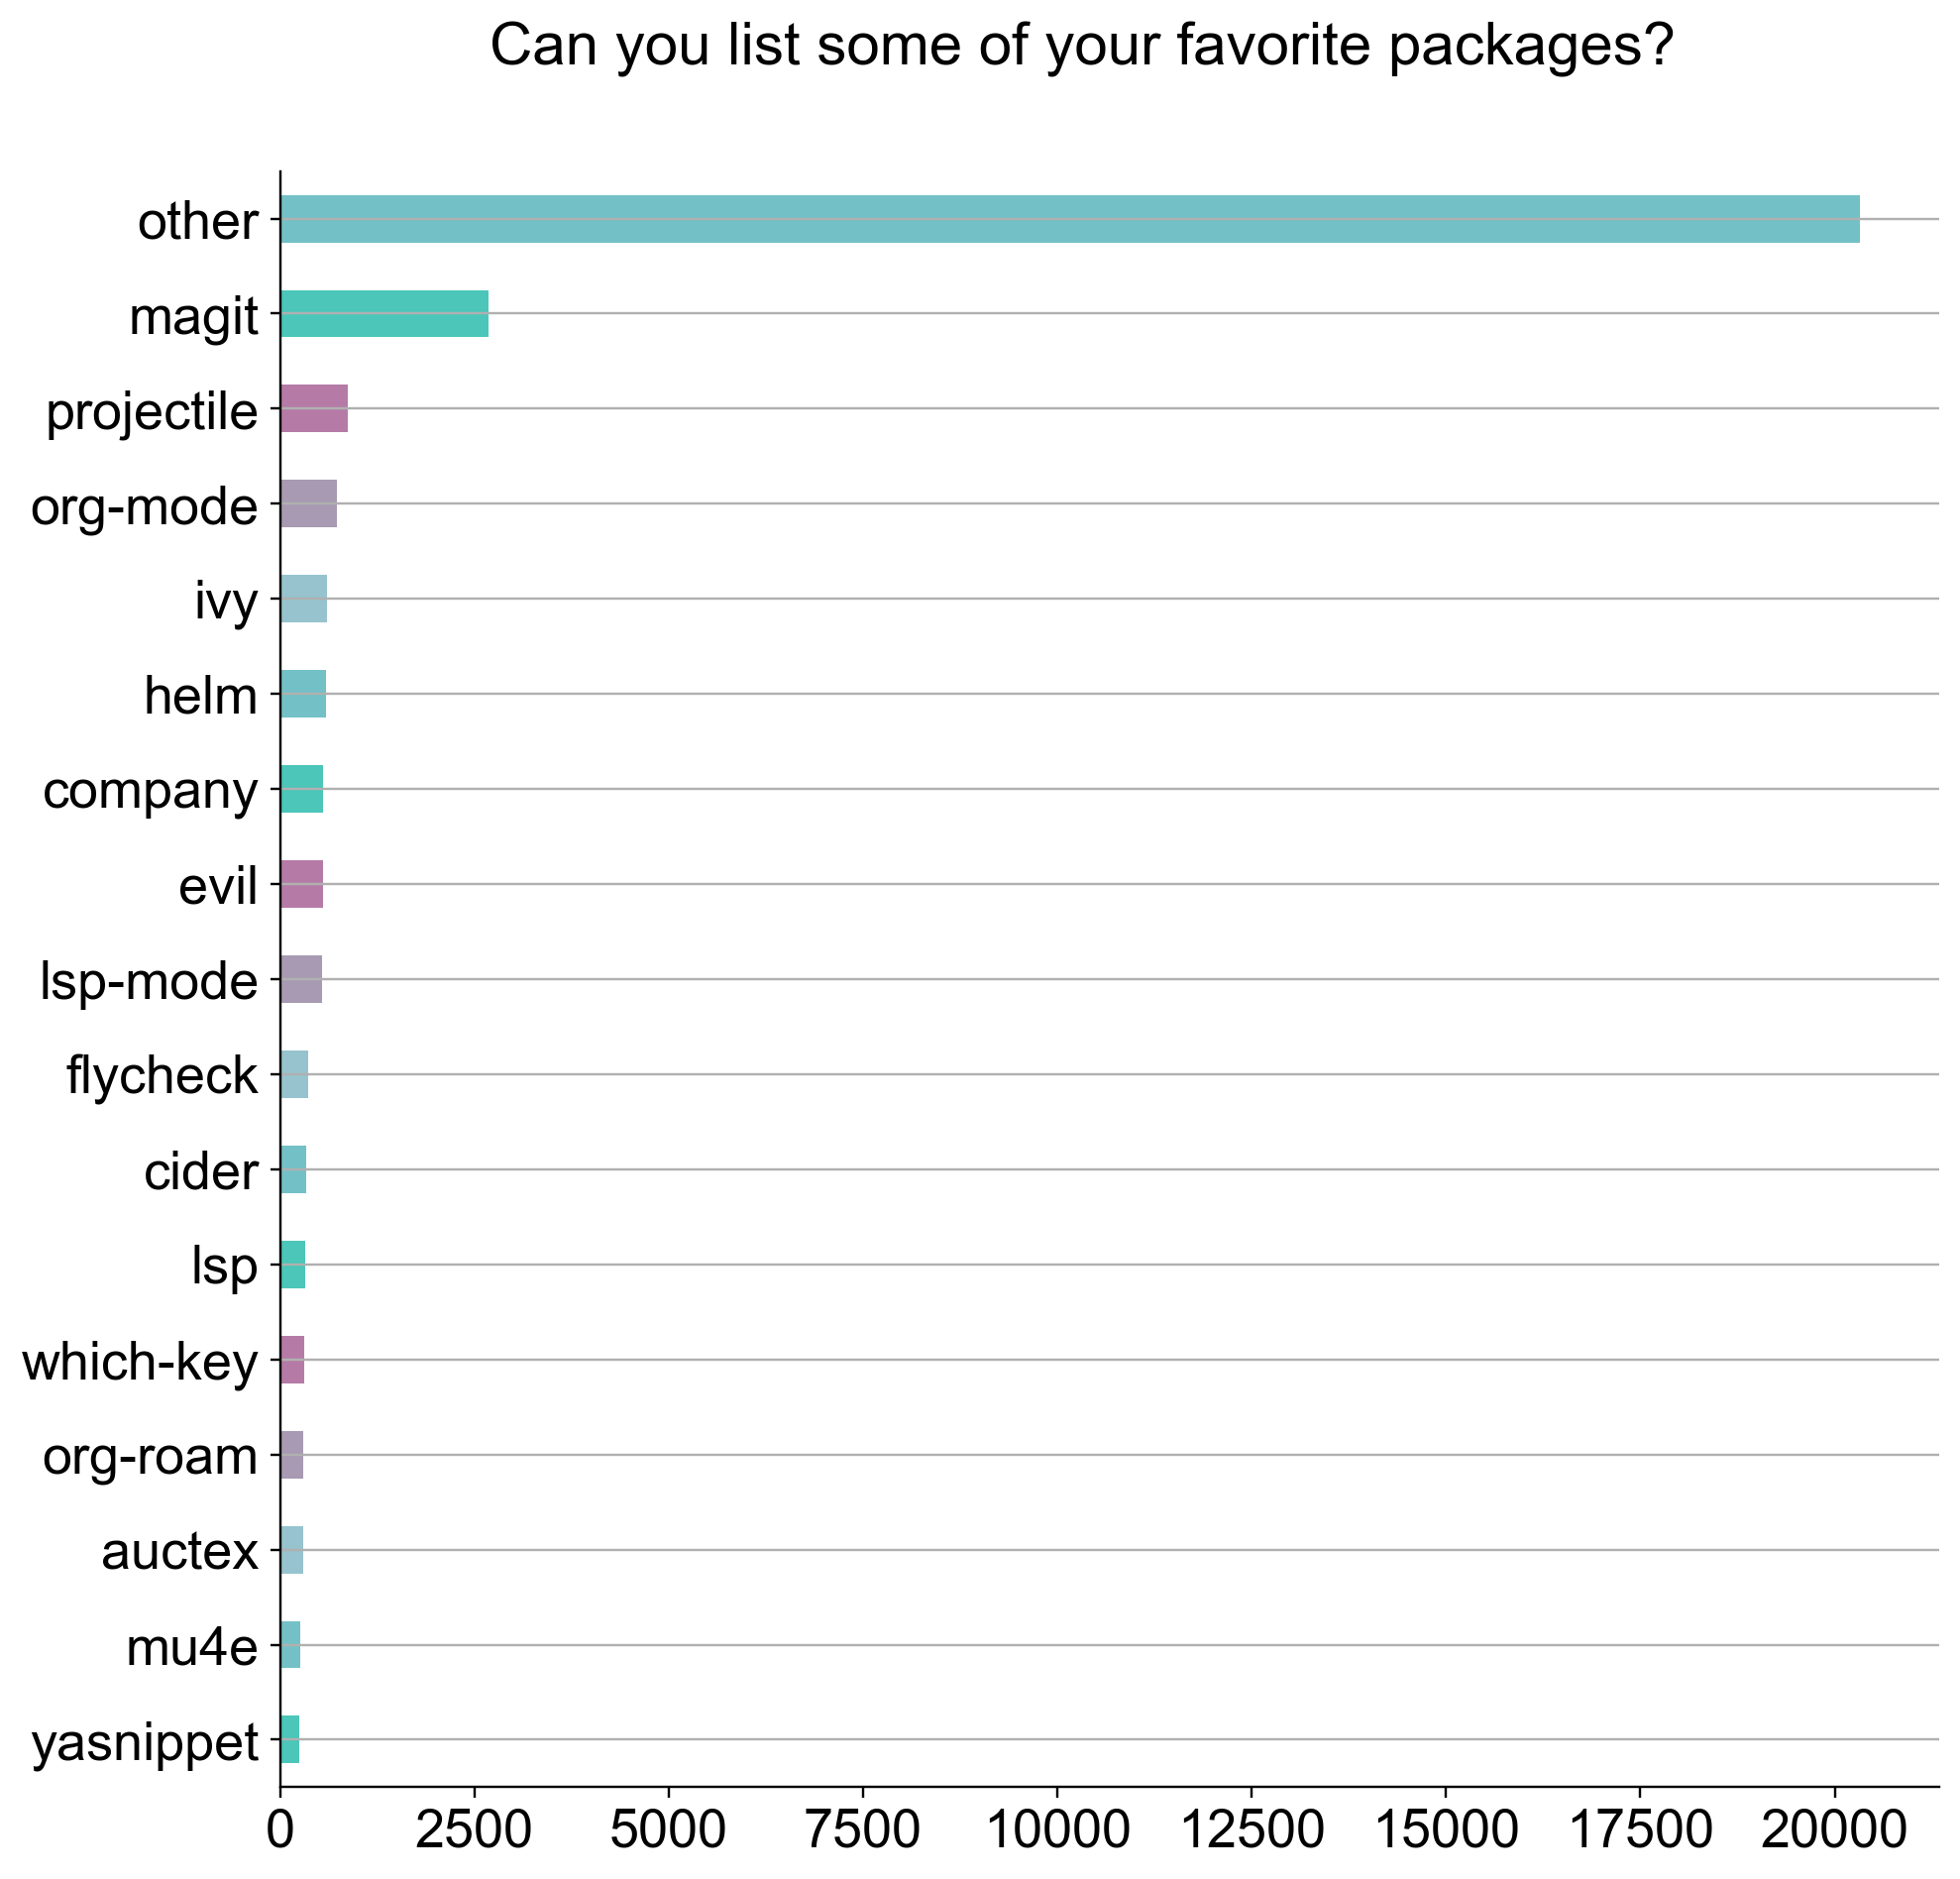

In [60]:
field = 'Can you list some of your favorite packages?'
df, _ = multiple_choice(field, bucket_min=250, separator=r"[;, \n]")
df = df.sort_values(by='total', ascending=False)
df = df.drop([0, 2, 14]) # empty value, space, -

print(df)

barh(field, df, save=True)

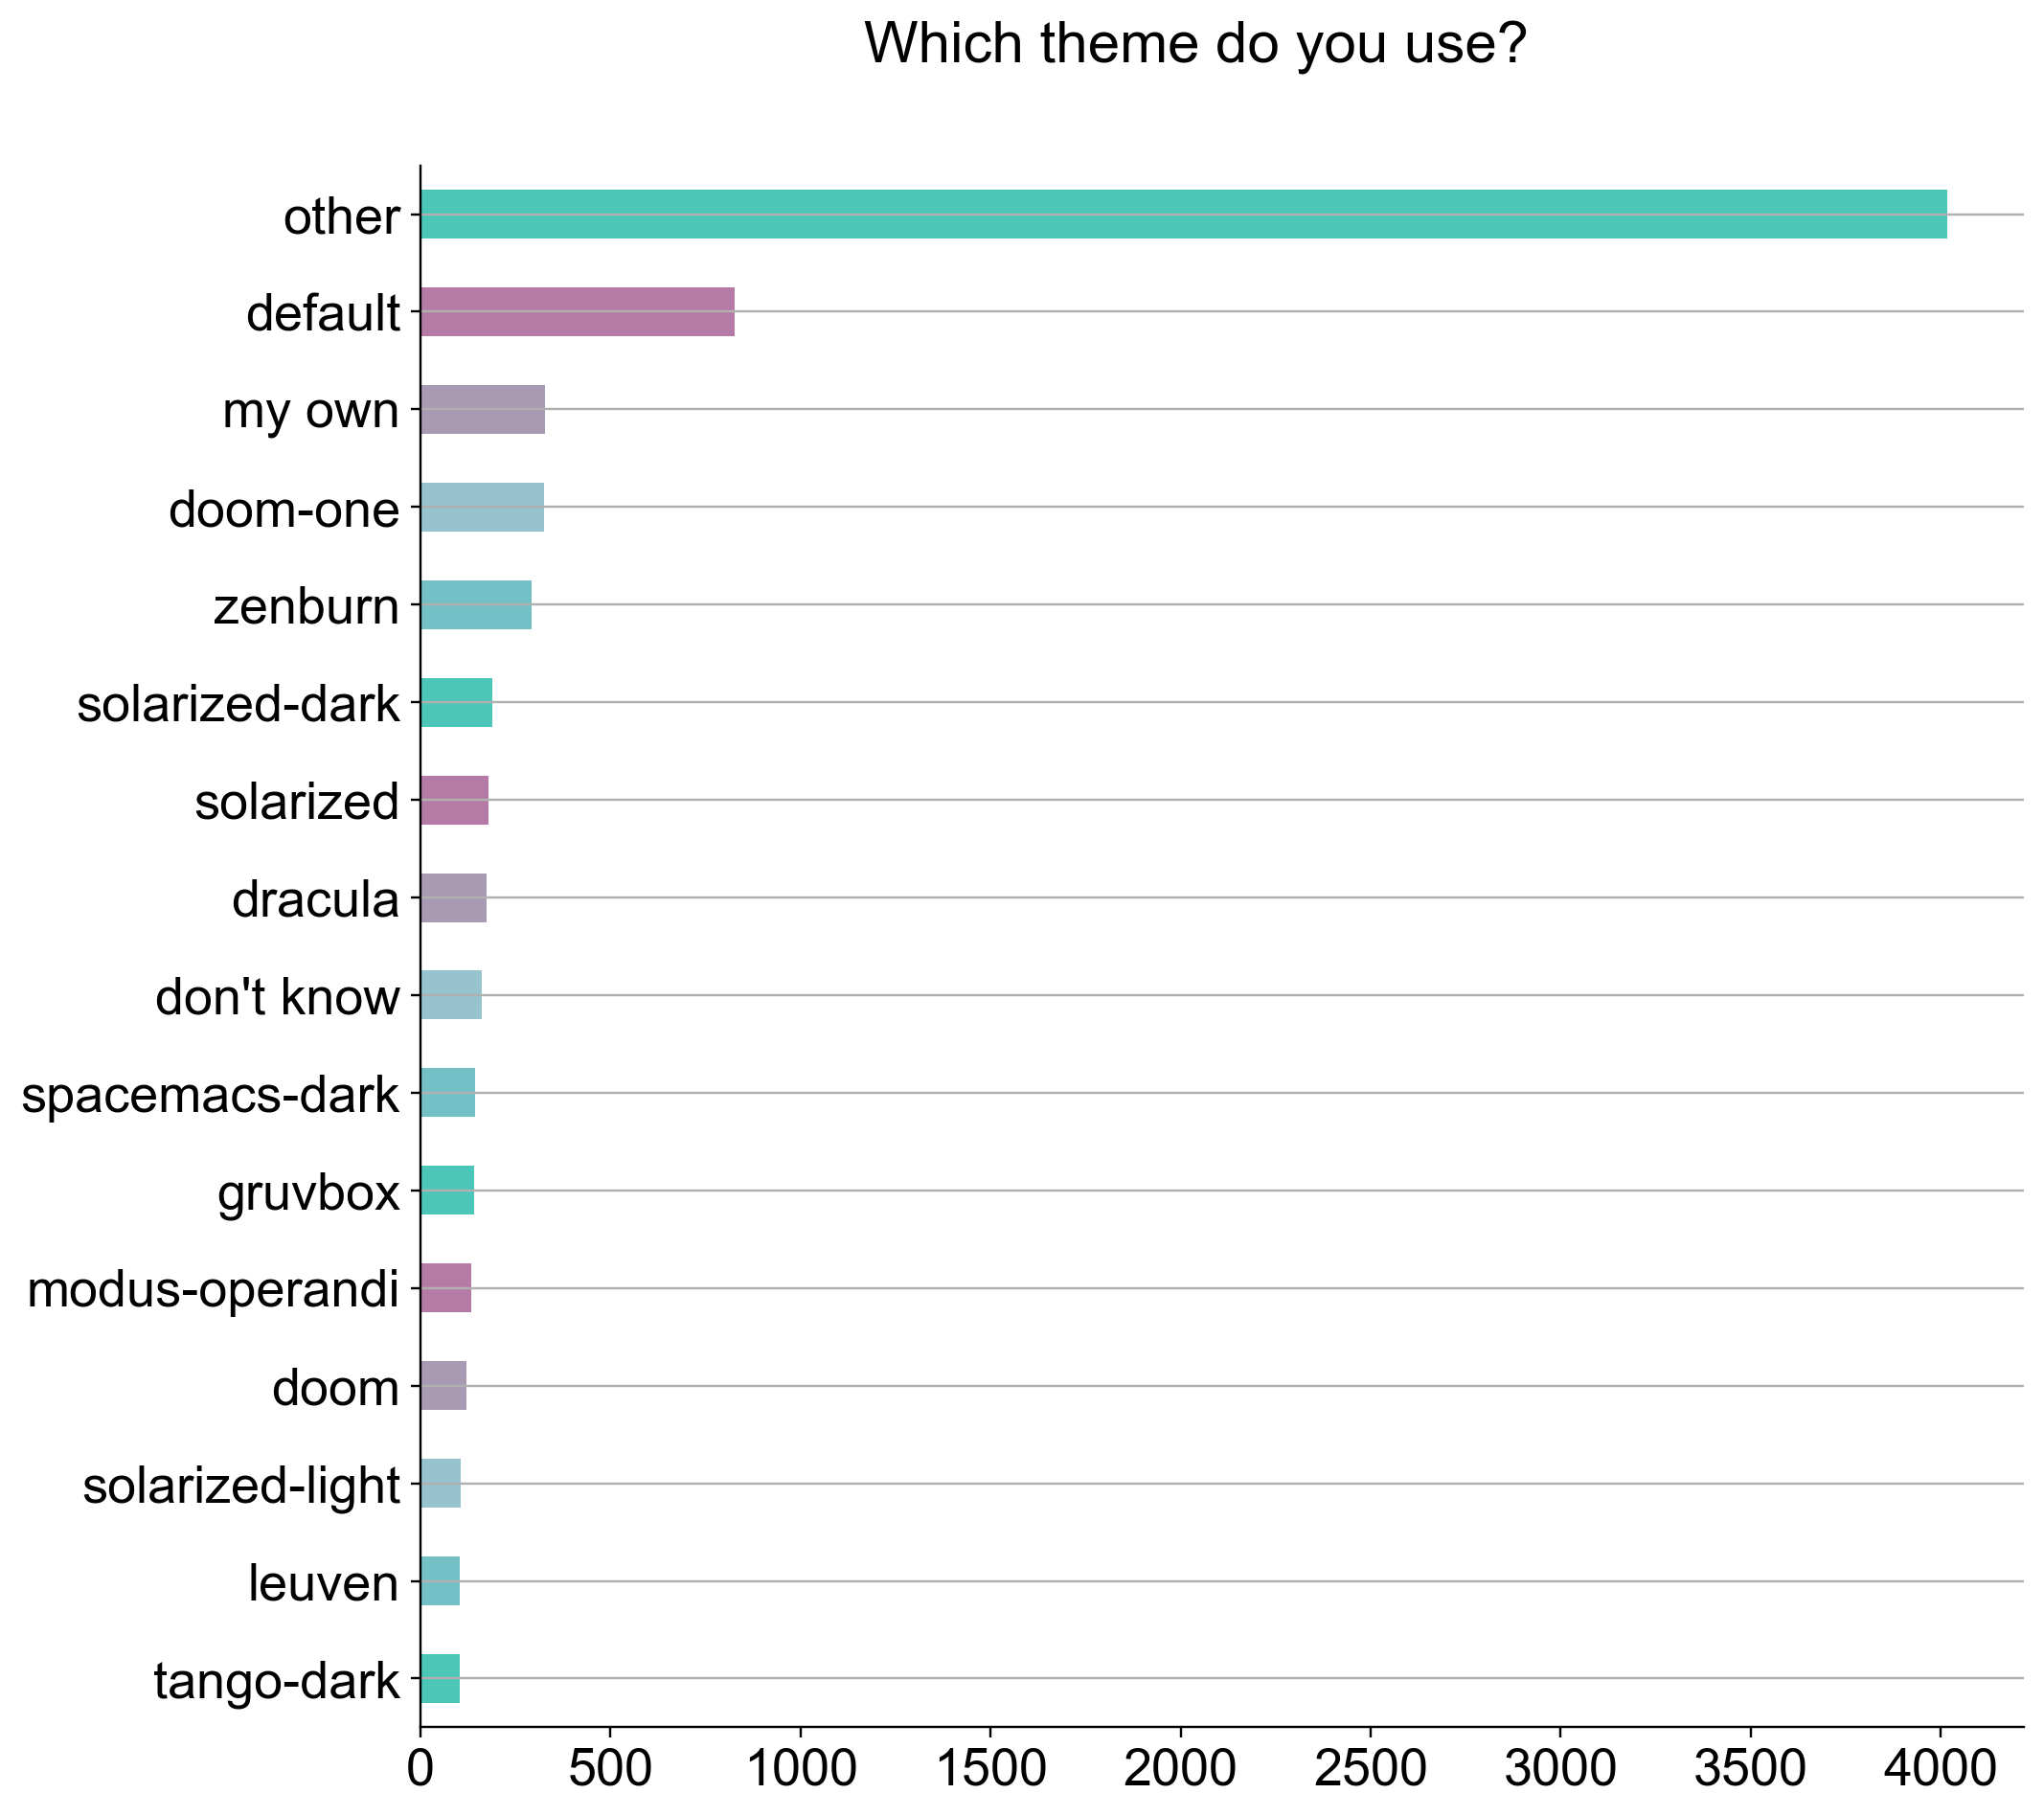

In [63]:
render('Which theme do you use?')

In [142]:
table('Which theme do you use?')

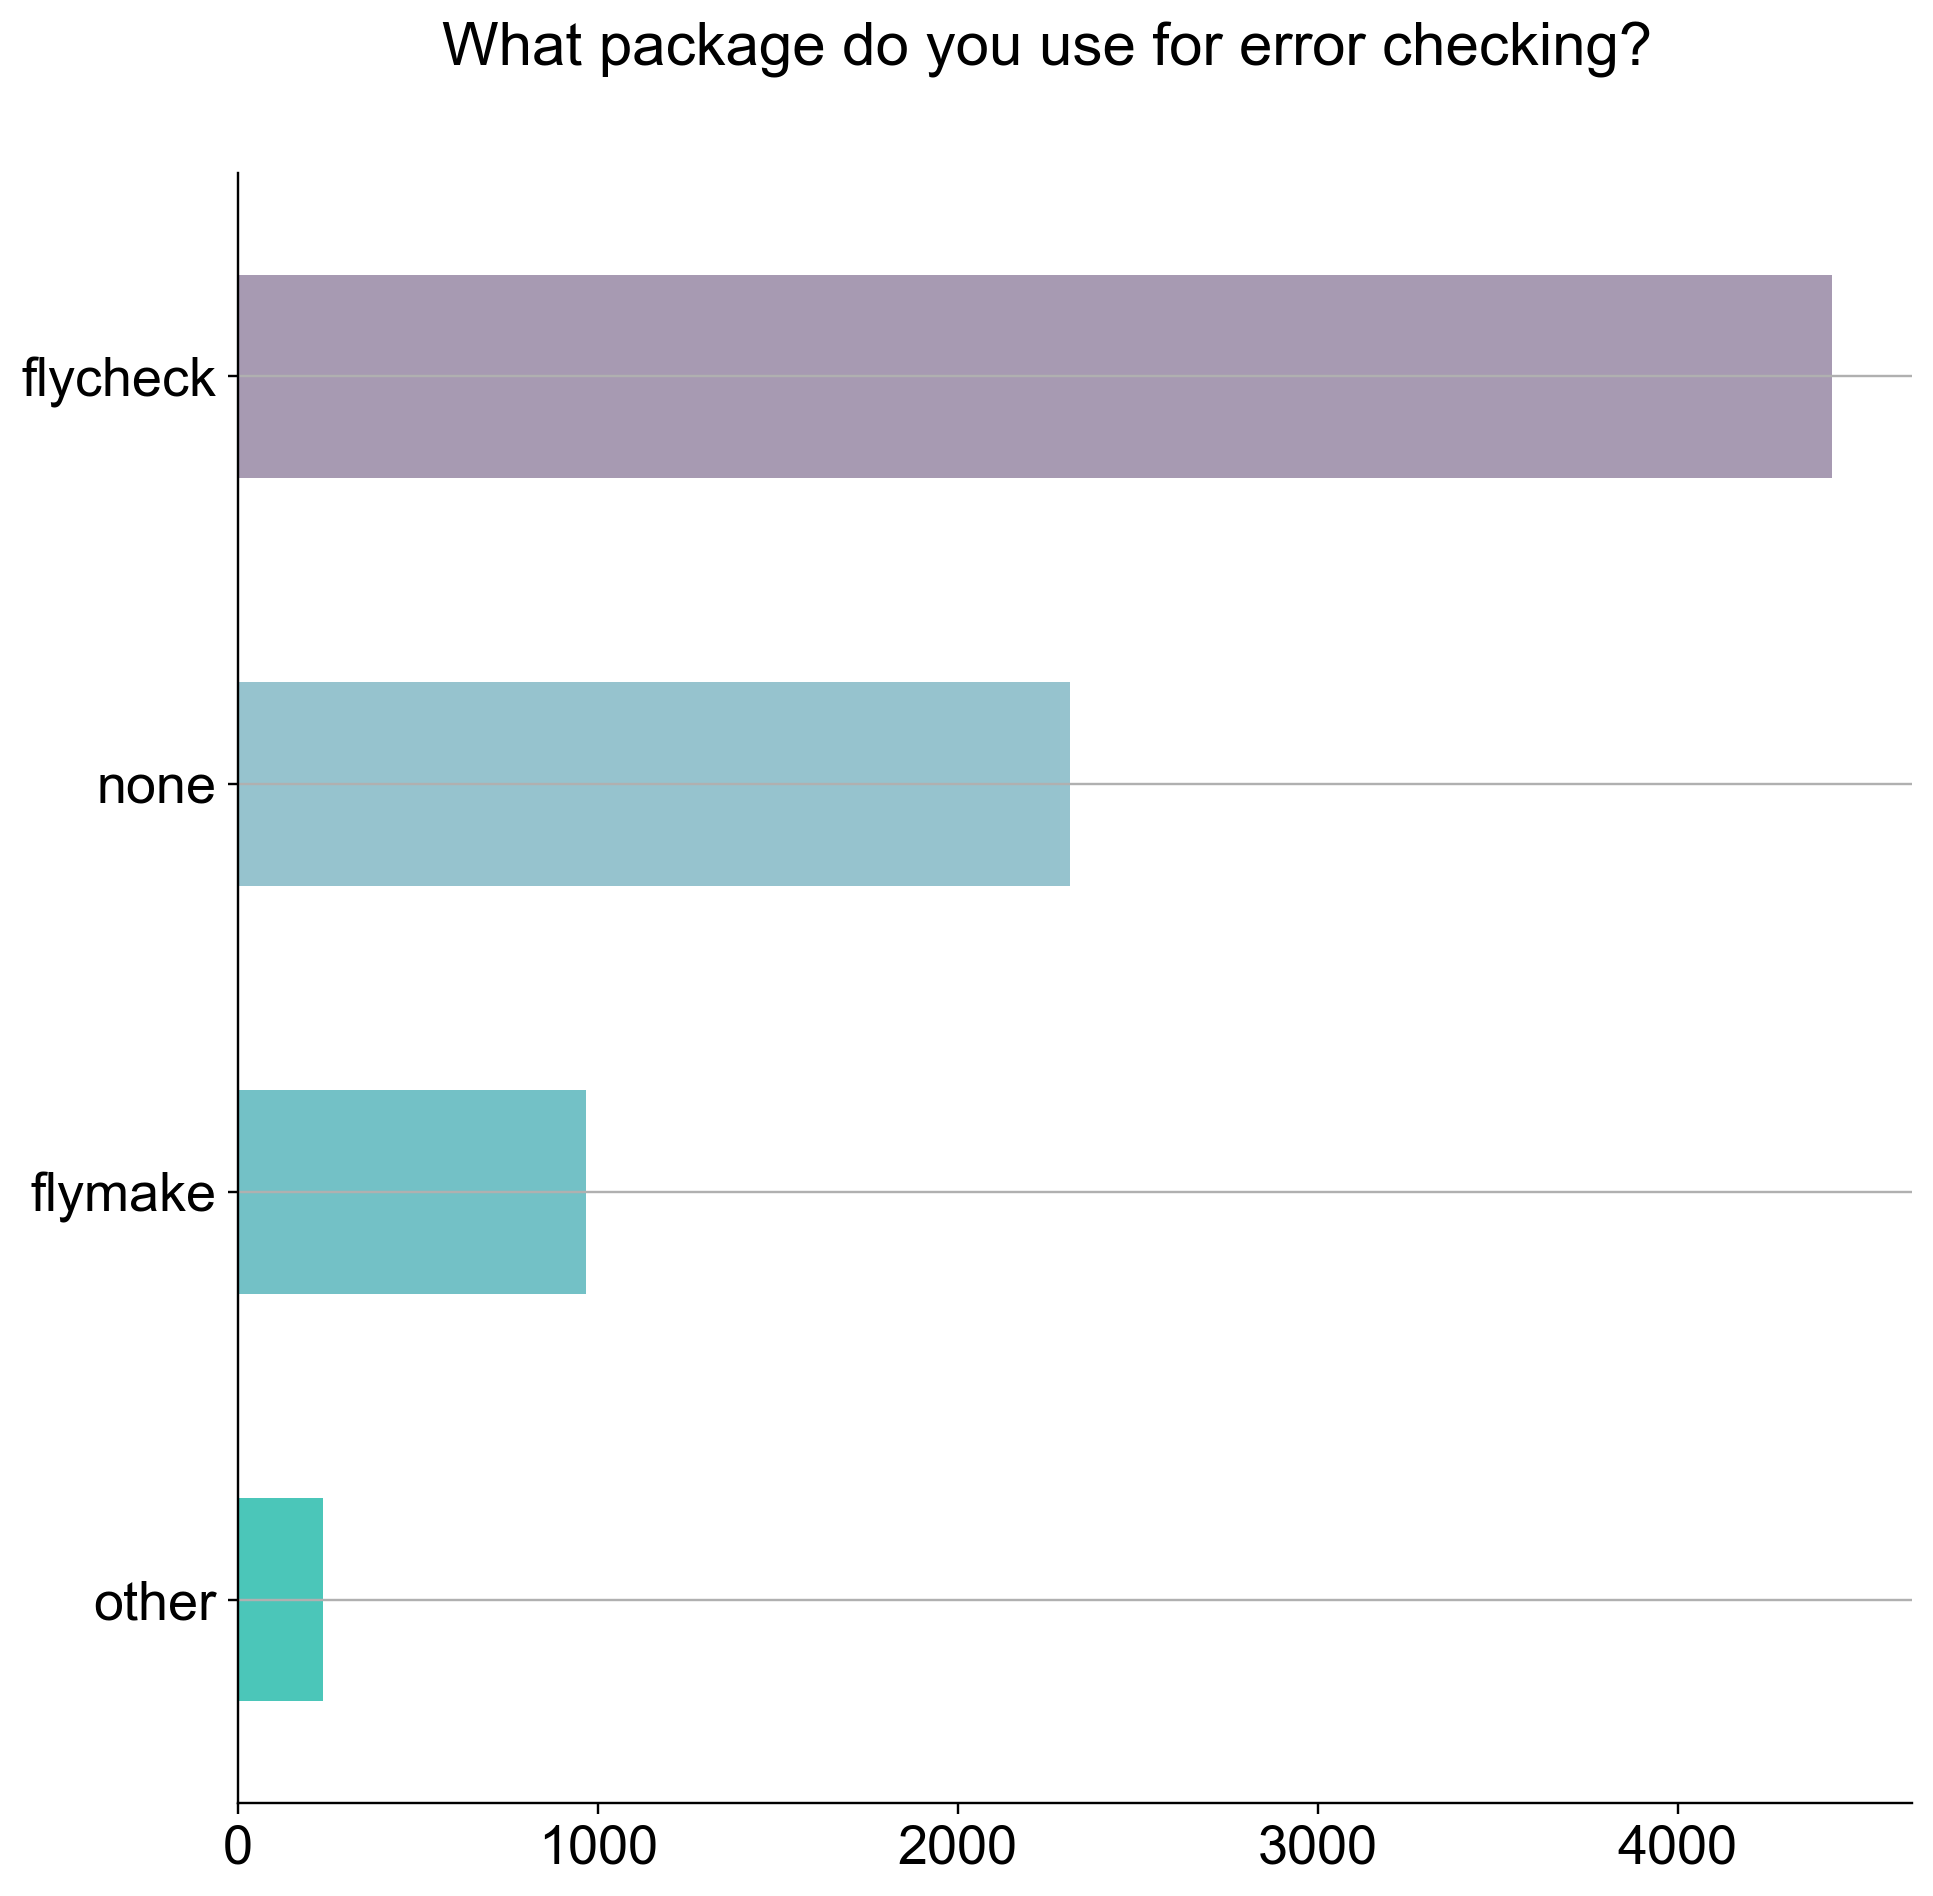

In [65]:
render('What package do you use for error checking?')

In [143]:
table('What package do you use for error checking?')

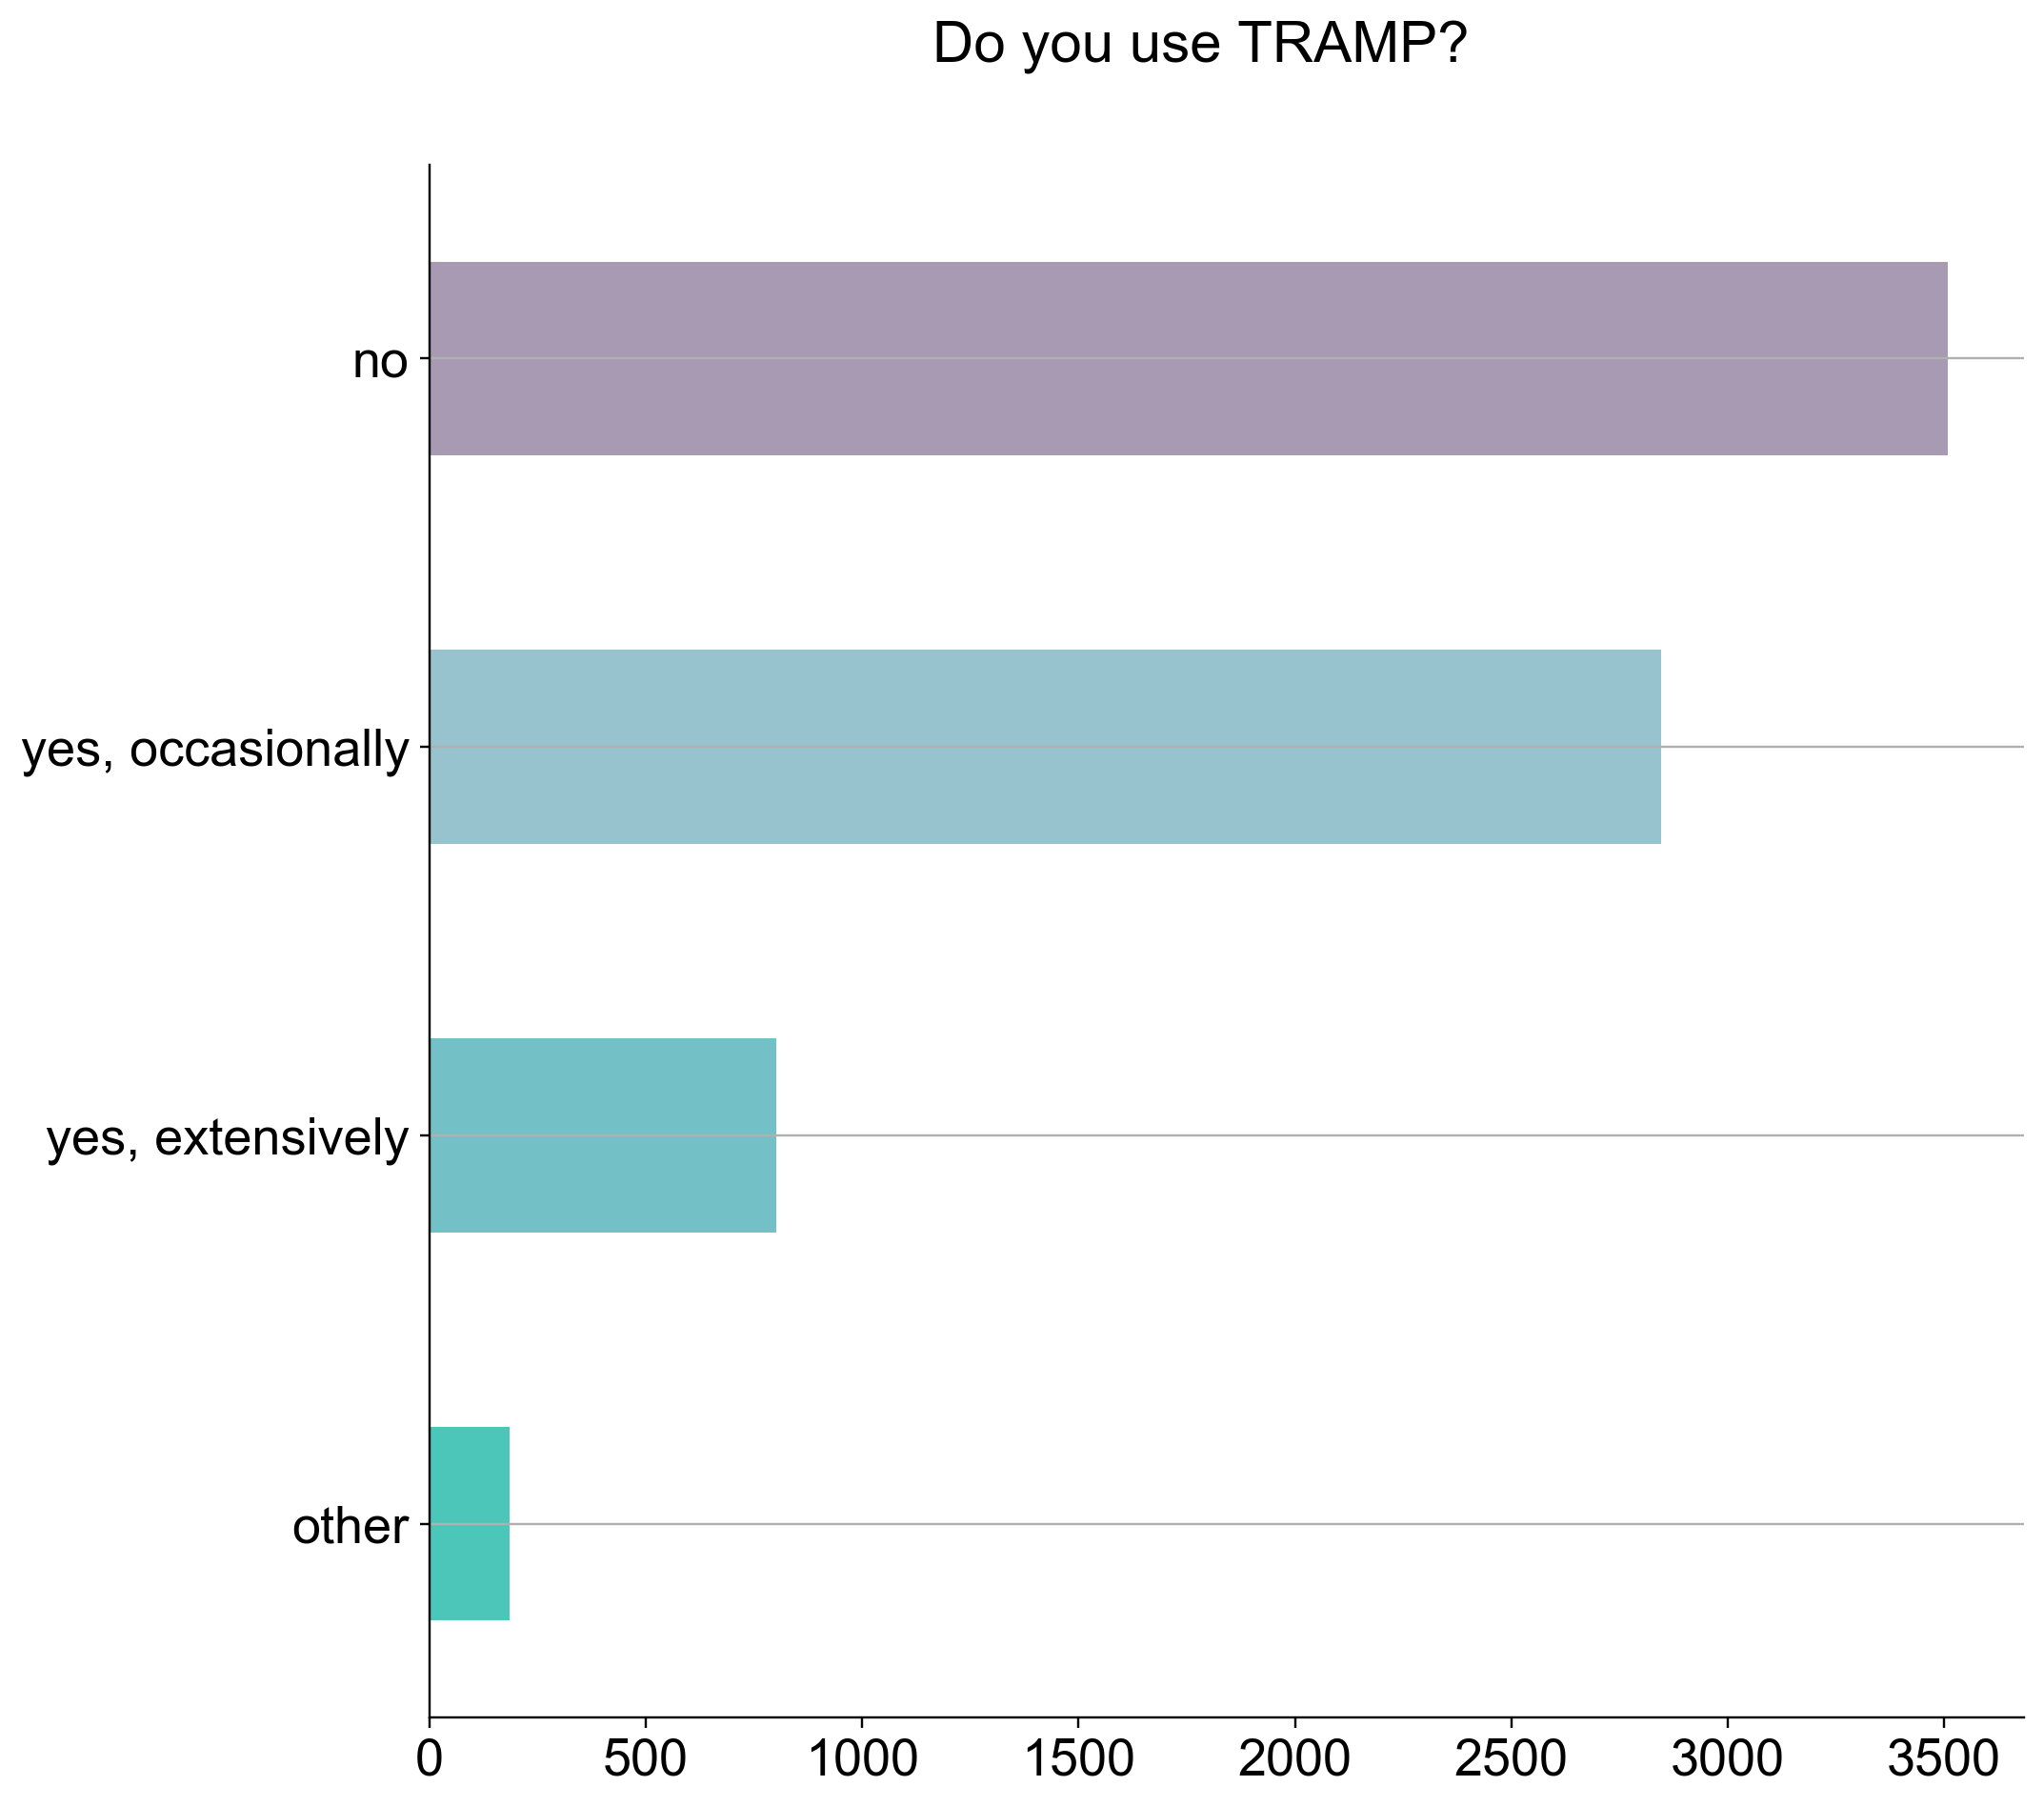

In [67]:
render('Do you use TRAMP?')

In [144]:
table('Do you use TRAMP?')

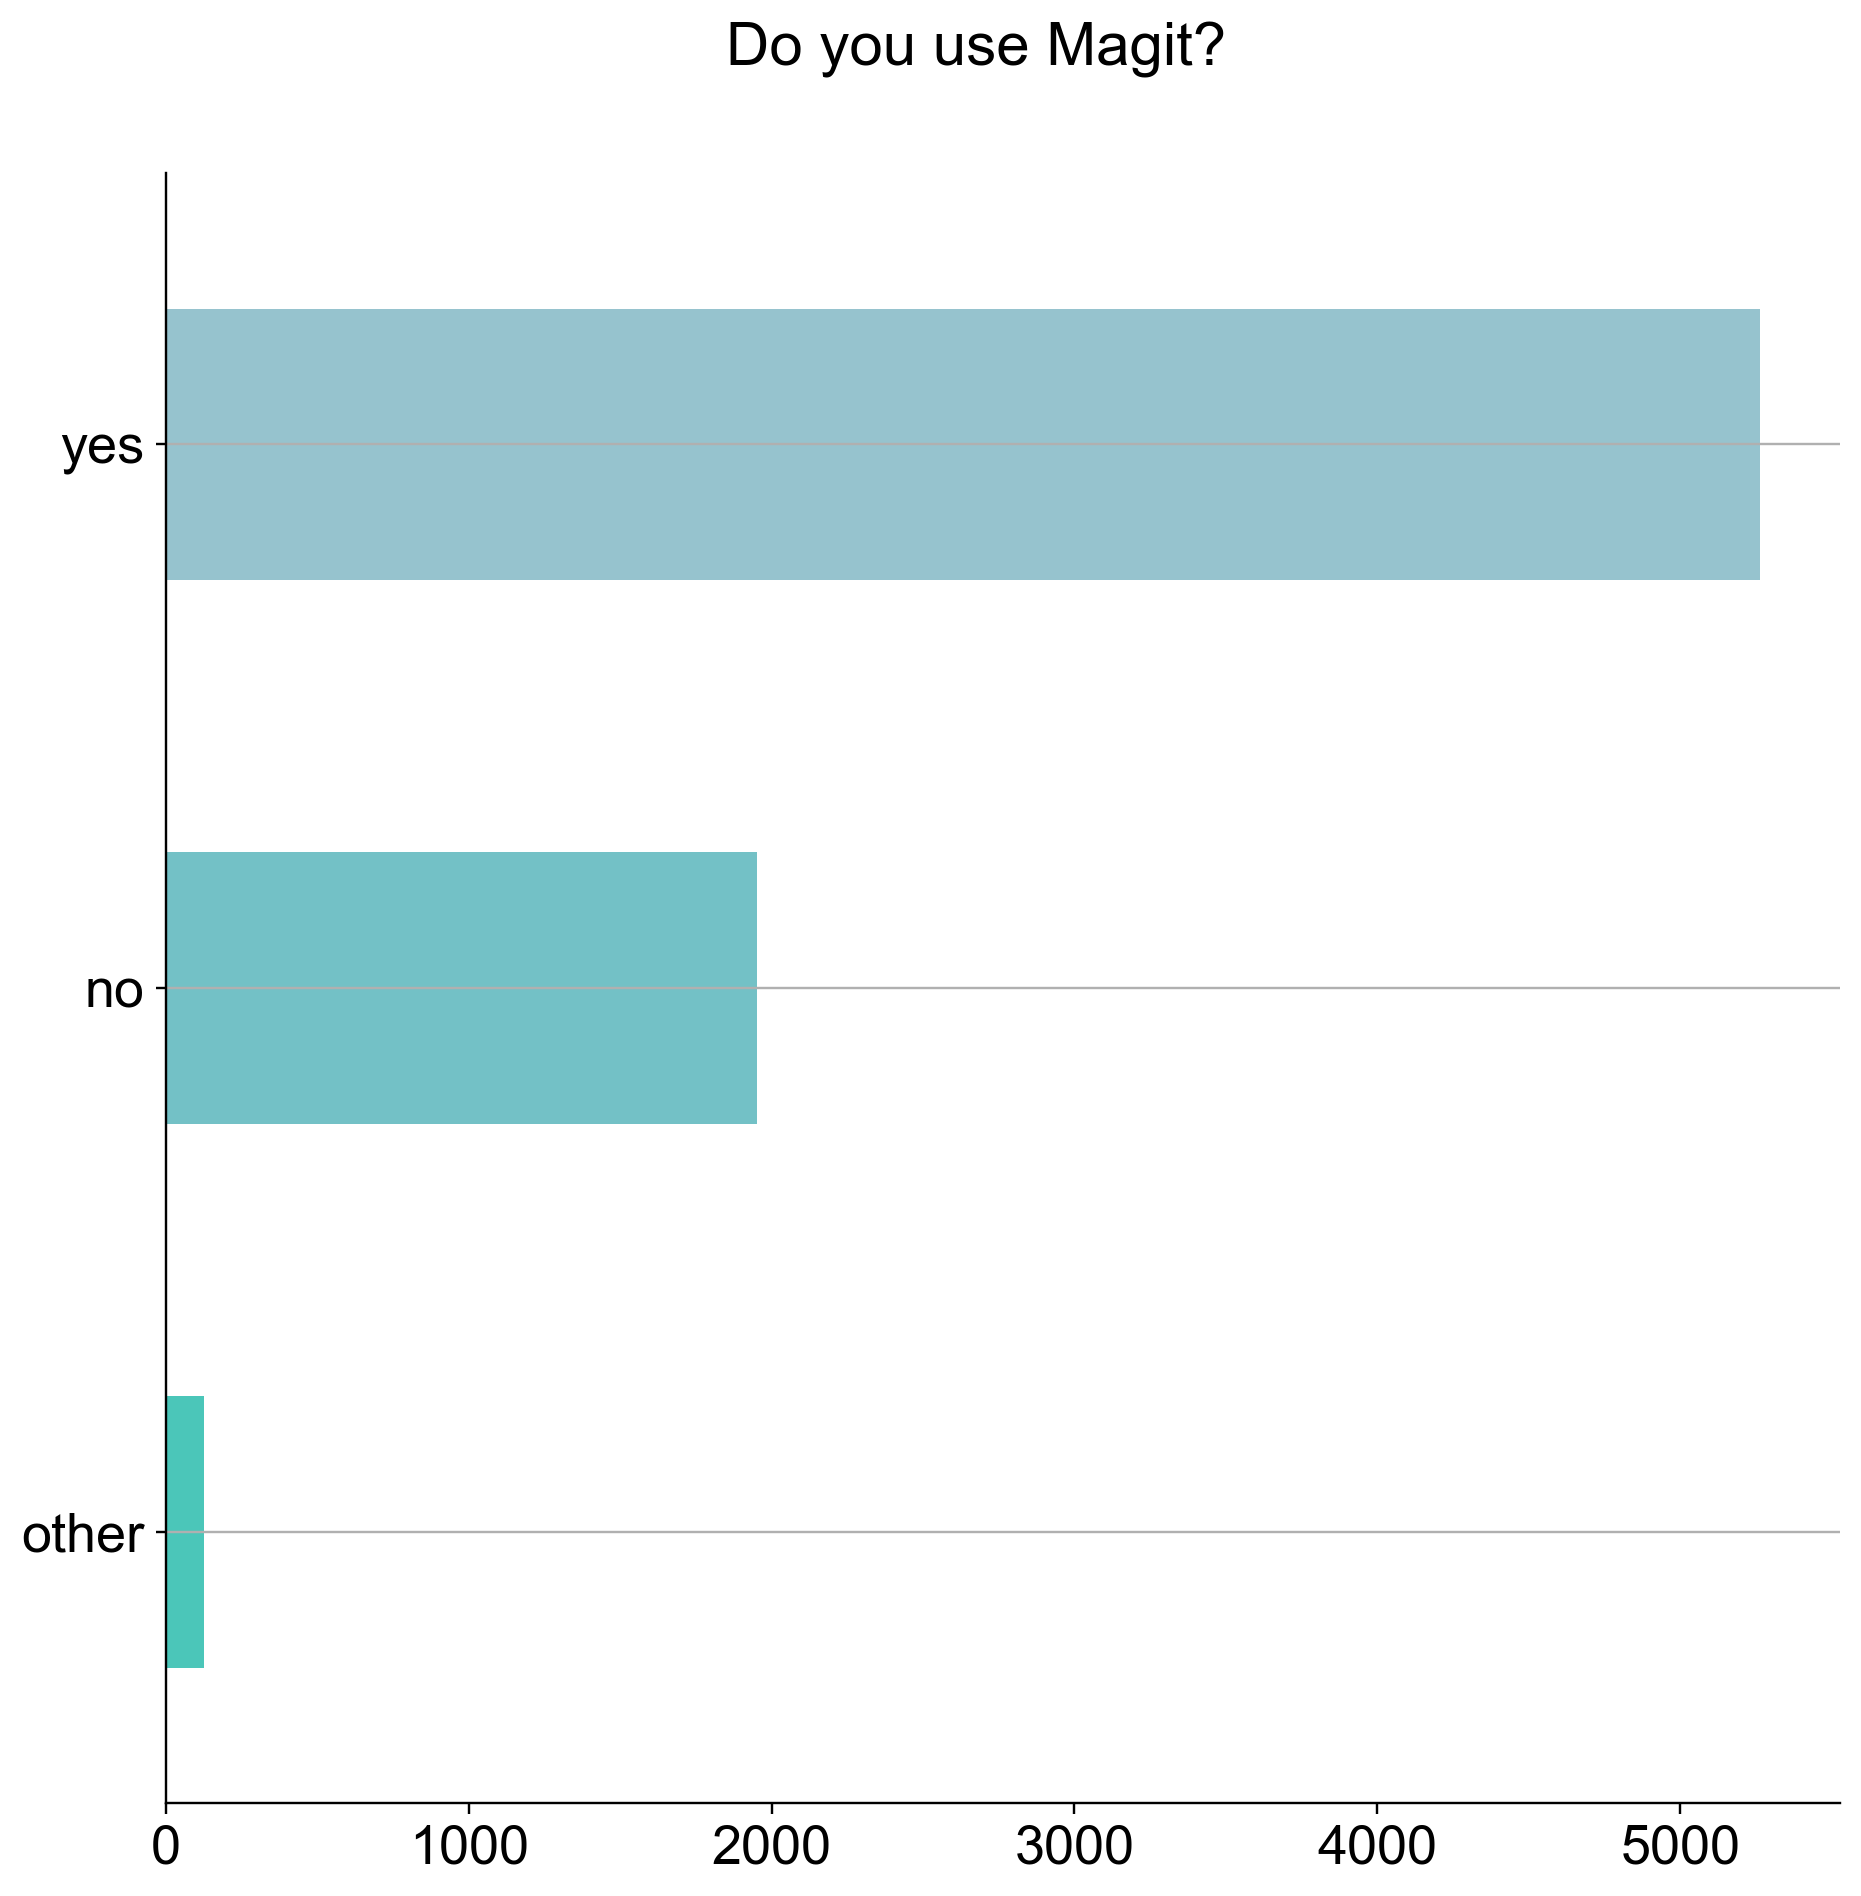

In [69]:
render('Do you use Magit?')

In [145]:
table('Do you use Magit?')

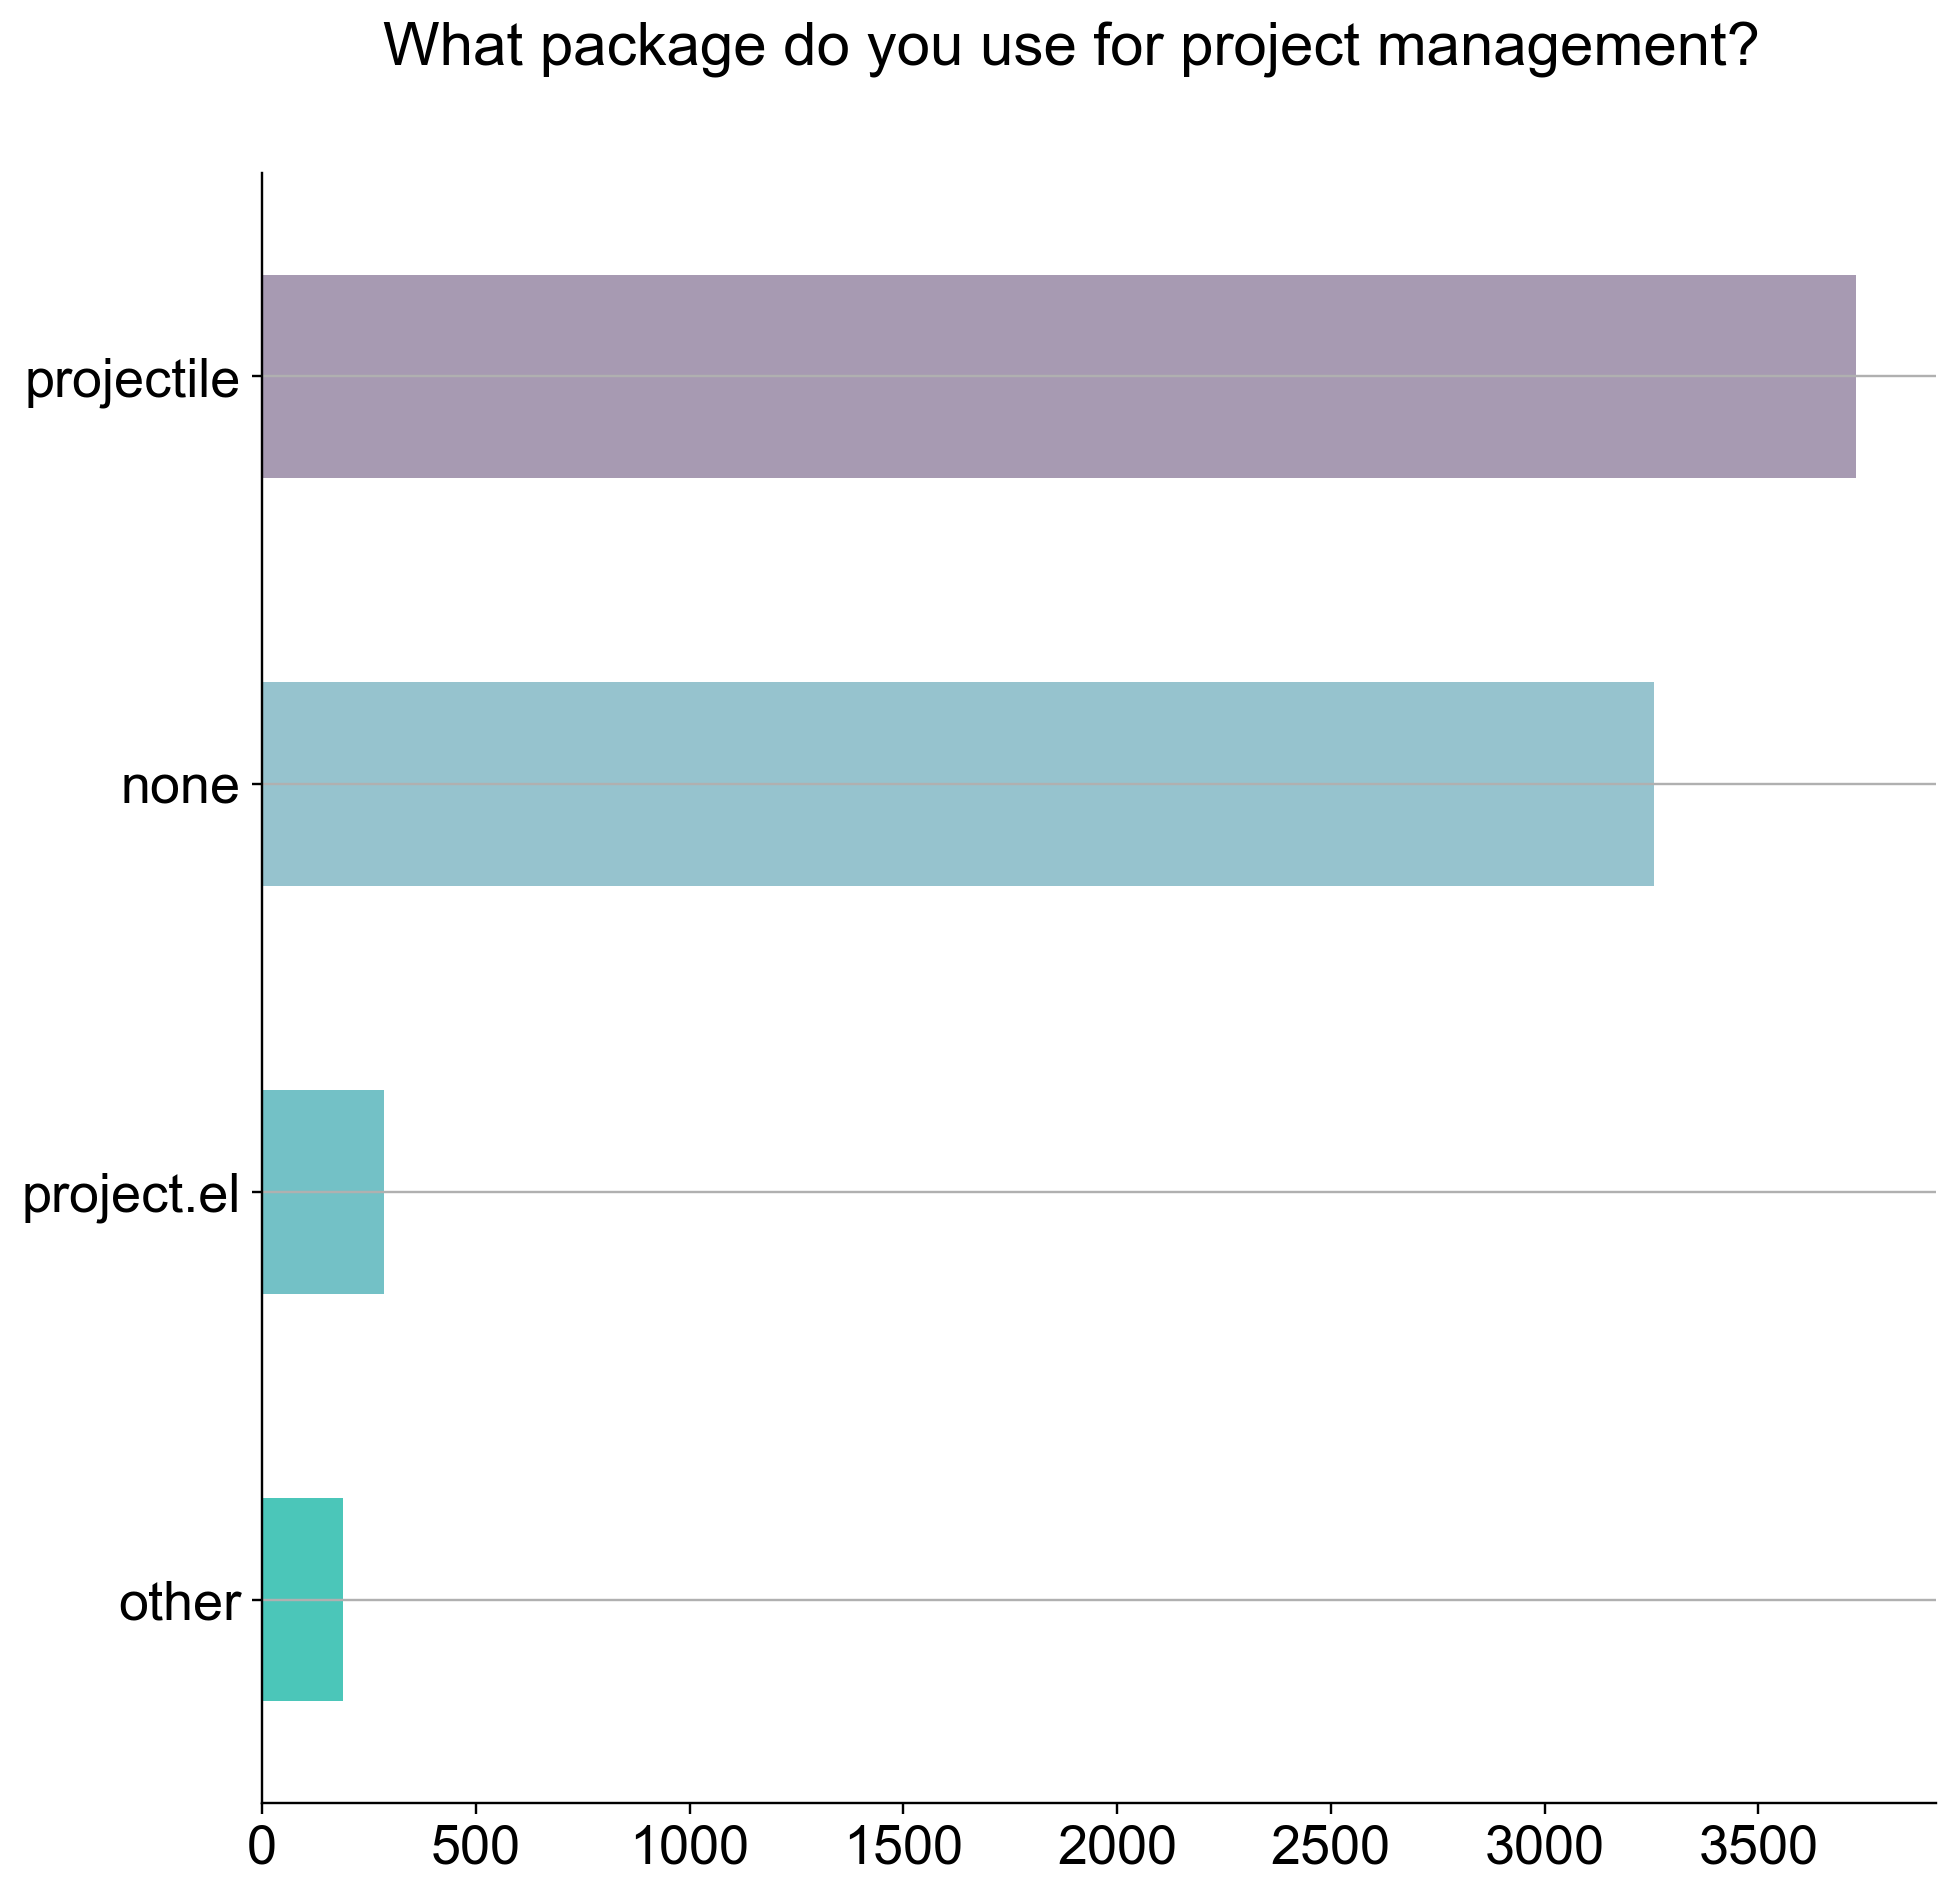

In [71]:
render('What package do you use for project management?')

In [146]:
table('What package do you use for project management?')

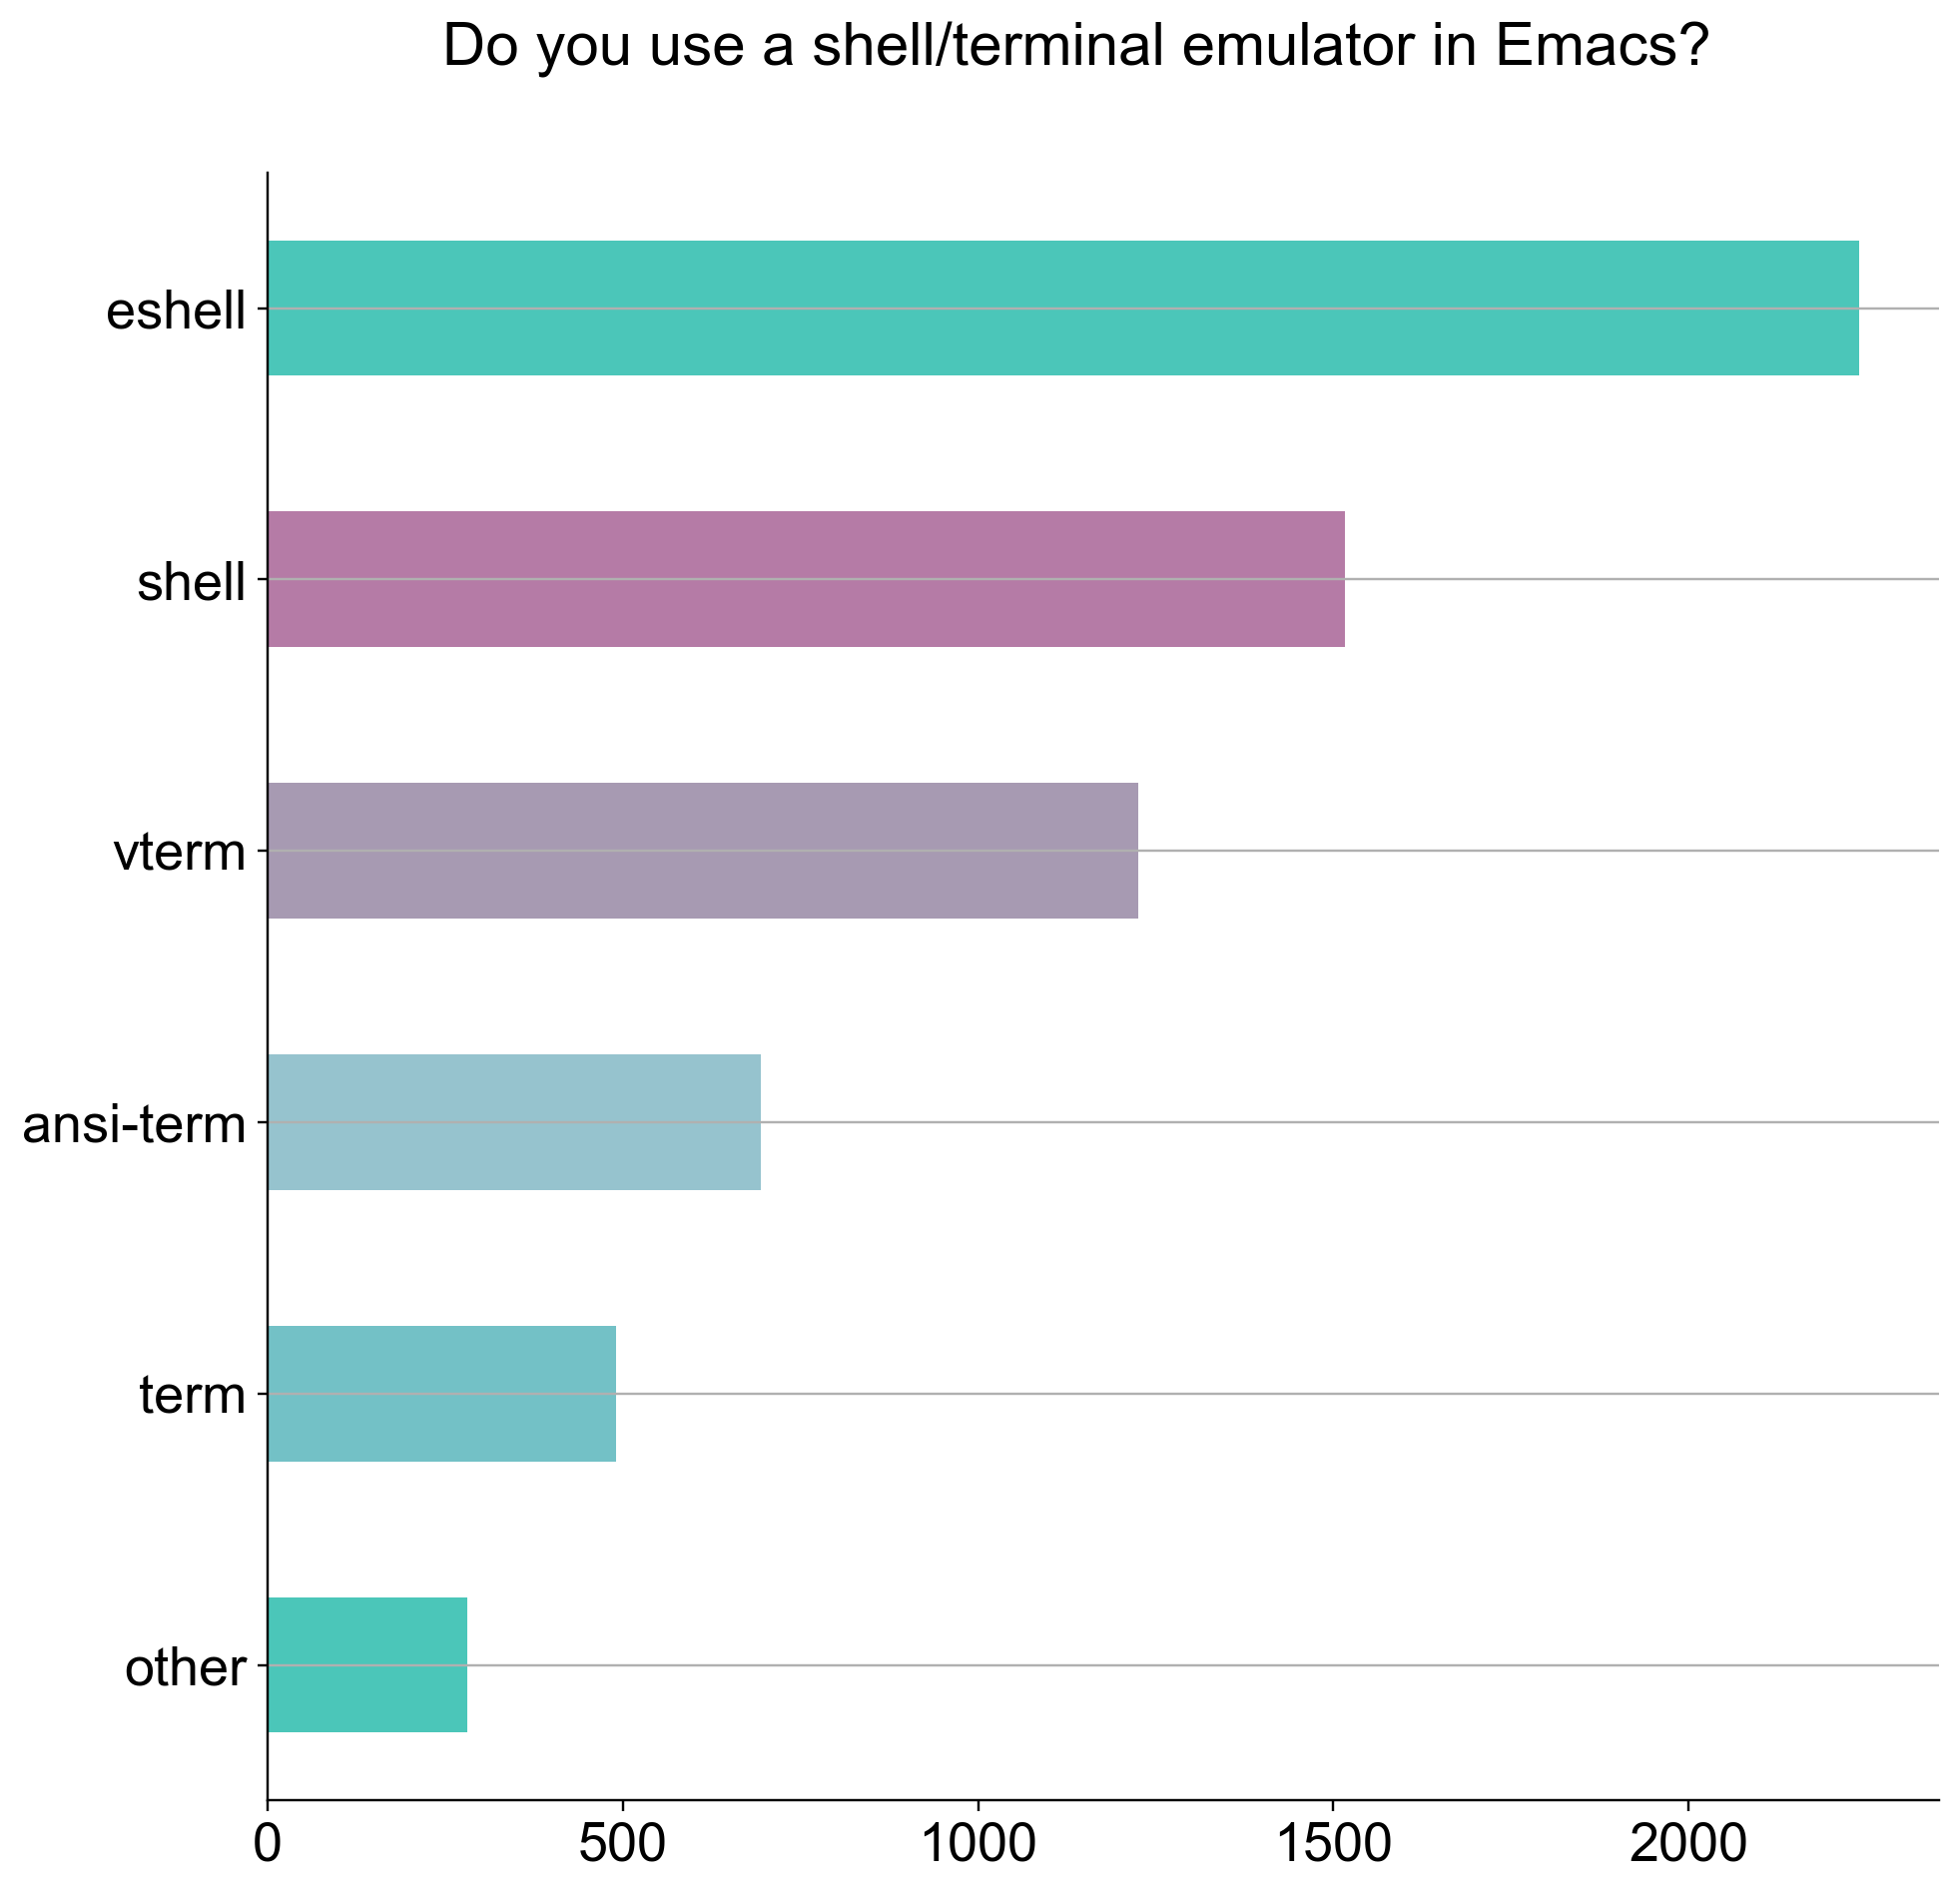

In [73]:
render('Do you use a shell/terminal emulator in Emacs?')

In [147]:
table('Do you use a shell/terminal emulator in Emacs?')

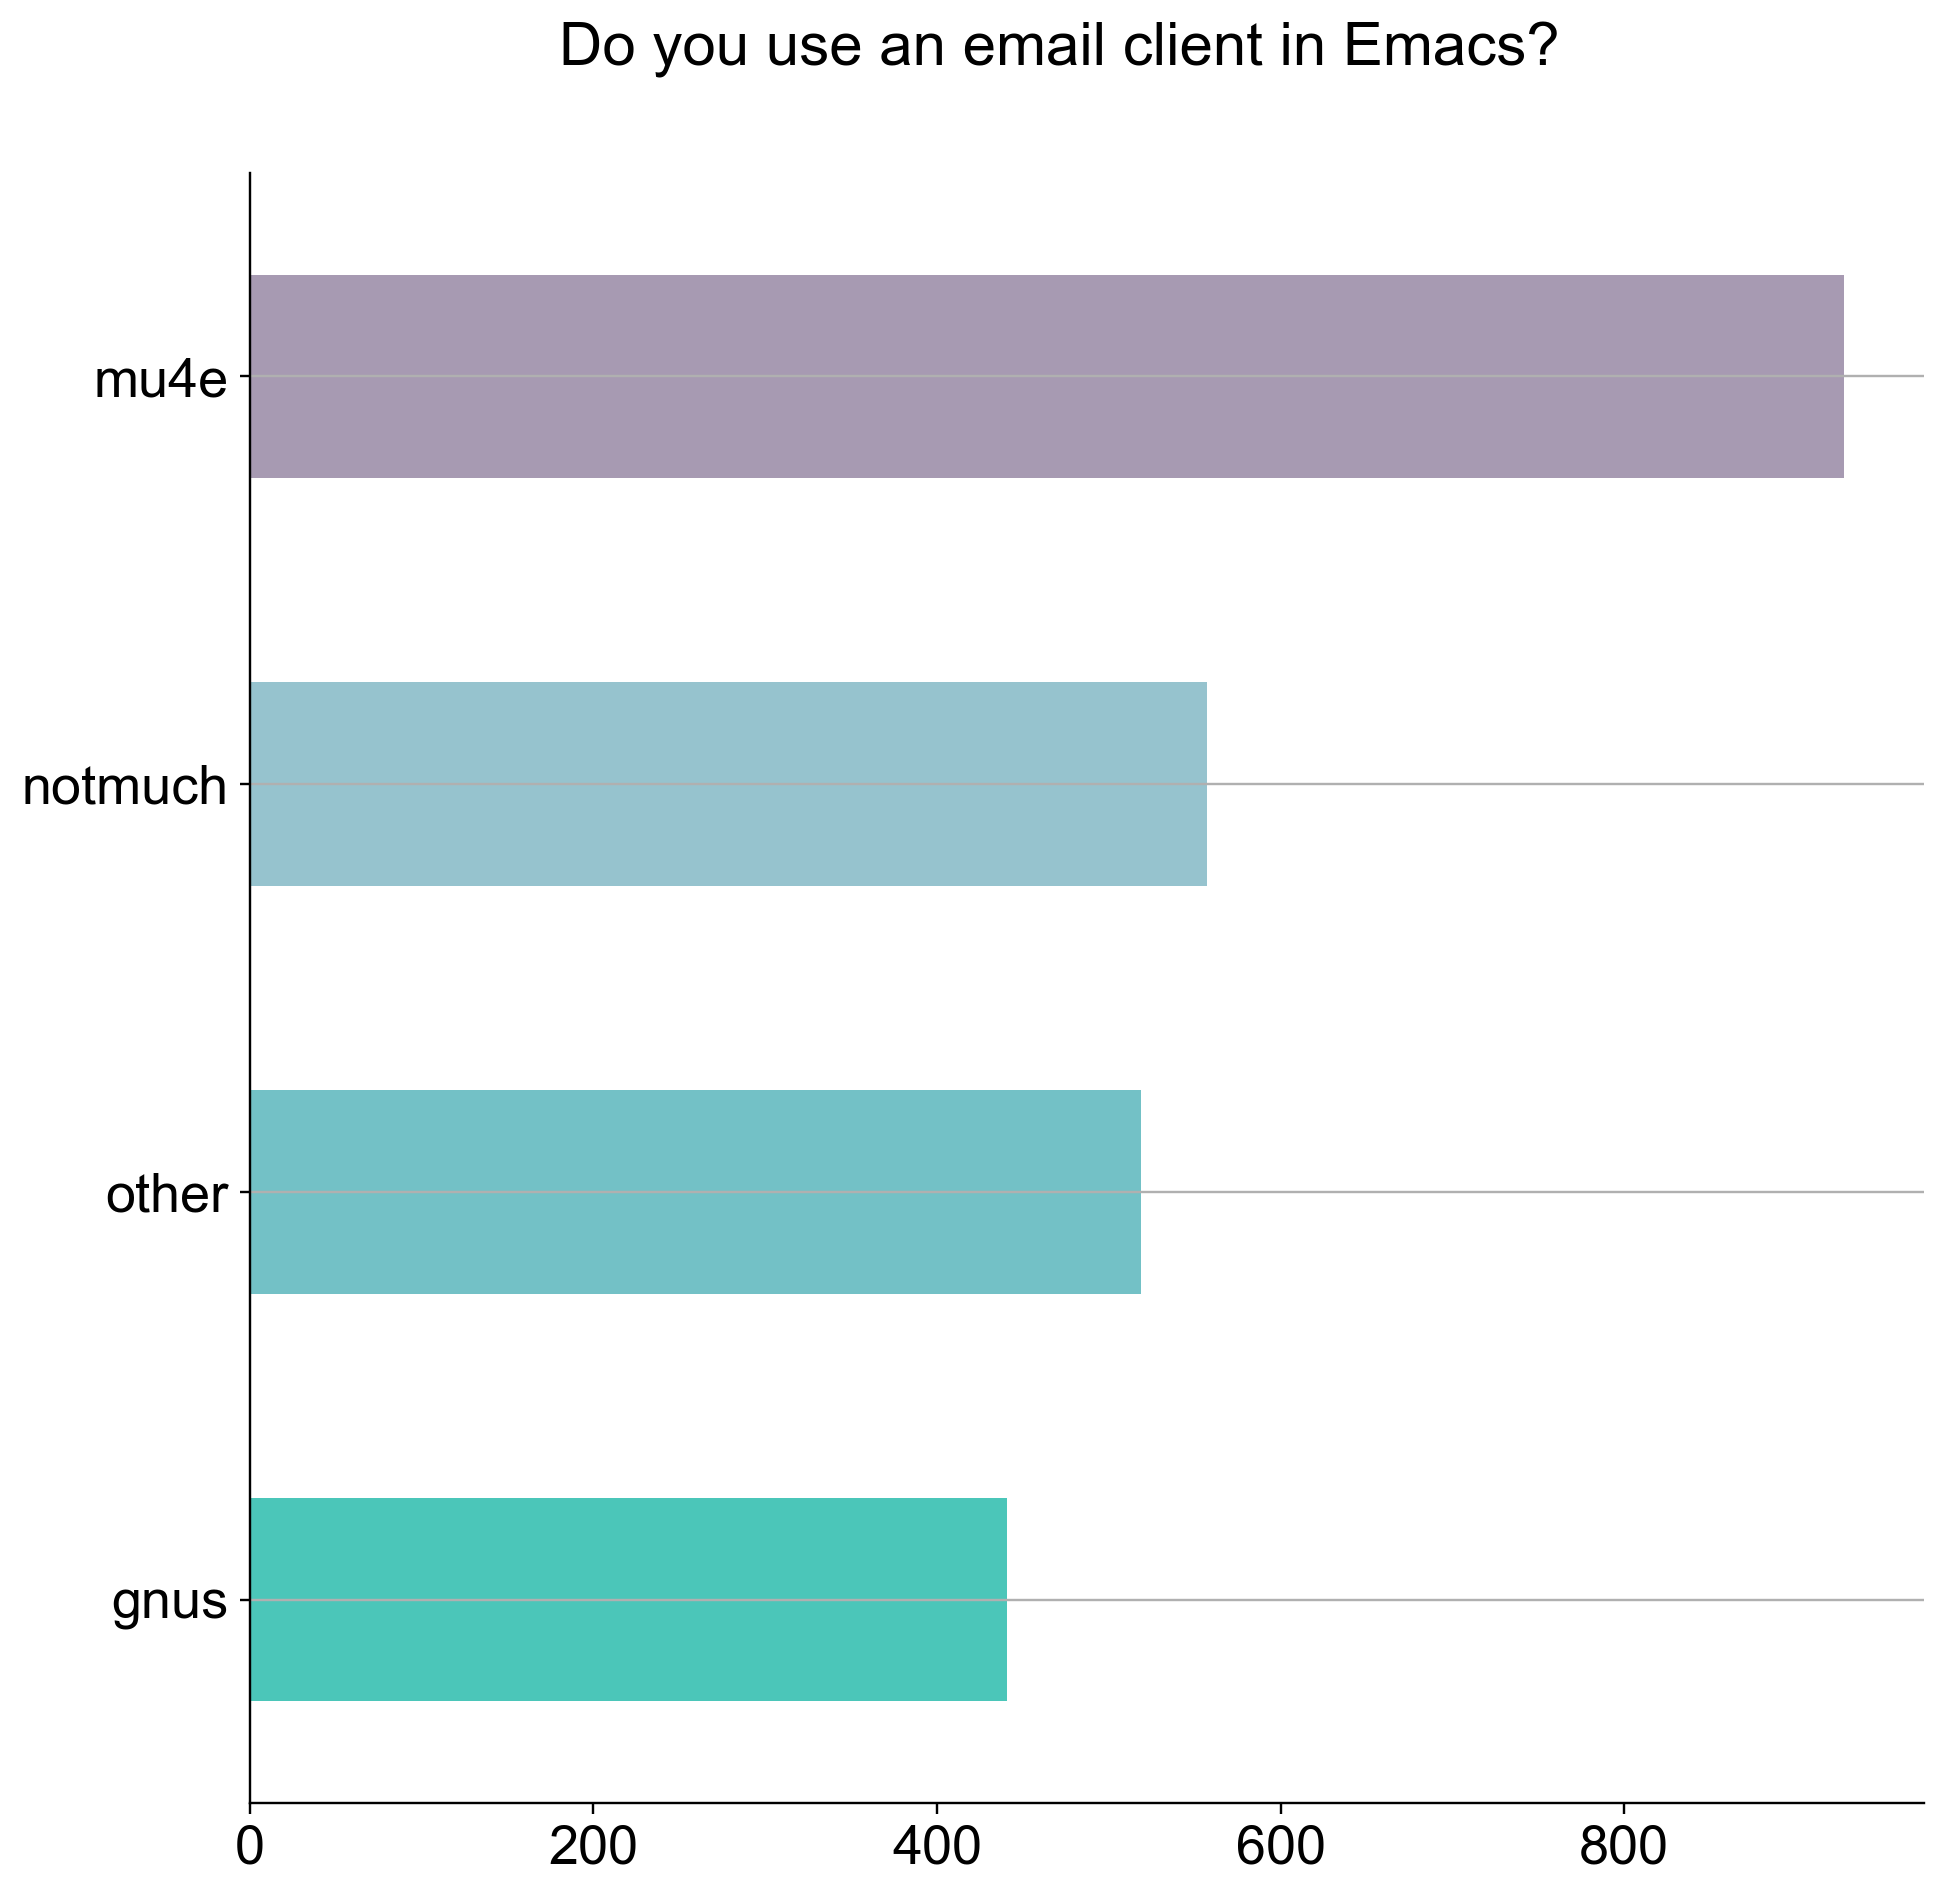

In [75]:
render('Do you use an email client in Emacs?')

In [148]:
table('Do you use an email client in Emacs?')

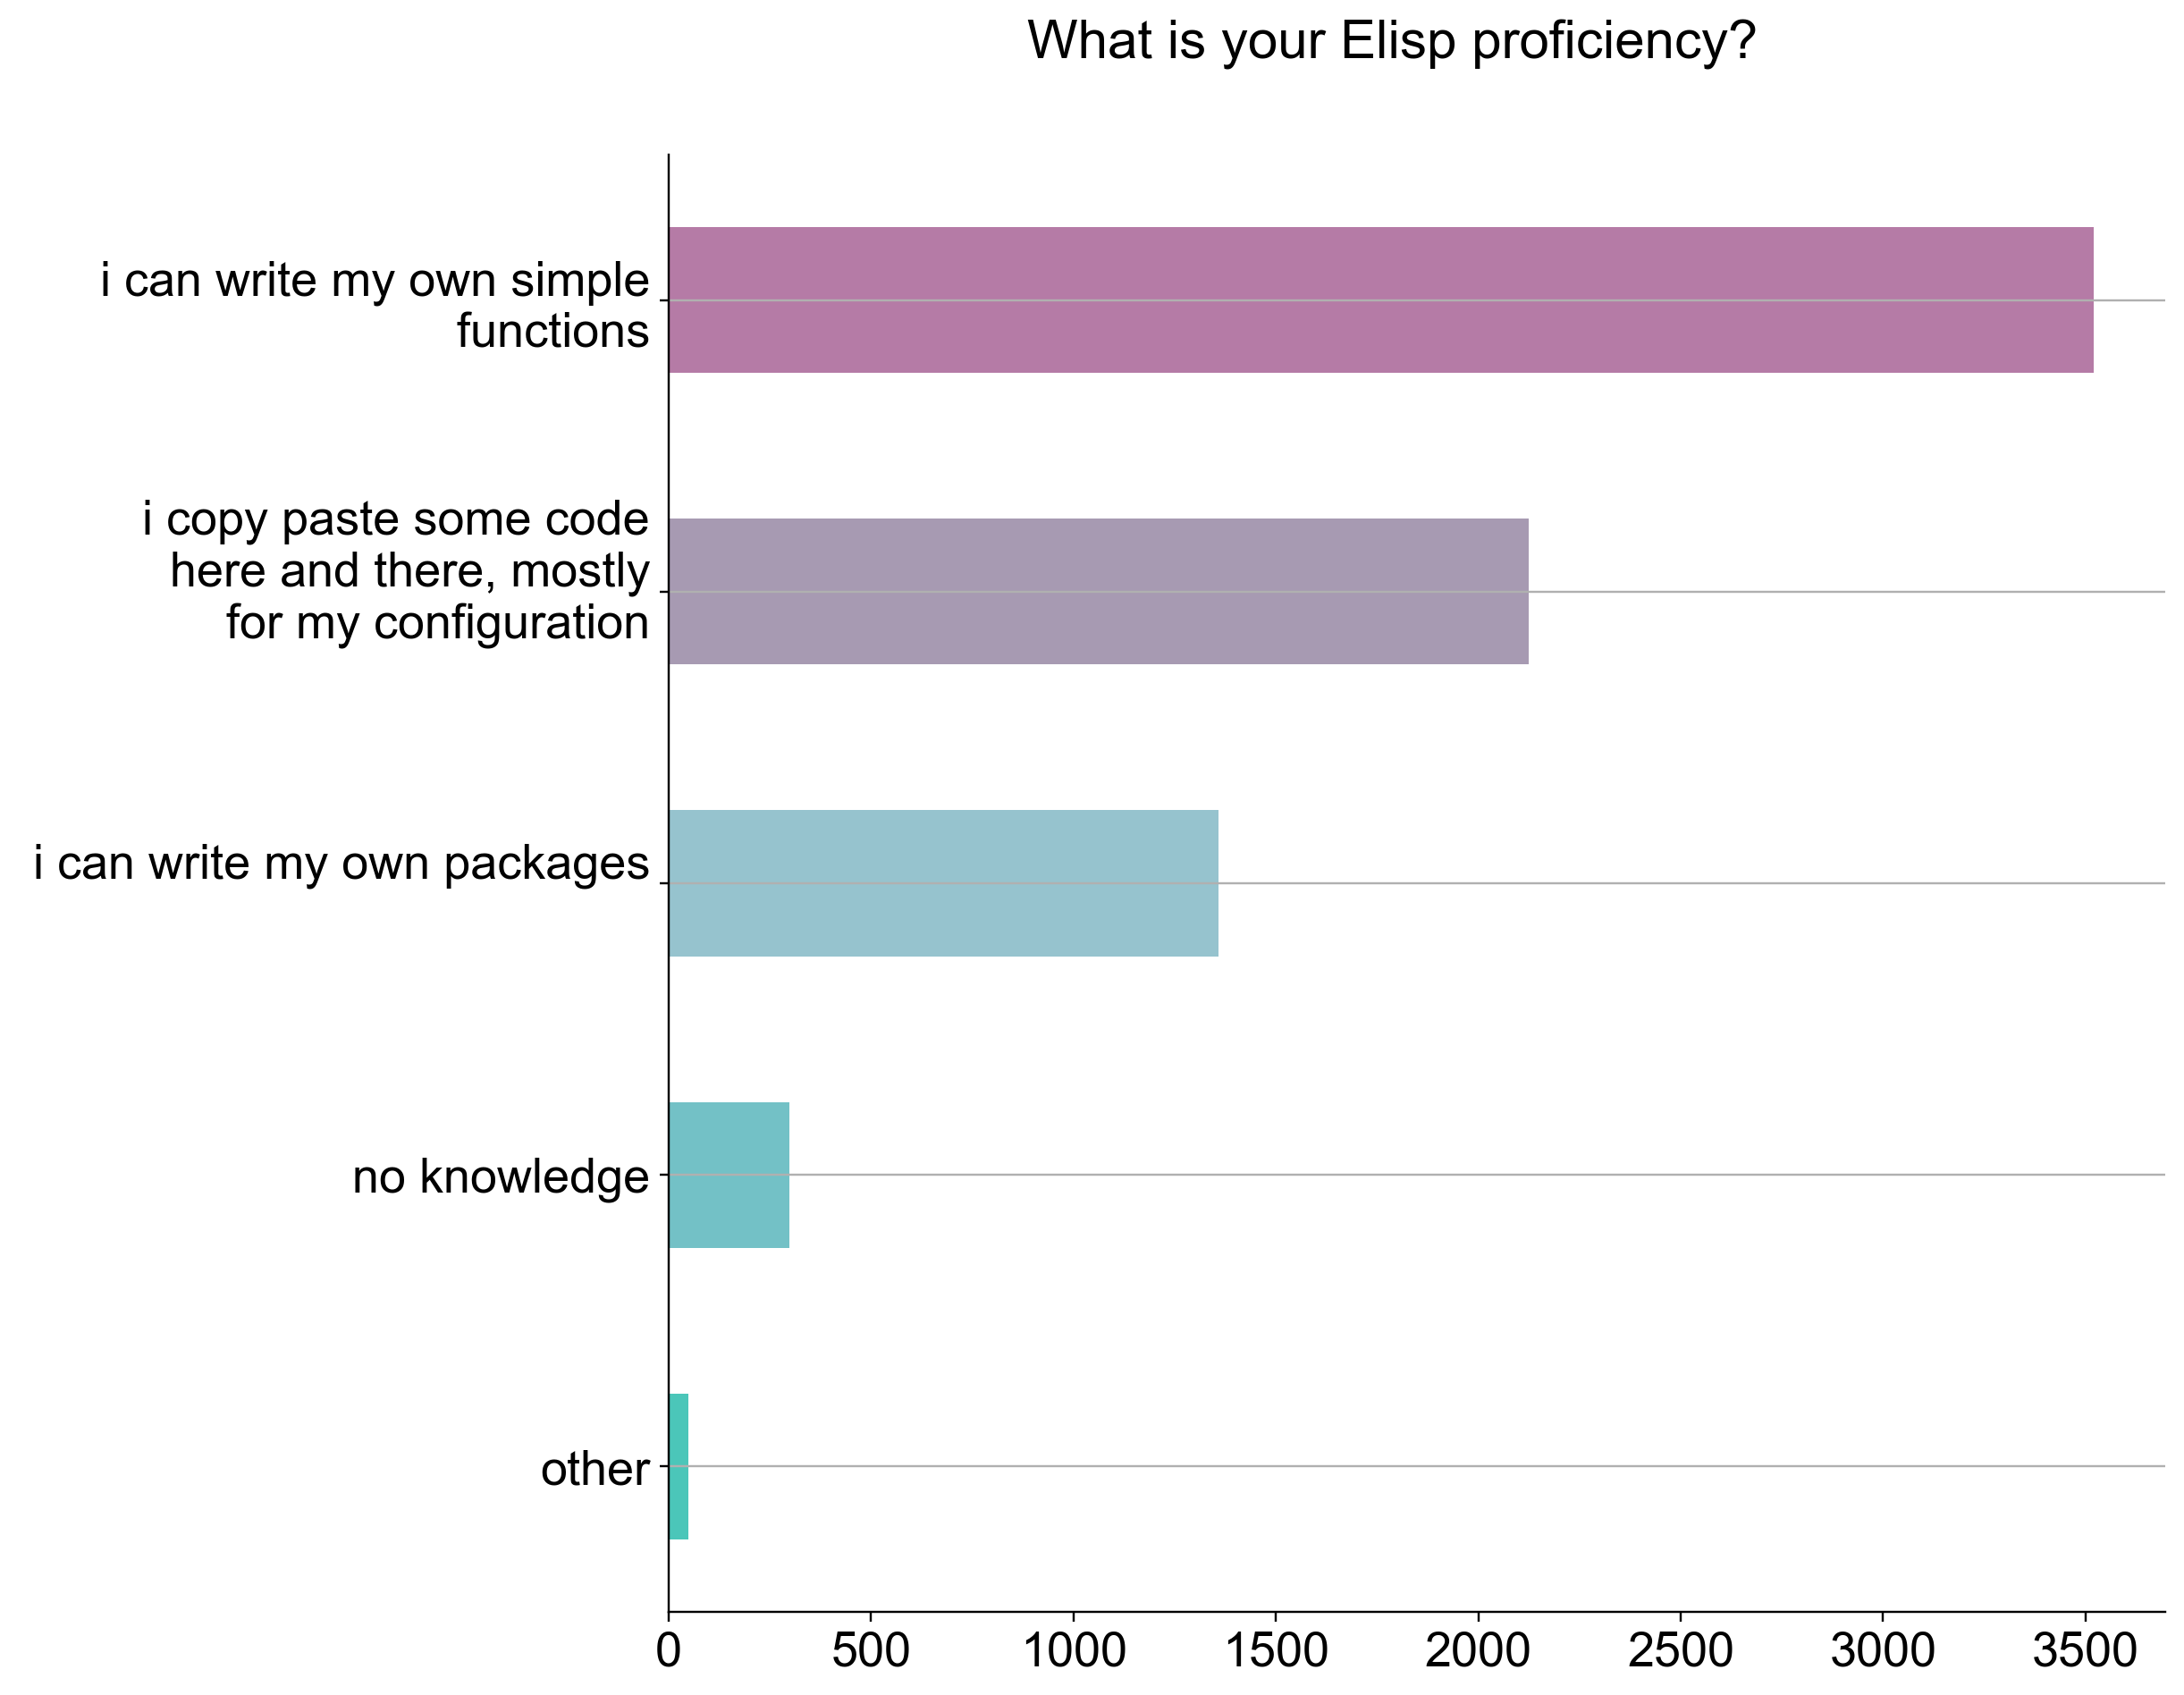

In [77]:
render('What is your Elisp proficiency?')

In [149]:
table('What is your Elisp proficiency?')

   If you use Emacs for programming, which languages do you program in?  total
4                                              python                     4886
2                                             bash/sh                     4115
22                                              other                     3685
0                                            html/css                     3206
7                                          javascript                     3065
5                                                   c                     2987
6                                                 c++                     2351
13                                                sql                     1826
8                                                rust                     1587
10                                                 go                     1459
16                                            clojure                     1304
3                                          typescrip

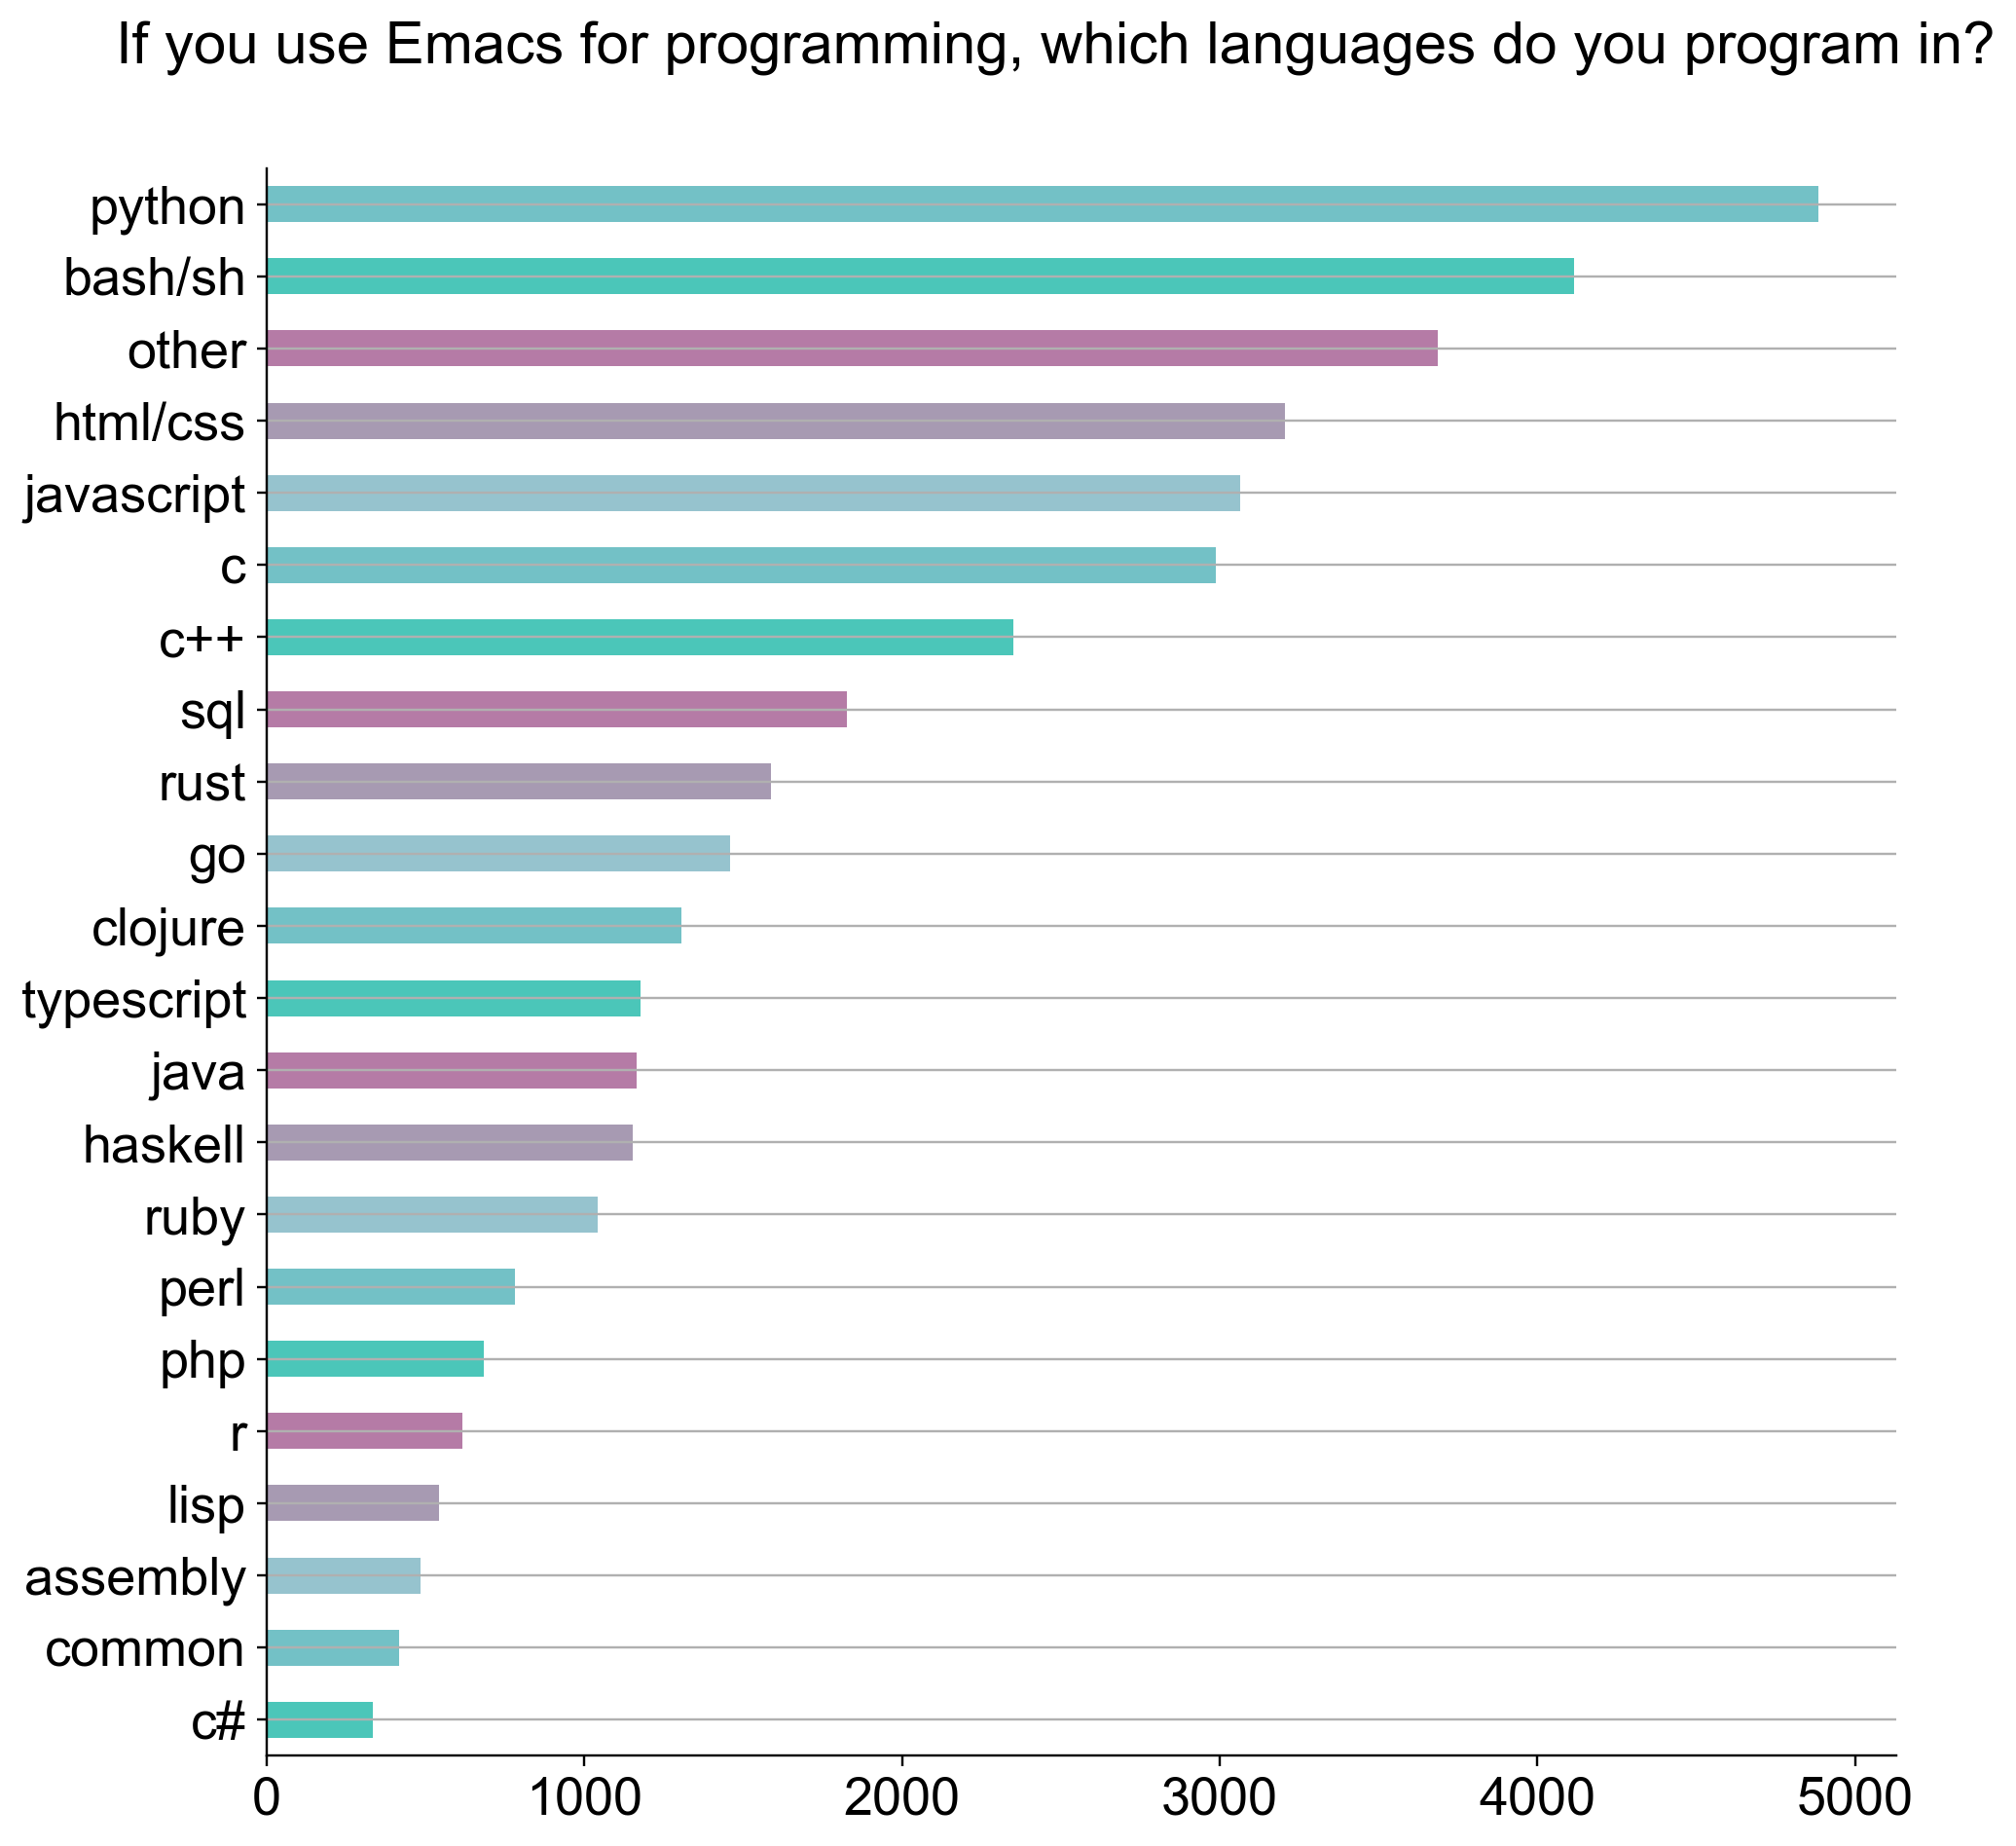

In [100]:
field = 'If you use Emacs for programming, which languages do you program in?'
df, _ = multiple_choice(field, bucket_min=250, separator=r"[;, \n]")
df = df.sort_values(by='total', ascending=False)
df = df.drop([1]) # empty value

print(df)

barh(field, df, save=True)

In [150]:
table('If you use Emacs for programming, which languages do you program in?')

In [151]:
table('Do you use a language server with lsp-mode or eglot? With what languages?')

In [152]:
table('Do you use an Emacs debugger interface? What do you use? (Gdb, dap-mode etc)')

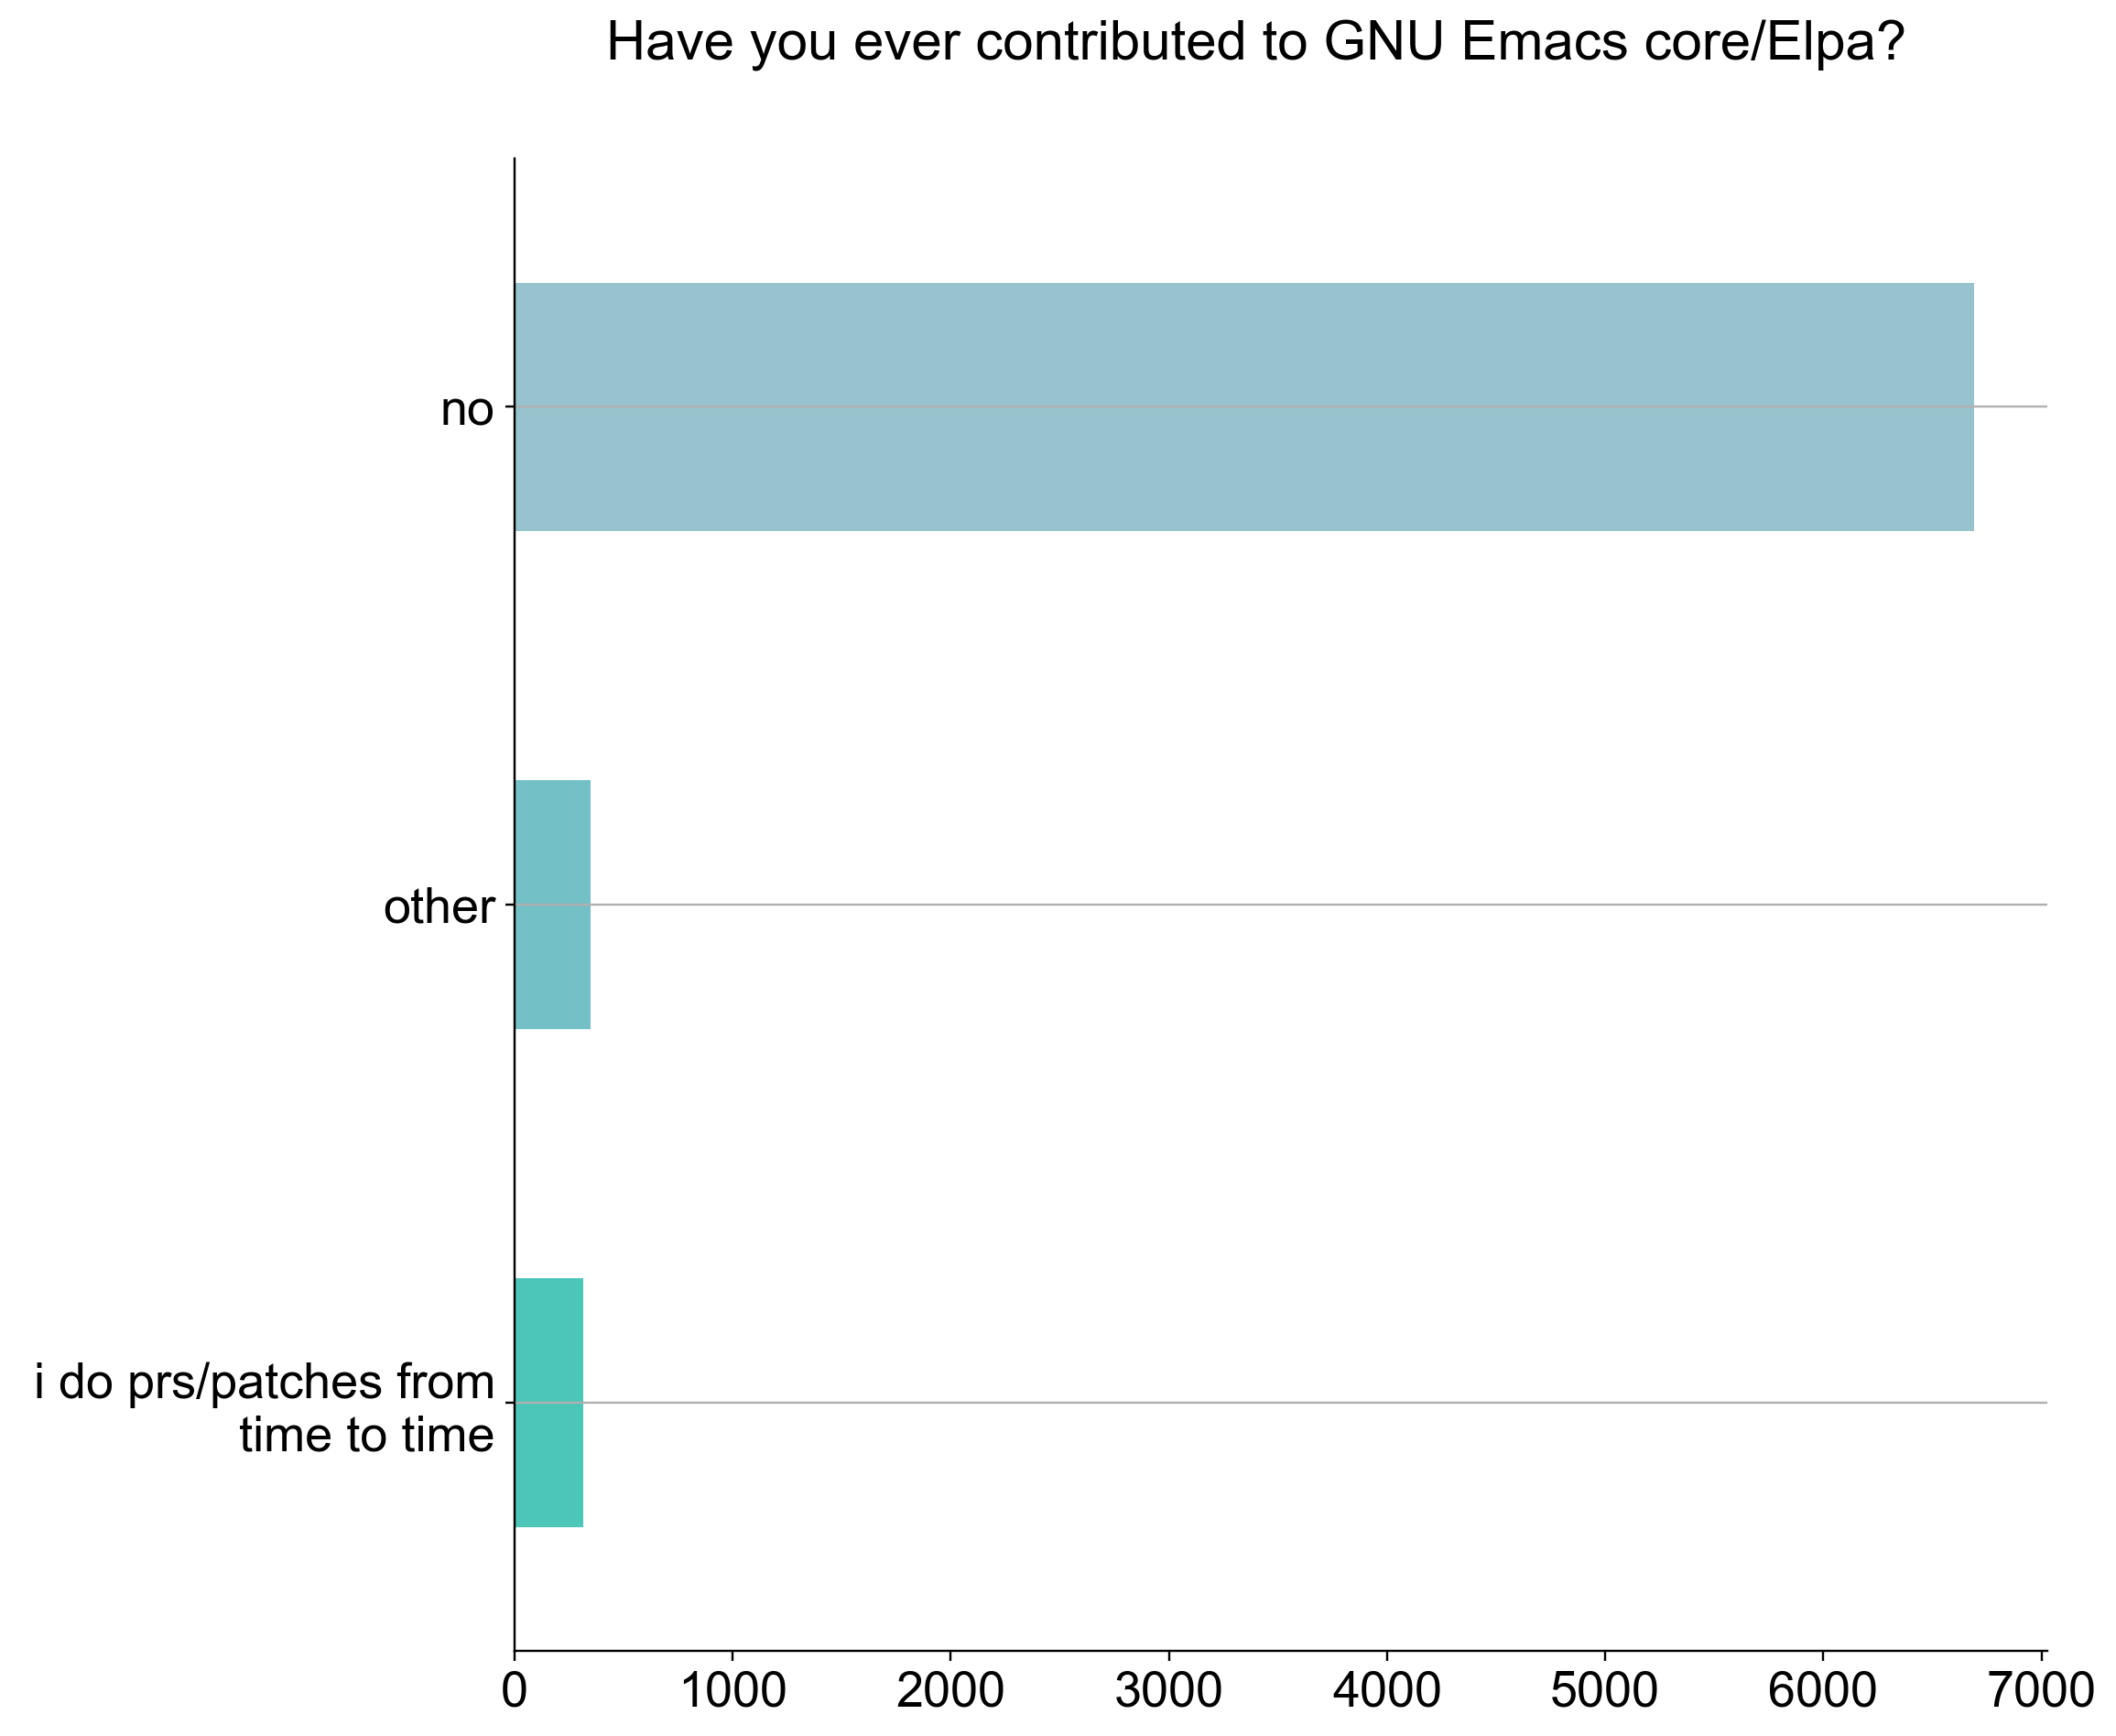

In [102]:
render('Have you ever contributed to GNU Emacs core/Elpa?')

In [153]:
table('Have you ever contributed to GNU Emacs core/Elpa?')

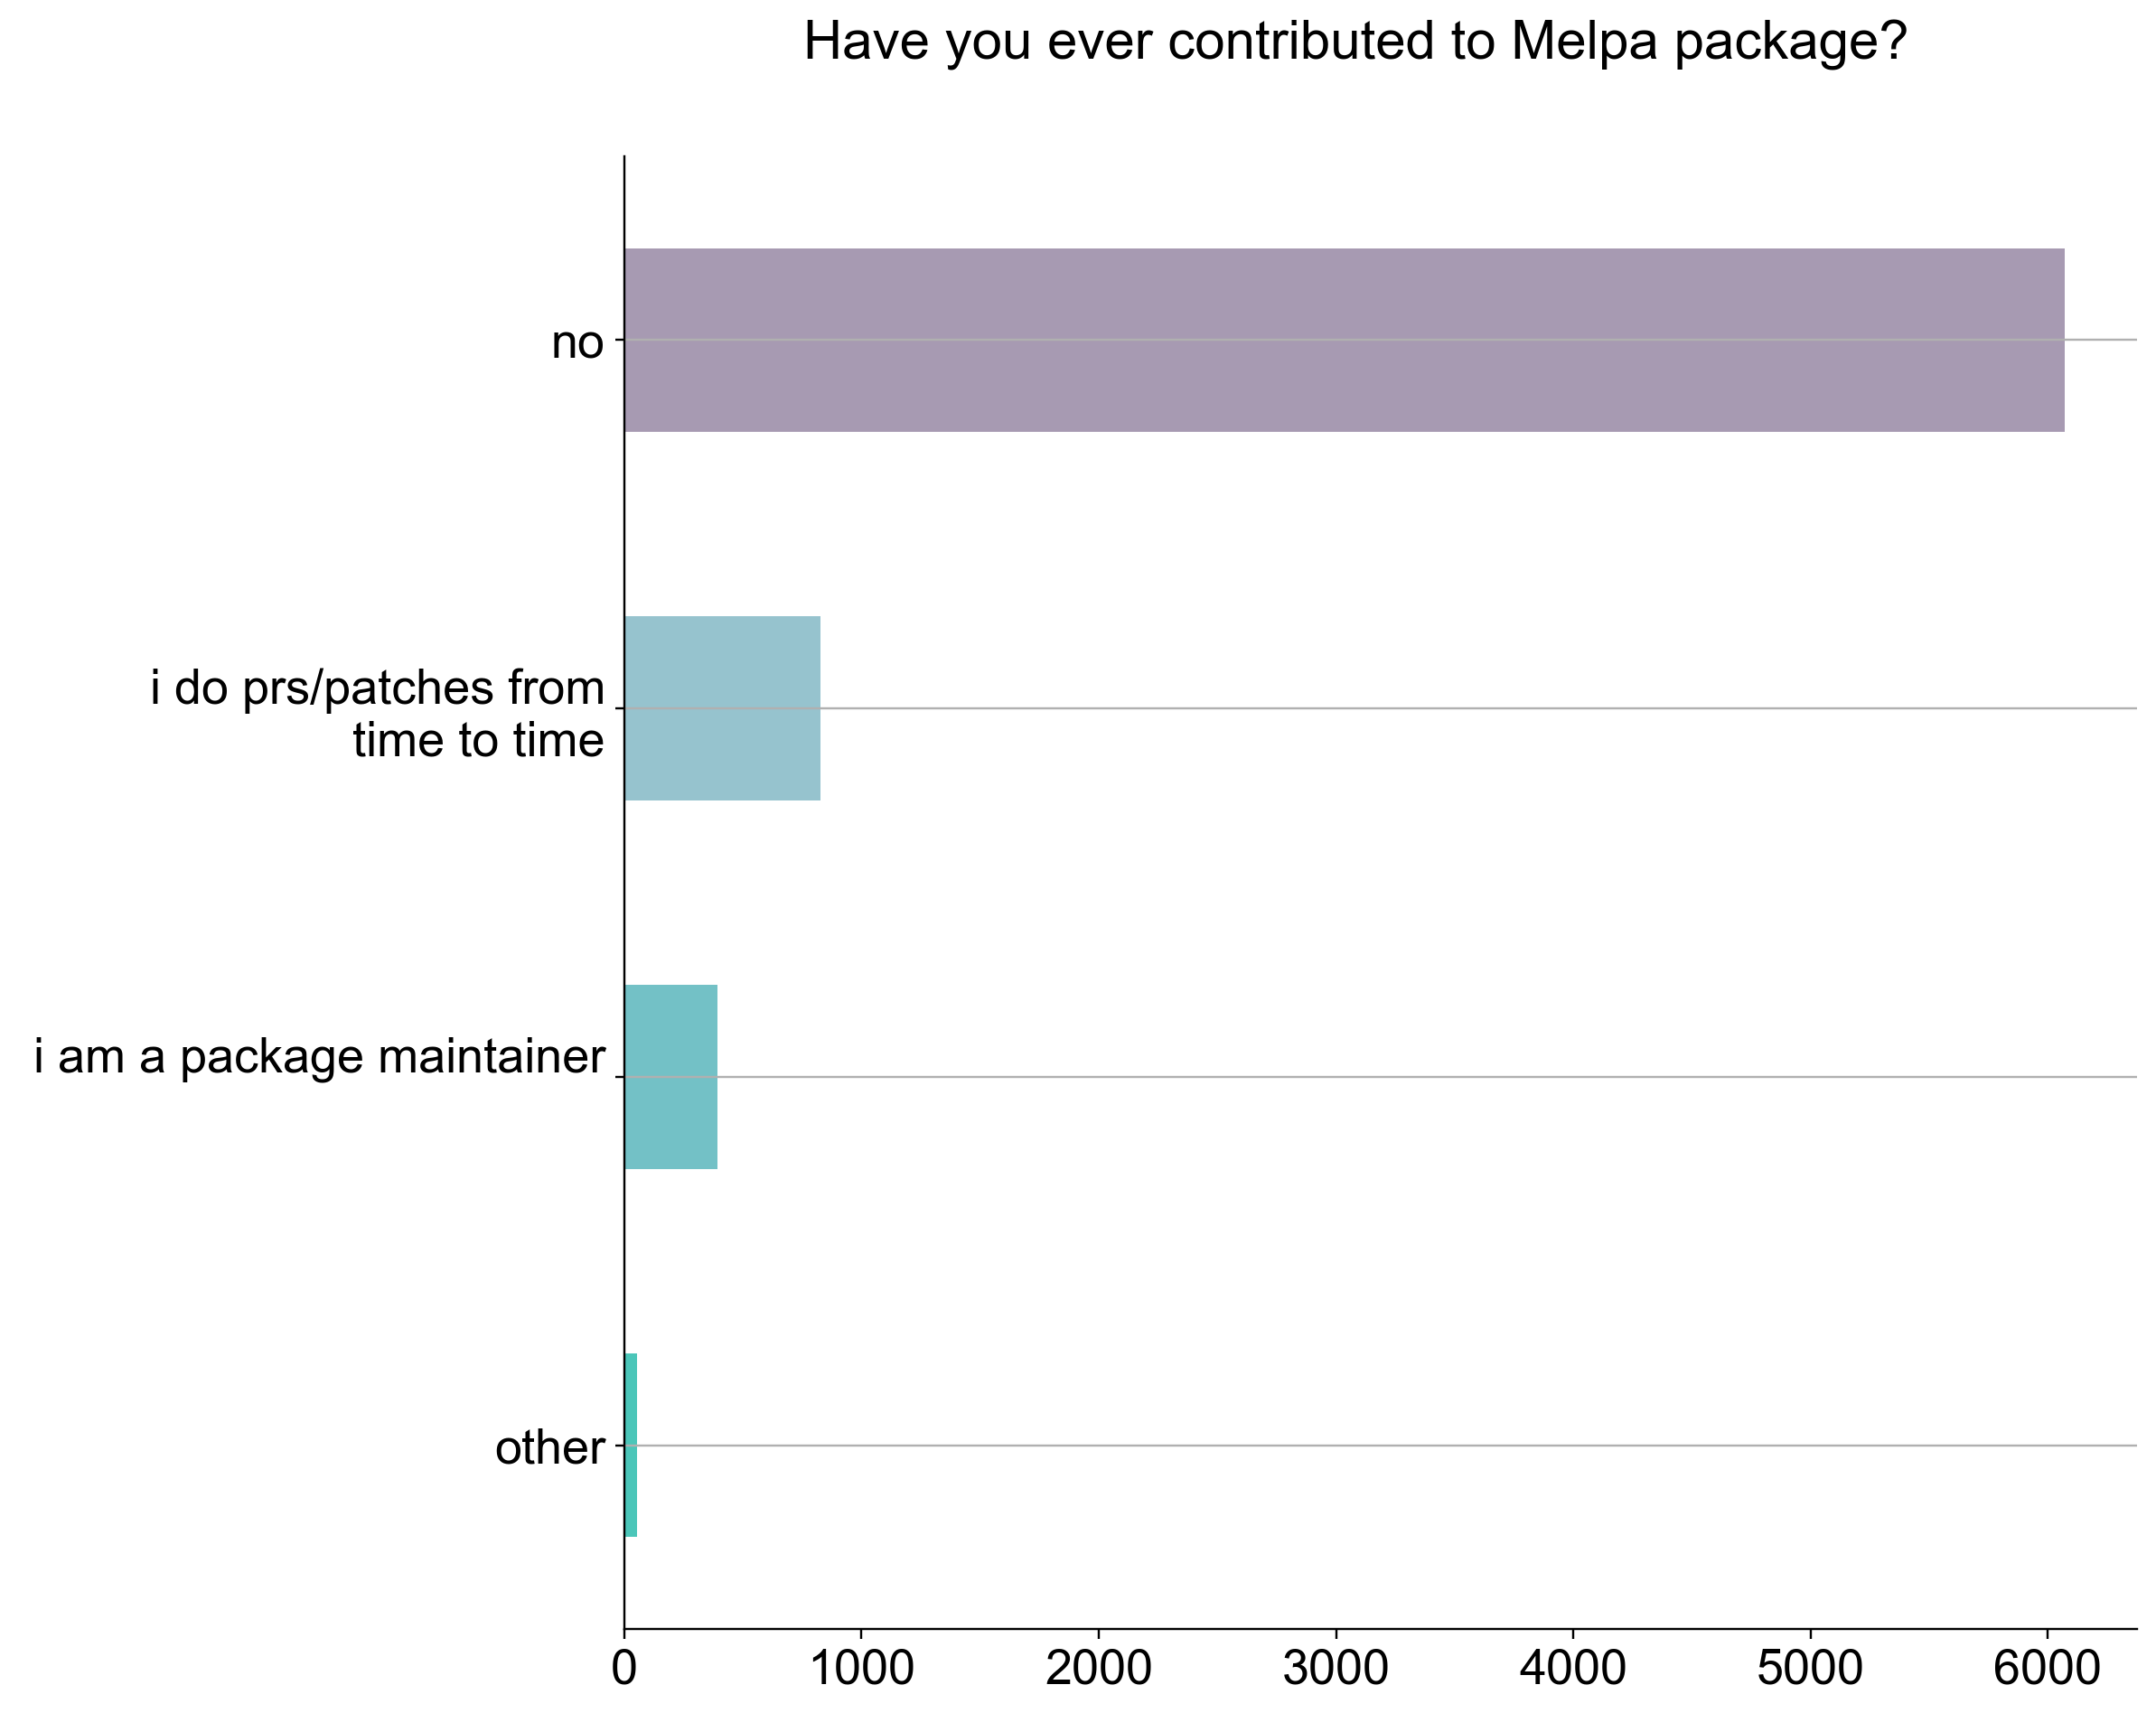

In [83]:
render('Have you ever contributed to Melpa package?')

In [154]:
table('Have you ever contributed to Melpa package?')

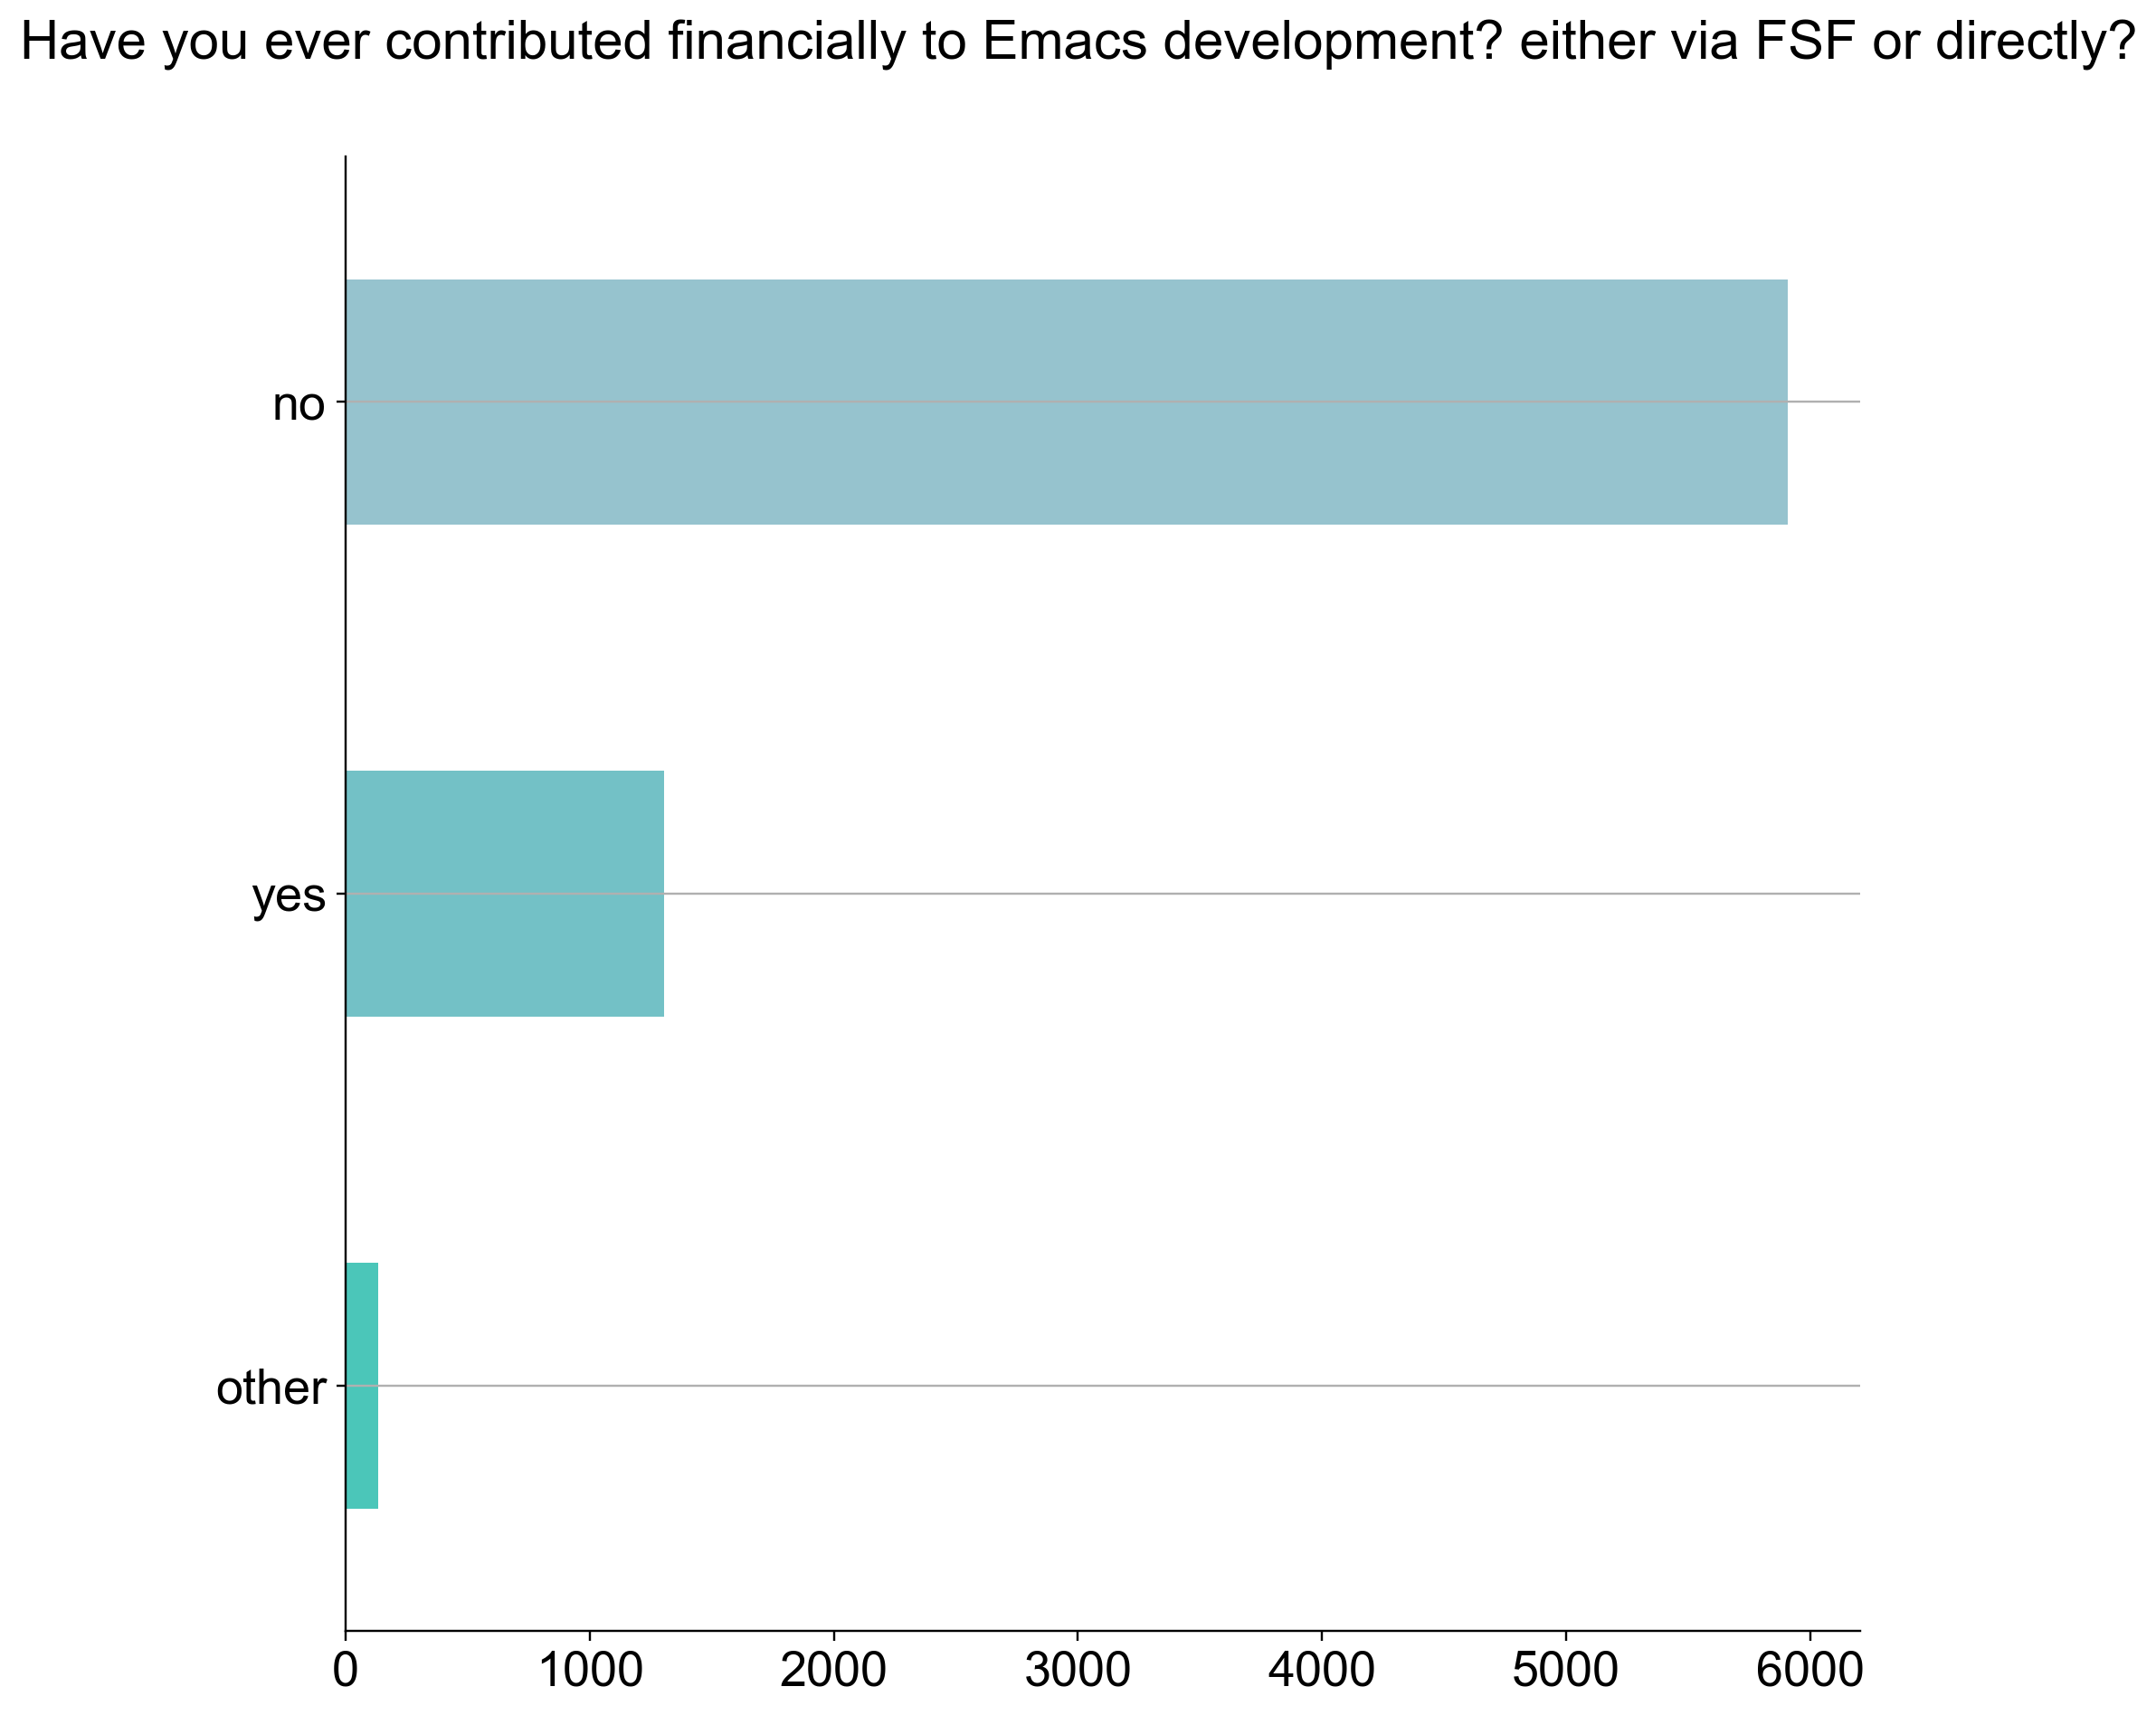

In [85]:
render('Have you ever contributed financially to Emacs development? either via FSF or directly?')

In [155]:
table('Have you ever contributed financially to Emacs development? either via FSF or directly?')

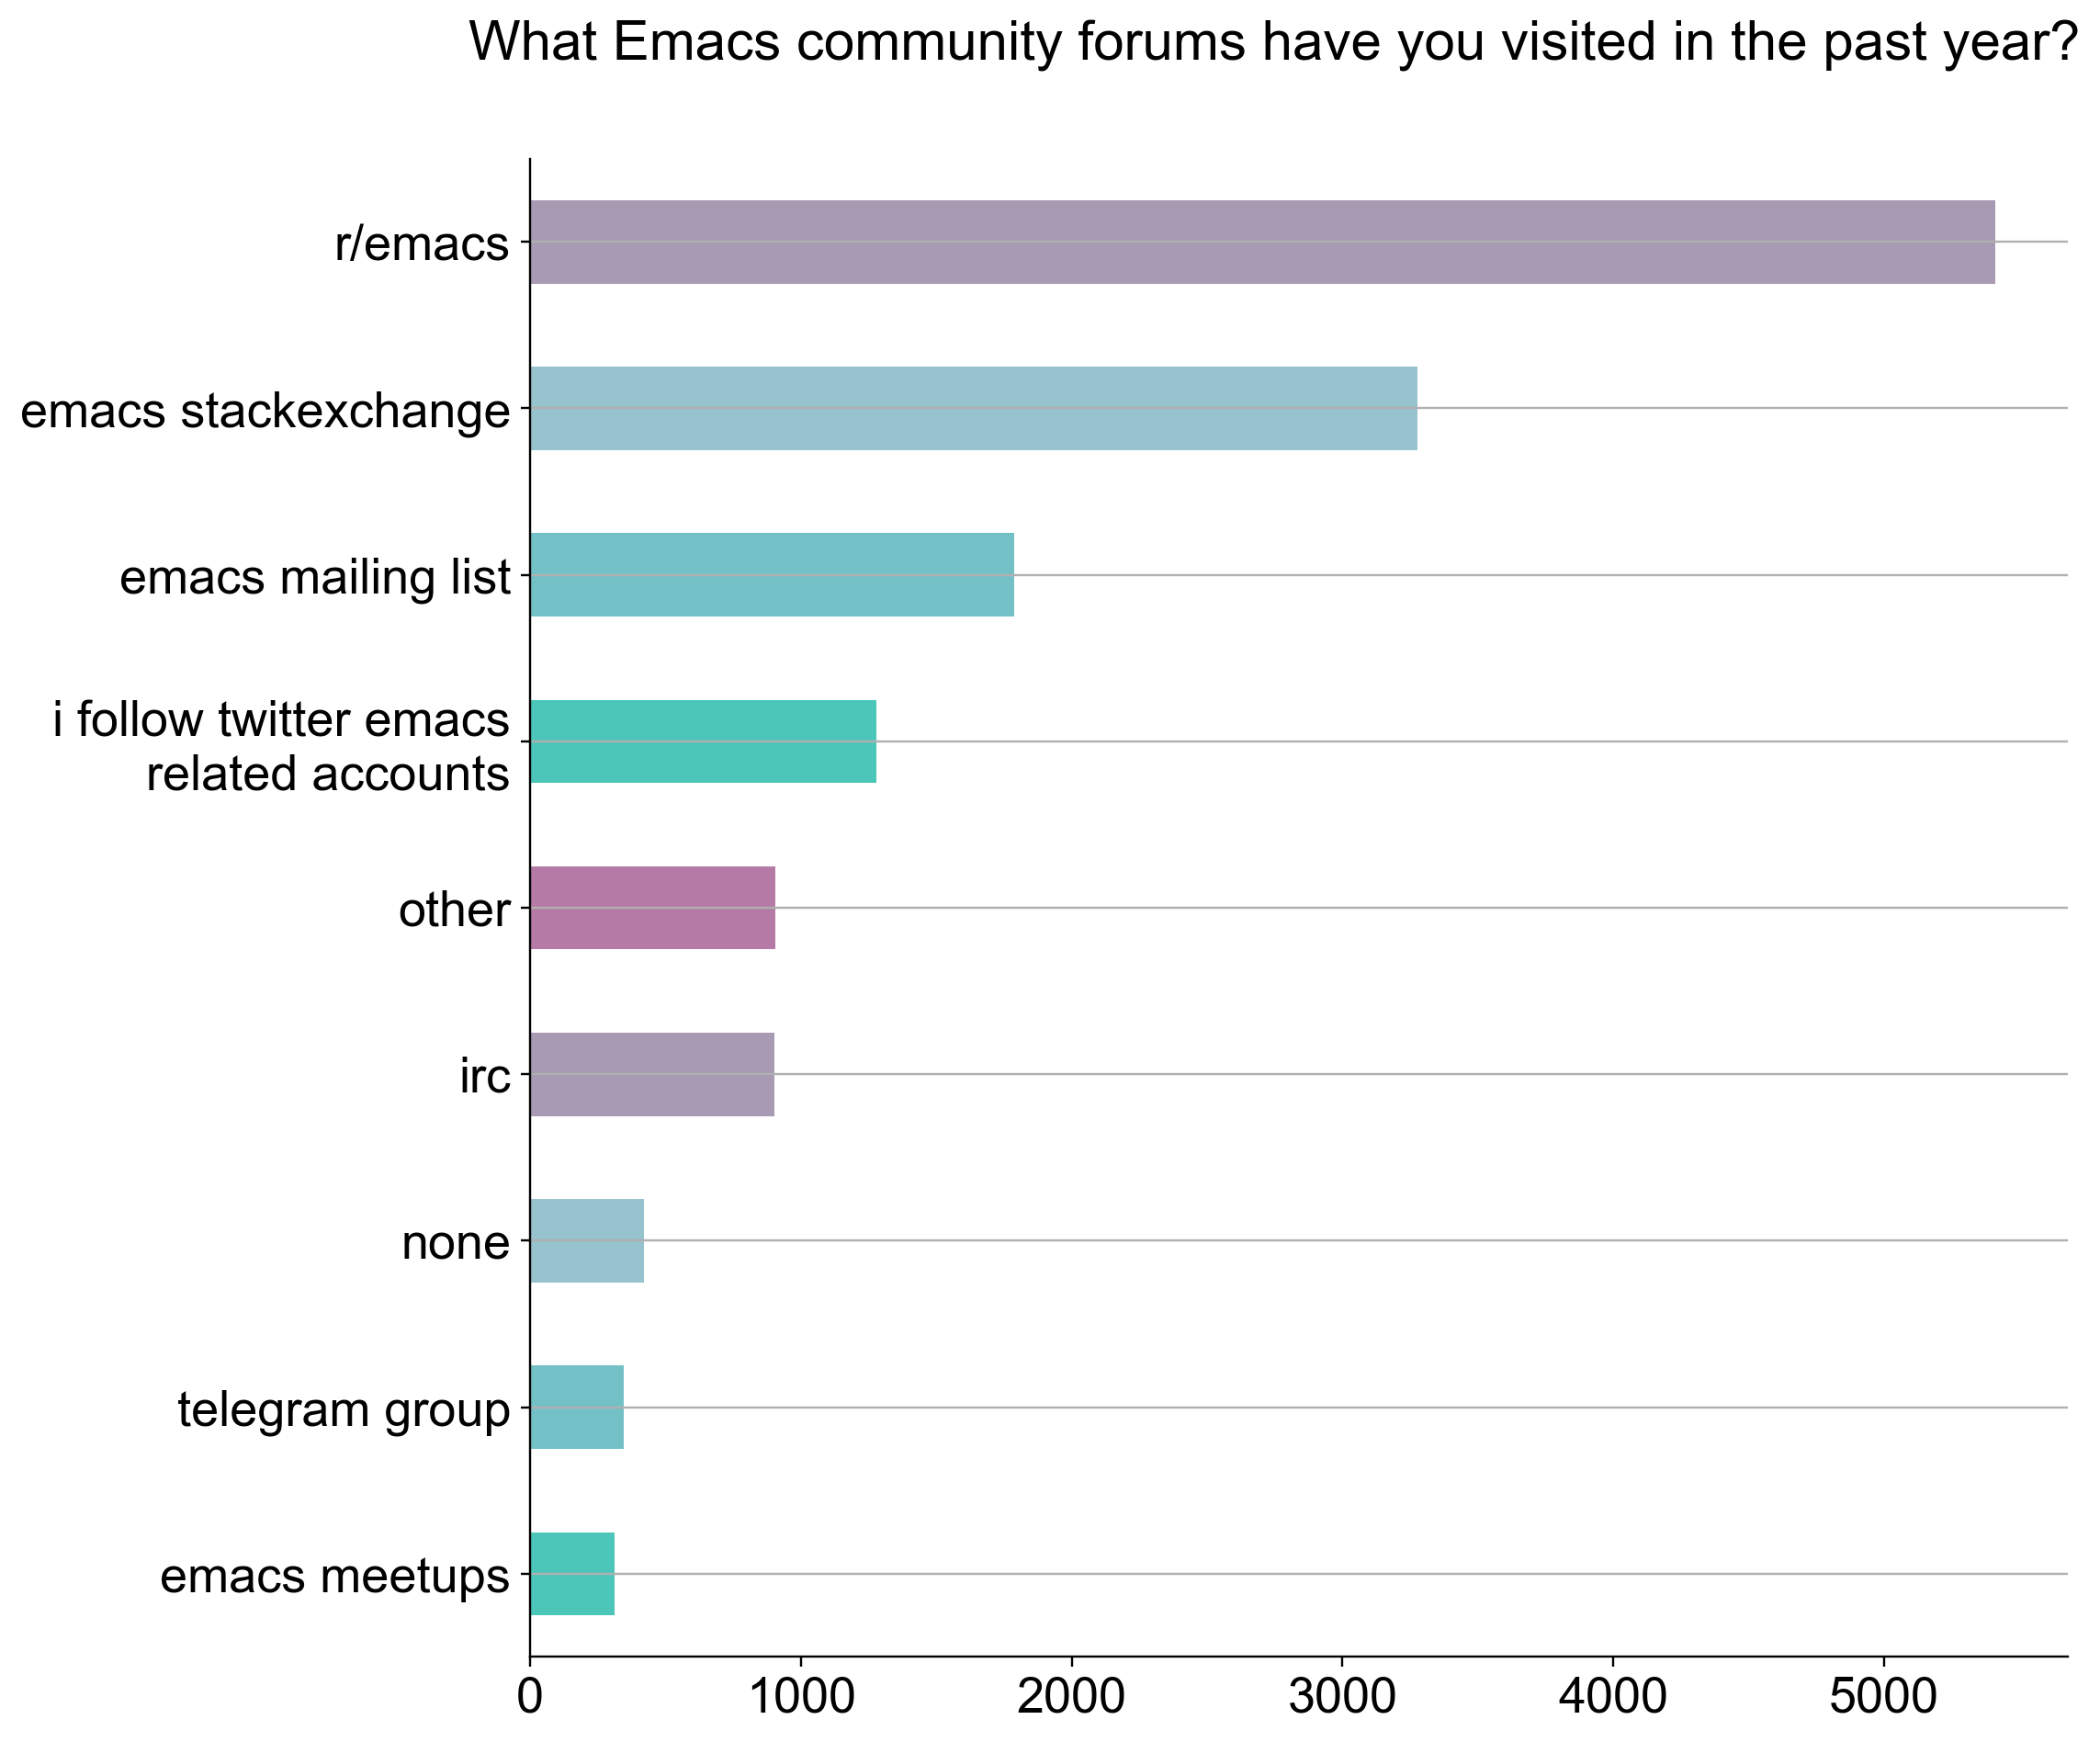

In [87]:
render('What Emacs community forums have you visited in the past year?')

In [156]:
table('What Emacs community forums have you visited in the past year?')

In [157]:
table('What are some of the Emacs improvements you are the most interested in?')

In [158]:
table('What do you think are Emacs\' greatest strengths?')

In [159]:
table('Can you recall any difficulties you faced initially learning Emacs?')

In [160]:
table('What is the one thing you would like Emacs to do differently?')

  How did you hear about this survey?  total
0                             r/emacs   2458
1                             twitter    577
2                           blog post    528
3                            telegram    187
4           someone shared it with me    684
5                        mailing list    283
6                           lobste.rs    275
7                         hacker news   1521
8                         emacs china    102
9                               other    741


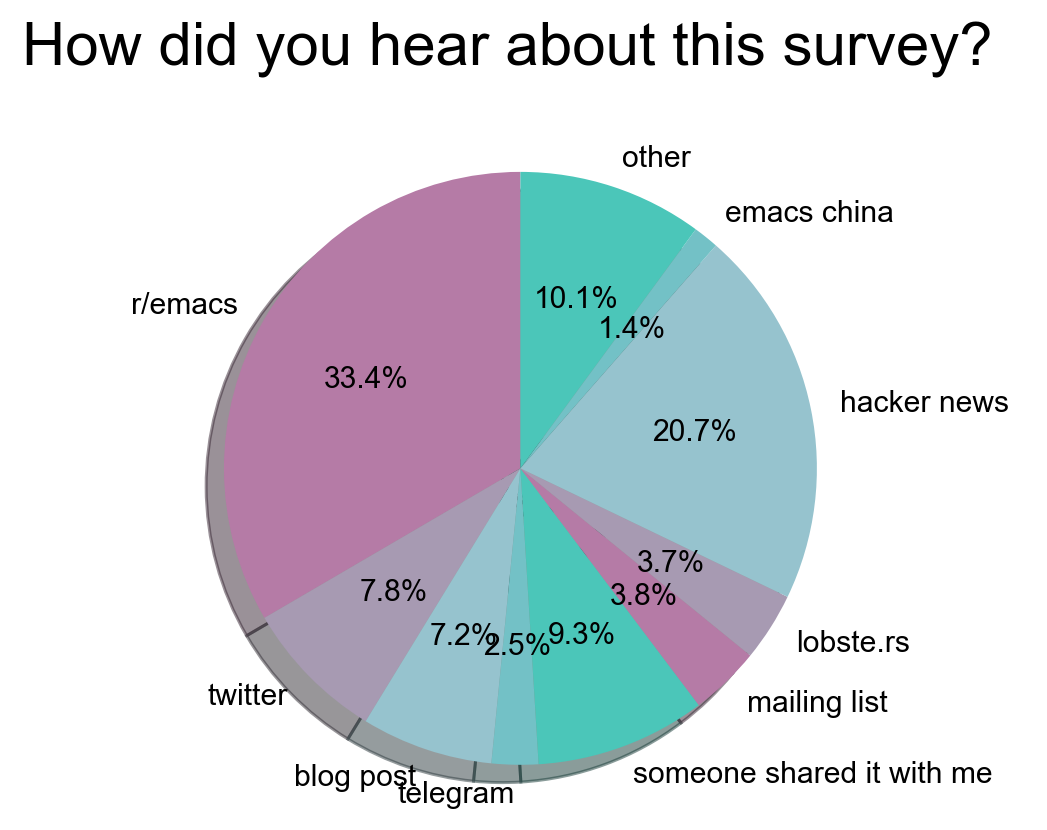

In [162]:
field = 'How did you hear about this survey?'
df, _ = multiple_choice(field, bucket_min=100)
print(df)

fig1, ax1 = plt.subplots()
ax1.pie(df['total'], labels=df[field], autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.suptitle(field, fontsize=20, y=1.02)

#plt.show()
plt.savefig(to_title(field) + '.png', bbox_inches='tight', pad_inches=.2)

In [163]:
table('How did you hear about this survey?')

In [116]:
table('If there is another survey in 2021, would you be opposed to it containing optional & general demographics questions? (It could include age brackets, gender, country or language)')

In [164]:
table('Do you have a preferred platform for filling out the survey in the future?')

In [165]:
table('Do you have general feedback about the survey process')

In [166]:
table('What is the default keybinding to find a file?')